In [1]:
from numba import jit
import numpy as np
from scipy.sparse import csr_matrix
from tqdm import tqdm
import pandas as pd

from trackml.dataset import load_event, load_dataset
from trackml.score import score_event

from tqdm import tqdm
from multiprocessing import Pool
from sklearn.neighbors import KDTree

In [2]:
def merge(cl1, cl2, min_cnt): # merge cluster 2 to cluster 1
    d = pd.DataFrame(data={'s1':cl1,'s2':cl2})
    d['N1'] = d.groupby('s1')['s1'].transform('count')
    d['N2'] = d.groupby('s2')['s2'].transform('count')
    maxs1 = d['s1'].max()
    cond = np.where((d['N2'].values>d['N1'].values) & (d['N2'].values<20) &  (d['N2'].values>min_cnt))
    #cond = np.where((d['N2'].values>d['N1'].values) & (d['N2'].values<20) )

    s1 = d['s1'].values 
    s1[cond] = d['s2'].values[cond]+maxs1 
    return s1

def create_one_event_submission(event_id, hits, labels):
    sub_data = np.column_stack(([event_id]*len(hits), hits, labels))
    submission = pd.DataFrame(data=sub_data, columns=["event_id", "hit_id", "track_id"]).astype(int)
    return submission

In [147]:
cnt = 0
for event_id, hits, cells, particles, truth in load_dataset('../storage/track_ml_data/train_5.zip'):
    if cnt == 0:
        break
    cnt += 1

In [68]:
cnt = 0
for event_id, hits, cells, particles, truth in load_dataset('../storage/track_ml_data/train_sample.zip'):
    if cnt == 2:
        break
    cnt += 1

In [3]:
@jit(nopython=True)
def clusters_to_rows_cols(clusters):
    sort_inds = np.argsort(clusters)
        
    rows = []
    cols = []
    
    cluster_start = 0
    cluster_end = -1
    
    for i in range(len(sort_inds)):
        value = clusters[sort_inds[i]]
        
        if i==len(sort_inds)-1 or value != clusters[sort_inds[i+1]]:
            cluster_end = i+1
            
            cluster_inds = sort_inds[cluster_start:cluster_end]
            
            for k in range(len(cluster_inds)):
                rows.append(cluster_inds[k])
                cols.append(cluster_inds[k])
                
                for l in range(k+1, len(cluster_inds)):
                    rows.append(cluster_inds[k])
                    cols.append(cluster_inds[l])
                    
                    rows.append(cluster_inds[l])
                    cols.append(cluster_inds[k])
                    
            cluster_start = i+1
            previous_value = value
    return np.array(rows), np.array(cols)            
    #return rows, cols
            

def clusters_to_sparse(clusters):
    rows, cols = clusters_to_rows_cols(clusters)
    
    data = np.array([1], dtype = np.uint8)
    data = np.lib.stride_tricks.as_strided(data, shape = [len(rows)], strides=[0], writeable=False)
    
    
    return csr_matrix((data, (rows, cols)), dtype = np.uint8)
    

In [4]:
clusters = np.array([1,2,2,1,1])
clusters_to_sparse(clusters).toarray()

array([[1, 0, 0, 1, 1],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [1, 0, 0, 1, 1],
       [1, 0, 0, 1, 1]], dtype=uint8)

In [4]:
ev = []
hi = []
ce = []
pa = []
tr = []
cnt = 0
for event_id, hits, cells, particles, truth in load_dataset('../storage/track_ml_data/train_5.zip'):
    if cnt == 6:
        break
    cnt += 1
    hi += [hits]
    tr += [truth]
    

In [8]:
def get_feat(i):
    
    result = np.load('predicts/luis_{}.npy'.format(i))
    
    a, val = np.unique(tr[i]['particle_id'].values, return_inverse=True)
    gt_M = clusters_to_sparse(val)
    
    matrices = []
    for k in tqdm(range(3000)):
        matrices += [clusters_to_sparse(result[k])]
    
    mean_M = csr_matrix((result.shape[1], result.shape[1]), dtype=np.int8)
    for m in tqdm(matrices):
        mean_M += m
    mean_M = mean_M / 3000
    
    idxs_1, idxs_2 = mean_M.nonzero()


    
    std_M = csr_matrix((result.shape[1], result.shape[1]), dtype=np.float16)
    for m in tqdm(matrices):
        std_M += (m-mean_M).power(2)
        std_M = std_M.sqrt() / 3000
    
    tmp = []
    for m in tqdm(matrices):
        tmp += [np.squeeze(np.asarray(m.sum(axis=0)))]
    tmp = np.array(tmp)
    
    
    X = pd.DataFrame()
    X['idxs_1'] = idxs_1
    X['idxs_2'] = idxs_2
    X['event'] = i
    X['mean'] = np.squeeze(np.asarray(mean_M[(idxs_1, idxs_2)]))
    X['std'] = np.squeeze(np.asarray(std_M[(idxs_1, idxs_2)]))
    
#     X['mean_len_1'] = np.max([tmp.mean(axis=0)[idxs_1], tmp.mean(axis=0)[idxs_2]], axis=0)
#     X['mean_len_2'] = np.min([tmp.mean(axis=0)[idxs_1], tmp.mean(axis=0)[idxs_2]], axis=0)

    X['mean_len_1'] = tmp.mean(axis=0)[idxs_1]
    X['mean_len_2'] = tmp.mean(axis=0)[idxs_2]

    X['std_len_1'] = tmp.std(axis=0)[idxs_1]
    X['std_len_2'] = tmp.std(axis=0)[idxs_2]
    
    X['max_len_1'] = tmp.max(axis=0)[idxs_1]
    X['max_len_2'] = tmp.max(axis=0)[idxs_2]
    
    X['min_len_1'] = tmp.min(axis=0)[idxs_1]
    X['min_len_2'] = tmp.min(axis=0)[idxs_2]
    
    
    
    tmp = np.squeeze(np.asarray((mean_M > 0).sum(axis=0)))
    
    
    X['tot_len_1'] = tmp[idxs_1]
    X['tot_len_2'] = tmp[idxs_2]
    #X['tot_len_common'] = np.squeeze(np.asarray(csr_matrix((mean_M > 0).multiply((mean_M > 0).sum(axis=0)))[(idxs_1, idxs_2)]))
    
    sh = np.squeeze(np.asarray(csr_matrix(m.multiply(m.sum(axis=0)))[(idxs_1, idxs_2)])).shape[0]
    tmp_quad = np.zeros(sh)
    tmp_sum = np.zeros(sh)
    tmp_max = np.zeros(sh)
    tmp_min = np.ones(sh) * 3000
    for m in tqdm(matrices):
        a = np.squeeze(np.asarray(csr_matrix(m.multiply(m.sum(axis=0)))[(idxs_1, idxs_2)]))# ** 2
        tmp_sum += a
        tmp_quad += a ** 2
        tmp_max = np.max([tmp_max, a], axis=0)
        tmp_min = np.min([tmp_min, a], axis=0)

    #tmp = np.array(tmp)
    X['mean_common_len'] = tmp_sum / 3000
    X['std_common_len'] = (tmp_quad - tmp_sum ** 2) / 3000
    X['max_common_len'] = tmp_max
    X['min_common_len'] = tmp_min

    
    

    
    
    X['target'] = np.squeeze(np.asarray(gt_M[mean_M.nonzero()]))

    return X, i

In [12]:
import gc
gc.collect()

0

In [13]:
pool = Pool(processes=8)
X_train = pd.DataFrame()
for X, i in tqdm(pool.imap(get_feat, range(6))):
    if i == 0:
        X_val = X
    else:
        X_train = pd.concat([X_train, X], axis=0)
pool.close()




0it [00:00, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 3/3000 [00:00<02:08, 23.29it/s]

  0%|          | 6/3000 [00:00<02:04, 23.98it/s]

  0%|          | 9/3000 [00:00<02:01, 24.63it/s]

  0%|          | 12/3000 [00:00<02:01, 24.51it/s]

  0%|          | 14/3000 [00:00<02:08, 23.20it/s]

  1%|          | 17/3000 [00:00<02:04, 23.99it/s]

  1%|          | 20/3000 [00:00<02:03, 24.17it/s]

  1%|          | 23/3000 [00:00<02:00, 24.74it/s]

  1%|          | 26/3000 [00:01<02:01, 24.39it/s]

  1%|          | 29/3000 [00:01<02:01, 24.54it/s]

  1%|          | 32/3000 [00:01<01:59, 24.82it/s]

  1%|          | 35/3000 [00:01<01:59, 24.84it/s]

  1%|▏         | 38/3000 [00:01<01:58, 25.04it/s]

  1%|▏         | 41/3000 [00:01<01:59, 24.82it/s]

  1%|▏         | 44/3000 [00:01<01:58, 25.02it/s]

  2%|▏         | 47/3000 [00:01<01:57, 25.08it/s]

  2%|▏         | 50/3000 [00:01<01:57, 25.15it/s]

  2%|▏         | 53/3000 [00:02<01:56, 25.29it/s]

  2%|▏         | 56/3

  0%|          | 0/3000 [00:00<?, ?it/s]

  3%|▎         | 93/3000 [00:04<02:19, 20.81it/s]

  1%|          | 28/3000 [00:01<01:56, 25.43it/s]

 13%|█▎        | 389/3000 [00:15<01:45, 24.68it/s]

  0%|          | 3/3000 [00:00<01:44, 28.55it/s]

  1%|          | 31/3000 [00:01<01:55, 25.60it/s]

 12%|█▏        | 360/3000 [00:13<01:37, 27.21it/s]

  3%|▎         | 95/3000 [00:04<02:21, 20.56it/s]

 13%|█▎        | 393/3000 [00:15<01:45, 24.74it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  1%|          | 34/3000 [00:01<01:56, 25.43it/s]

  0%|          | 7/3000 [00:00<01:47, 27.96it/s]

 12%|█▏        | 364/3000 [00:13<01:36, 27.24it/s]

 13%|█▎        | 396/3000 [00:15<01:45, 24.76it/s]

  3%|▎         | 98/3000 [00:04<02:21, 20.58it/s]

  0%|          | 10/3000 [00:00<01:42, 29.29it/s]

 12%|█▏        | 367/3000 [00:13<01:36, 27.26it/s]

  1%|          | 37/3000 [00:01<01:56, 25.41it/s]

  0%|          | 3/3000 [00:00<02:24, 20.80it/s]

 13%|█▎        | 399/3000 [00:16<01:45, 24.76i

  5%|▍         | 139/3000 [00:05<01:54, 24.94it/s]

  7%|▋         | 224/3000 [00:10<02:08, 21.69it/s]

 18%|█▊        | 531/3000 [00:18<01:28, 27.97it/s]

  6%|▌         | 185/3000 [00:06<01:46, 26.49it/s]

  6%|▌         | 171/3000 [00:05<01:37, 28.96it/s]

  5%|▍         | 142/3000 [00:05<01:54, 25.00it/s]

 18%|█▊        | 541/3000 [00:21<01:38, 24.96it/s]

  8%|▊         | 227/3000 [00:10<02:07, 21.69it/s]

 18%|█▊        | 534/3000 [00:19<01:28, 27.94it/s]

  6%|▌         | 174/3000 [00:06<01:37, 28.90it/s]

  6%|▋         | 189/3000 [00:07<01:45, 26.56it/s]

  5%|▍         | 145/3000 [00:05<01:54, 24.93it/s]

 18%|█▊        | 544/3000 [00:21<01:38, 24.95it/s]

 18%|█▊        | 537/3000 [00:19<01:28, 27.92it/s]

  6%|▋         | 192/3000 [00:07<01:45, 26.59it/s]

  8%|▊         | 230/3000 [00:10<02:07, 21.68it/s]

  6%|▌         | 177/3000 [00:06<01:37, 28.81it/s]

  5%|▍         | 148/3000 [00:05<01:54, 24.85it/s]

 18%|█▊        | 548/3000 [00:21<01:38, 24.98it/s]

 18%|█▊     

 12%|█▏        | 353/3000 [00:16<02:00, 21.88it/s]

 11%|█▏        | 341/3000 [00:12<01:39, 26.68it/s]

 23%|██▎       | 690/3000 [00:27<01:31, 25.12it/s]

 23%|██▎       | 698/3000 [00:24<01:21, 28.08it/s]

 11%|█▏        | 344/3000 [00:11<01:30, 29.28it/s]

  9%|▉         | 280/3000 [00:11<01:51, 24.33it/s]

 12%|█▏        | 356/3000 [00:16<02:00, 21.88it/s]

 11%|█▏        | 344/3000 [00:12<01:39, 26.59it/s]

 23%|██▎       | 701/3000 [00:24<01:21, 28.08it/s]

  9%|▉         | 283/3000 [00:11<01:51, 24.36it/s]

 23%|██▎       | 693/3000 [00:27<01:31, 25.10it/s]

 12%|█▏        | 348/3000 [00:11<01:30, 29.27it/s]

 12%|█▏        | 347/3000 [00:13<01:39, 26.62it/s]

 12%|█▏        | 359/3000 [00:16<02:00, 21.87it/s]

 23%|██▎       | 704/3000 [00:25<01:21, 28.08it/s]

 10%|▉         | 286/3000 [00:11<01:51, 24.36it/s]

 23%|██▎       | 696/3000 [00:27<01:31, 25.11it/s]

 12%|█▏        | 352/3000 [00:12<01:30, 29.28it/s]

 12%|█▏        | 362/3000 [00:16<02:00, 21.88it/s]

 12%|█▏     

 17%|█▋        | 515/3000 [00:17<01:24, 29.45it/s]

 16%|█▋        | 492/3000 [00:18<01:34, 26.48it/s]

 29%|██▊       | 858/3000 [00:30<01:16, 28.03it/s]

 28%|██▊       | 842/3000 [00:33<01:25, 25.29it/s]

 17%|█▋        | 518/3000 [00:17<01:24, 29.45it/s]

 16%|█▌        | 481/3000 [00:22<01:55, 21.79it/s]

 14%|█▍        | 428/3000 [00:17<01:44, 24.66it/s]

 29%|██▊       | 862/3000 [00:30<01:16, 28.06it/s]

 16%|█▋        | 495/3000 [00:18<01:34, 26.45it/s]

 28%|██▊       | 845/3000 [00:33<01:25, 25.29it/s]

 16%|█▌        | 484/3000 [00:22<01:55, 21.81it/s]

 14%|█▍        | 431/3000 [00:17<01:44, 24.65it/s]

 29%|██▉       | 866/3000 [00:30<01:16, 28.05it/s]

 17%|█▋        | 498/3000 [00:18<01:34, 26.41it/s]

 17%|█▋        | 522/3000 [00:17<01:24, 29.36it/s]

 28%|██▊       | 849/3000 [00:33<01:24, 25.32it/s]

 16%|█▌        | 487/3000 [00:22<01:55, 21.82it/s]

 14%|█▍        | 434/3000 [00:17<01:44, 24.64it/s]

 29%|██▉       | 869/3000 [00:30<01:15, 28.04it/s]

 17%|█▋     

 33%|███▎      | 993/3000 [00:39<01:18, 25.41it/s]

 19%|█▉        | 568/3000 [00:23<01:38, 24.58it/s]

 20%|██        | 607/3000 [00:27<01:49, 21.81it/s]

 34%|███▍      | 1032/3000 [00:36<01:09, 28.28it/s]

 21%|██▏       | 644/3000 [00:24<01:29, 26.25it/s]

 33%|███▎      | 996/3000 [00:39<01:18, 25.42it/s]

 23%|██▎       | 688/3000 [00:23<01:18, 29.31it/s]

 19%|█▉        | 571/3000 [00:23<01:38, 24.58it/s]

 34%|███▍      | 1035/3000 [00:36<01:09, 28.28it/s]

 20%|██        | 610/3000 [00:27<01:49, 21.81it/s]

 22%|██▏       | 647/3000 [00:24<01:29, 26.25it/s]

 33%|███▎      | 999/3000 [00:39<01:18, 25.42it/s]

 19%|█▉        | 574/3000 [00:23<01:38, 24.59it/s]

 23%|██▎       | 691/3000 [00:23<01:18, 29.29it/s]

 35%|███▍      | 1038/3000 [00:36<01:09, 28.28it/s]

 20%|██        | 613/3000 [00:28<01:49, 21.81it/s]

 22%|██▏       | 650/3000 [00:24<01:29, 26.26it/s]

 33%|███▎      | 1002/3000 [00:39<01:18, 25.43it/s]

 23%|██▎       | 694/3000 [00:23<01:18, 29.29it/s]

 35%|███

 38%|███▊      | 1141/3000 [00:44<01:12, 25.51it/s]

 26%|██▌       | 786/3000 [00:30<01:24, 26.09it/s]

 24%|██▎       | 707/3000 [00:28<01:33, 24.54it/s]

 24%|██▍       | 733/3000 [00:33<01:43, 21.84it/s]

 40%|███▉      | 1192/3000 [00:42<01:04, 28.24it/s]

 28%|██▊       | 847/3000 [00:29<01:14, 29.09it/s]

 38%|███▊      | 1144/3000 [00:44<01:12, 25.51it/s]

 26%|██▋       | 789/3000 [00:30<01:24, 26.09it/s]

 24%|██▎       | 710/3000 [00:28<01:33, 24.53it/s]

 40%|███▉      | 1195/3000 [00:42<01:03, 28.24it/s]

 25%|██▍       | 736/3000 [00:33<01:43, 21.84it/s]

 38%|███▊      | 1147/3000 [00:44<01:12, 25.51it/s]

 28%|██▊       | 851/3000 [00:29<01:13, 29.09it/s]

 26%|██▋       | 792/3000 [00:30<01:24, 26.08it/s]

 24%|██▍       | 713/3000 [00:29<01:33, 24.53it/s]

 40%|███▉      | 1198/3000 [00:42<01:03, 28.23it/s]

 38%|███▊      | 1150/3000 [00:45<01:12, 25.51it/s]

 28%|██▊       | 854/3000 [00:29<01:13, 29.09it/s]

 25%|██▍       | 739/3000 [00:33<01:43, 21.82it/s]

 26%|

 44%|████▎     | 1309/3000 [00:50<01:05, 25.94it/s]

 28%|██▊       | 845/3000 [00:34<01:28, 24.48it/s]

 34%|███▎      | 1007/3000 [00:34<01:08, 28.97it/s]

 31%|███       | 937/3000 [00:35<01:18, 26.12it/s]

 28%|██▊       | 855/3000 [00:39<01:38, 21.76it/s]

 46%|████▌     | 1370/3000 [00:47<00:57, 28.58it/s]

 44%|████▍     | 1313/3000 [00:50<01:04, 25.96it/s]

 28%|██▊       | 848/3000 [00:34<01:27, 24.49it/s]

 34%|███▎      | 1010/3000 [00:34<01:08, 28.96it/s]

 31%|███▏      | 941/3000 [00:36<01:18, 26.14it/s]

 29%|██▊       | 858/3000 [00:39<01:38, 21.77it/s]

 46%|████▌     | 1374/3000 [00:48<00:56, 28.57it/s]

 34%|███▍      | 1014/3000 [00:34<01:08, 28.98it/s]

 44%|████▍     | 1317/3000 [00:50<01:04, 25.96it/s]

 28%|██▊       | 851/3000 [00:34<01:27, 24.48it/s]

 31%|███▏      | 944/3000 [00:36<01:18, 26.14it/s]

 29%|██▊       | 861/3000 [00:39<01:38, 21.76it/s]

 46%|████▌     | 1378/3000 [00:48<00:56, 28.58it/s]

 32%|███▏      | 947/3000 [00:36<01:18, 26.15it/s]

 44

 33%|███▎      | 988/3000 [00:44<01:31, 21.97it/s]

 51%|█████     | 1537/3000 [00:53<00:51, 28.67it/s]

 39%|███▉      | 1172/3000 [00:40<01:03, 28.93it/s]

 49%|████▊     | 1462/3000 [00:56<00:59, 25.99it/s]

 36%|███▌      | 1087/3000 [00:41<01:13, 26.11it/s]

 33%|███▎      | 991/3000 [00:45<01:31, 21.98it/s]

 33%|███▎      | 980/3000 [00:40<01:23, 24.28it/s]

 39%|███▉      | 1176/3000 [00:40<01:03, 28.93it/s]

 51%|█████▏    | 1541/3000 [00:53<00:50, 28.67it/s]

 49%|████▉     | 1465/3000 [00:56<00:59, 25.98it/s]

 36%|███▋      | 1090/3000 [00:41<01:13, 26.10it/s]

 33%|███▎      | 983/3000 [00:40<01:23, 24.28it/s]

 39%|███▉      | 1179/3000 [00:40<01:02, 28.94it/s]

 33%|███▎      | 995/3000 [00:45<01:31, 22.00it/s]

 52%|█████▏    | 1545/3000 [00:53<00:50, 28.68it/s]

 49%|████▉     | 1468/3000 [00:56<00:58, 25.98it/s]

 36%|███▋      | 1093/3000 [00:41<01:13, 26.09it/s]

 33%|███▎      | 986/3000 [00:40<01:22, 24.29it/s]

 33%|███▎      | 998/3000 [00:45<01:30, 22.01it/s]



 54%|█████▍    | 1621/3000 [01:01<00:52, 26.15it/s]

 57%|█████▋    | 1713/3000 [00:59<00:44, 28.84it/s]

 45%|████▍     | 1349/3000 [00:46<00:56, 29.14it/s]

 42%|████▏     | 1247/3000 [00:47<01:06, 26.30it/s]

 37%|███▋      | 1118/3000 [00:50<01:25, 21.99it/s]

 54%|█████▍    | 1624/3000 [01:02<00:52, 26.15it/s]

 38%|███▊      | 1134/3000 [00:46<01:15, 24.57it/s]

 57%|█████▋    | 1717/3000 [00:59<00:44, 28.85it/s]

 45%|████▌     | 1353/3000 [00:46<00:56, 29.14it/s]

 42%|████▏     | 1250/3000 [00:47<01:06, 26.30it/s]

 54%|█████▍    | 1627/3000 [01:02<00:52, 26.15it/s]

 37%|███▋      | 1122/3000 [00:50<01:25, 22.01it/s]

 57%|█████▋    | 1721/3000 [00:59<00:44, 28.86it/s]

 38%|███▊      | 1137/3000 [00:46<01:15, 24.57it/s]

 45%|████▌     | 1357/3000 [00:46<00:56, 29.16it/s]

 42%|████▏     | 1253/3000 [00:47<01:06, 26.29it/s]

 38%|███▊      | 1125/3000 [00:51<01:25, 22.02it/s]

 54%|█████▍    | 1631/3000 [01:02<00:52, 26.16it/s]

 38%|███▊      | 1140/3000 [00:46<01:15, 24.57

 42%|████▏     | 1266/3000 [00:51<01:10, 24.48it/s]

 50%|█████     | 1509/3000 [00:51<00:51, 29.04it/s]

 46%|████▋     | 1394/3000 [00:53<01:01, 26.27it/s]

 64%|██████▎   | 1909/3000 [01:05<00:37, 29.30it/s]

 60%|██████    | 1802/3000 [01:07<00:45, 26.58it/s]

 42%|████▏     | 1245/3000 [00:56<01:19, 22.02it/s]

 42%|████▏     | 1269/3000 [00:51<01:10, 24.49it/s]

 50%|█████     | 1513/3000 [00:52<00:51, 29.05it/s]

 47%|████▋     | 1397/3000 [00:53<01:01, 26.27it/s]

 64%|██████▍   | 1913/3000 [01:05<00:37, 29.31it/s]

 60%|██████    | 1806/3000 [01:07<00:44, 26.60it/s]

 51%|█████     | 1517/3000 [00:52<00:51, 29.07it/s]

 42%|████▏     | 1272/3000 [00:51<01:10, 24.48it/s]

 47%|████▋     | 1401/3000 [00:53<01:00, 26.28it/s]

 42%|████▏     | 1248/3000 [00:56<01:19, 22.01it/s]

 64%|██████▍   | 1917/3000 [01:05<00:36, 29.32it/s]

 51%|█████     | 1521/3000 [00:52<00:50, 29.07it/s]

 43%|████▎     | 1276/3000 [00:52<01:10, 24.50it/s]

 60%|██████    | 1810/3000 [01:08<00:44, 26.59

 47%|████▋     | 1411/3000 [00:57<01:04, 24.59it/s]

 66%|██████▌   | 1969/3000 [01:13<00:38, 26.83it/s]

 52%|█████▏    | 1555/3000 [00:58<00:54, 26.46it/s]

 46%|████▌     | 1382/3000 [01:02<01:12, 22.23it/s]

 56%|█████▌    | 1679/3000 [00:57<00:45, 29.09it/s]

 47%|████▋     | 1414/3000 [00:57<01:04, 24.59it/s]

 66%|██████▌   | 1972/3000 [01:13<00:38, 26.84it/s]

 70%|██████▉   | 2099/3000 [01:10<00:30, 29.61it/s]

 52%|█████▏    | 1559/3000 [00:58<00:54, 26.47it/s]

 46%|████▌     | 1385/3000 [01:02<01:12, 22.23it/s]

 56%|█████▌    | 1682/3000 [00:57<00:45, 29.09it/s]

 47%|████▋     | 1418/3000 [00:57<01:04, 24.61it/s]

 66%|██████▌   | 1976/3000 [01:13<00:38, 26.85it/s]

 70%|███████   | 2103/3000 [01:10<00:30, 29.62it/s]

 52%|█████▏    | 1563/3000 [00:59<00:54, 26.49it/s]

 56%|█████▌    | 1685/3000 [00:57<00:45, 29.09it/s]

 46%|████▋     | 1388/3000 [01:02<01:12, 22.24it/s]

 47%|████▋     | 1422/3000 [00:57<01:04, 24.62it/s]

 70%|███████   | 2107/3000 [01:11<00:30, 29.63

 76%|███████▌  | 2273/3000 [01:17<00:24, 29.37it/s]

 62%|██████▏   | 1860/3000 [01:04<00:39, 28.93it/s]

 71%|███████   | 2131/3000 [01:20<00:32, 26.62it/s]

 51%|█████     | 1521/3000 [01:08<01:06, 22.10it/s]

 58%|█████▊    | 1731/3000 [01:05<00:47, 26.44it/s]

 76%|███████▌  | 2276/3000 [01:17<00:24, 29.37it/s]

 62%|██████▏   | 1864/3000 [01:04<00:39, 28.94it/s]

 52%|█████▏    | 1569/3000 [01:04<00:58, 24.44it/s]

 71%|███████   | 2135/3000 [01:20<00:32, 26.63it/s]

 51%|█████     | 1524/3000 [01:08<01:06, 22.10it/s]

 58%|█████▊    | 1735/3000 [01:05<00:47, 26.45it/s]

 76%|███████▌  | 2280/3000 [01:17<00:24, 29.37it/s]

 62%|██████▏   | 1868/3000 [01:04<00:39, 28.95it/s]

 52%|█████▏    | 1572/3000 [01:04<00:58, 24.45it/s]

 71%|███████▏  | 2139/3000 [01:20<00:32, 26.63it/s]

 51%|█████     | 1527/3000 [01:09<01:06, 22.10it/s]

 76%|███████▌  | 2283/3000 [01:17<00:24, 29.37it/s]

 58%|█████▊    | 1739/3000 [01:05<00:47, 26.46it/s]

 62%|██████▏   | 1872/3000 [01:04<00:38, 28.96

 63%|██████▎   | 1892/3000 [01:11<00:41, 26.64it/s]

 55%|█████▌    | 1659/3000 [01:14<01:00, 22.29it/s]

 82%|████████▏ | 2454/3000 [01:23<00:18, 29.54it/s]

 68%|██████▊   | 2049/3000 [01:10<00:32, 29.27it/s]

 57%|█████▋    | 1722/3000 [01:09<00:51, 24.68it/s]

 77%|███████▋  | 2299/3000 [01:25<00:26, 26.80it/s]

 55%|█████▌    | 1662/3000 [01:14<01:00, 22.30it/s]

 63%|██████▎   | 1896/3000 [01:11<00:41, 26.64it/s]

 82%|████████▏ | 2458/3000 [01:23<00:18, 29.54it/s]

 68%|██████▊   | 2054/3000 [01:10<00:32, 29.28it/s]

 58%|█████▊    | 1726/3000 [01:09<00:51, 24.69it/s]

 63%|██████▎   | 1899/3000 [01:11<00:41, 26.65it/s]

 77%|███████▋  | 2303/3000 [01:25<00:25, 26.81it/s]

 56%|█████▌    | 1665/3000 [01:14<00:59, 22.30it/s]

 82%|████████▏ | 2462/3000 [01:23<00:18, 29.55it/s]

 58%|█████▊    | 1729/3000 [01:10<00:51, 24.70it/s]

 69%|██████▊   | 2058/3000 [01:10<00:32, 29.29it/s]

 63%|██████▎   | 1903/3000 [01:11<00:41, 26.66it/s]

 77%|███████▋  | 2306/3000 [01:26<00:25, 26.80

 82%|████████▏ | 2466/3000 [01:31<00:19, 26.99it/s]

 60%|█████▉    | 1795/3000 [01:20<00:53, 22.40it/s]

 74%|███████▍  | 2235/3000 [01:15<00:25, 29.53it/s]

 69%|██████▊   | 2062/3000 [01:16<00:34, 26.85it/s]

 88%|████████▊ | 2637/3000 [01:28<00:12, 29.69it/s]

 63%|██████▎   | 1881/3000 [01:15<00:44, 24.92it/s]

 60%|█████▉    | 1798/3000 [01:20<00:53, 22.41it/s]

 82%|████████▏ | 2470/3000 [01:31<00:19, 26.99it/s]

 75%|███████▍  | 2239/3000 [01:15<00:25, 29.54it/s]

 69%|██████▉   | 2066/3000 [01:16<00:34, 26.86it/s]

 88%|████████▊ | 2641/3000 [01:28<00:12, 29.69it/s]

 63%|██████▎   | 1884/3000 [01:15<00:44, 24.92it/s]

 60%|██████    | 1802/3000 [01:20<00:53, 22.42it/s]

 82%|████████▏ | 2474/3000 [01:31<00:19, 27.00it/s]

 75%|███████▍  | 2243/3000 [01:15<00:25, 29.54it/s]

 63%|██████▎   | 1887/3000 [01:15<00:44, 24.92it/s]

 88%|████████▊ | 2645/3000 [01:29<00:11, 29.69it/s]

 69%|██████▉   | 2070/3000 [01:17<00:34, 26.86it/s]

 83%|████████▎ | 2478/3000 [01:31<00:19, 27.00

 68%|██████▊   | 2032/3000 [01:21<00:38, 25.05it/s]

 88%|████████▊ | 2637/3000 [01:37<00:13, 27.16it/s]

 94%|█████████▍| 2816/3000 [01:34<00:06, 29.80it/s]

 81%|████████  | 2424/3000 [01:21<00:19, 29.78it/s]

 74%|███████▍  | 2227/3000 [01:22<00:28, 27.00it/s]

 65%|██████▍   | 1937/3000 [01:25<00:47, 22.56it/s]

 94%|█████████▍| 2820/3000 [01:34<00:06, 29.81it/s]

 88%|████████▊ | 2641/3000 [01:37<00:13, 27.17it/s]

 74%|███████▍  | 2230/3000 [01:22<00:28, 27.00it/s]

 68%|██████▊   | 2035/3000 [01:21<00:38, 25.04it/s]

 65%|██████▍   | 1940/3000 [01:26<00:46, 22.56it/s]

 81%|████████  | 2428/3000 [01:21<00:19, 29.78it/s]

 94%|█████████▍| 2824/3000 [01:34<00:05, 29.82it/s]

 74%|███████▍  | 2233/3000 [01:22<00:28, 27.00it/s]

 68%|██████▊   | 2038/3000 [01:21<00:38, 25.04it/s]

 88%|████████▊ | 2645/3000 [01:37<00:13, 27.17it/s]

 65%|██████▍   | 1943/3000 [01:26<00:46, 22.56it/s]

 81%|████████  | 2432/3000 [01:21<00:19, 29.78it/s]

 75%|███████▍  | 2236/3000 [01:22<00:28, 27.00

 69%|██████▉   | 2074/3000 [01:31<00:40, 22.67it/s]

 73%|███████▎  | 2185/3000 [01:26<00:32, 25.17it/s]

100%|██████████| 3000/3000 [01:40<00:00, 29.94it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

 80%|███████▉  | 2398/3000 [01:28<00:22, 27.19it/s]

 87%|████████▋ | 2610/3000 [01:27<00:13, 29.96it/s]

 69%|██████▉   | 2077/3000 [01:31<00:40, 22.67it/s]

 73%|███████▎  | 2188/3000 [01:26<00:32, 25.17it/s]

  1%|          | 24/3000 [00:00<00:12, 229.59it/s]

 94%|█████████▎| 2805/3000 [01:42<00:07, 27.25it/s]

 80%|████████  | 2401/3000 [01:28<00:22, 27.19it/s]

 87%|████████▋ | 2614/3000 [01:27<00:12, 29.97it/s]

 69%|██████▉   | 2080/3000 [01:31<00:40, 22.67it/s]

 73%|███████▎  | 2191/3000 [01:27<00:32, 25.18it/s]

  1%|▏         | 40/3000 [00:00<00:15, 189.55it/s]

 94%|█████████▎| 2809/3000 [01:43<00:07, 27.26it/s]

 80%|████████  | 2404/3000 [01:28<00:21, 27.18it/s]

 73%|███████▎  | 2194/3000 [01:27<00:32, 25.18it/s]

 69%|██████▉   | 2083/3000 [01:31<00:40, 22.68it/s]

 87%|█

 93%|█████████▎| 2789/3000 [01:32<00:07, 30.12it/s]

 85%|████████▌ | 2553/3000 [01:33<00:16, 27.25it/s]

 78%|███████▊  | 2331/3000 [01:32<00:26, 25.23it/s]

 74%|███████▎  | 2211/3000 [01:37<00:34, 22.77it/s]

 99%|█████████▊| 2957/3000 [01:48<00:01, 27.28it/s]

 18%|█▊        | 528/3000 [00:05<00:26, 94.42it/s]

 85%|████████▌ | 2556/3000 [01:33<00:16, 27.25it/s]

 93%|█████████▎| 2793/3000 [01:32<00:06, 30.12it/s]

 78%|███████▊  | 2334/3000 [01:32<00:26, 25.24it/s]

 74%|███████▍  | 2214/3000 [01:37<00:34, 22.77it/s]

 99%|█████████▊| 2960/3000 [01:48<00:01, 27.28it/s]

 18%|█▊        | 536/3000 [00:05<00:26, 93.83it/s]

 78%|███████▊  | 2337/3000 [01:32<00:26, 25.24it/s]

 85%|████████▌ | 2560/3000 [01:33<00:16, 27.25it/s]

 93%|█████████▎| 2797/3000 [01:32<00:06, 30.12it/s]

 74%|███████▍  | 2217/3000 [01:37<00:34, 22.77it/s]

 99%|█████████▉| 2963/3000 [01:48<00:01, 27.28it/s]

 18%|█▊        | 544/3000 [00:05<00:26, 93.36it/s]

 78%|███████▊  | 2340/3000 [01:32<00:26, 25.24it/

 30%|██▉       | 886/3000 [00:11<00:26, 80.31it/s]

 13%|█▎        | 392/3000 [00:03<00:25, 100.54it/s]

 78%|███████▊  | 2344/3000 [01:42<00:28, 22.84it/s]

 90%|█████████ | 2711/3000 [01:39<00:10, 27.31it/s]

 99%|█████████▉| 2963/3000 [01:38<00:01, 30.17it/s]

 83%|████████▎ | 2476/3000 [01:37<00:20, 25.27it/s]

 30%|██▉       | 893/3000 [00:11<00:26, 80.12it/s]

 13%|█▎        | 401/3000 [00:04<00:26, 99.92it/s] 

 90%|█████████ | 2714/3000 [01:39<00:10, 27.31it/s]

 78%|███████▊  | 2348/3000 [01:42<00:28, 22.85it/s]

 83%|████████▎ | 2479/3000 [01:38<00:20, 25.27it/s]

 99%|█████████▉| 2967/3000 [01:38<00:01, 30.17it/s]

 30%|██▉       | 899/3000 [00:11<00:26, 79.91it/s]

 14%|█▎        | 410/3000 [00:04<00:26, 99.25it/s]

 83%|████████▎ | 2482/3000 [01:38<00:20, 25.28it/s]

 91%|█████████ | 2718/3000 [01:39<00:10, 27.31it/s]

 30%|███       | 905/3000 [00:11<00:26, 79.72it/s]

 99%|█████████▉| 2971/3000 [01:38<00:00, 30.18it/s]

 78%|███████▊  | 2351/3000 [01:42<00:28, 22.84it/s]

 87%|████████▋ | 2615/3000 [01:43<00:15, 25.30it/s]

 13%|█▎        | 397/3000 [00:04<00:27, 93.14it/s]

 95%|█████████▌| 2861/3000 [01:44<00:05, 27.32it/s]

 40%|████      | 1200/3000 [00:16<00:24, 72.36it/s]

 82%|████████▏ | 2468/3000 [01:48<00:23, 22.82it/s]

 26%|██▌       | 765/3000 [00:09<00:27, 80.87it/s]

 87%|████████▋ | 2618/3000 [01:43<00:15, 25.30it/s]

 14%|█▎        | 406/3000 [00:04<00:27, 92.90it/s]

 95%|█████████▌| 2864/3000 [01:44<00:04, 27.32it/s]

 40%|████      | 1206/3000 [00:16<00:24, 72.18it/s]

 82%|████████▏ | 2471/3000 [01:48<00:23, 22.82it/s]

 26%|██▌       | 772/3000 [00:09<00:27, 80.70it/s]

 87%|████████▋ | 2621/3000 [01:43<00:14, 25.30it/s]

 14%|█▍        | 414/3000 [00:04<00:28, 92.11it/s]

 96%|█████████▌| 2867/3000 [01:44<00:04, 27.31it/s]

 40%|████      | 1212/3000 [00:16<00:24, 72.01it/s]

 82%|████████▏ | 2474/3000 [01:48<00:23, 22.82it/s]

 26%|██▌       | 779/3000 [00:09<00:27, 80.40it/s]

 87%|████████▋ | 2624/3000 [01:43<00:14, 25.30it/s]


  1%|          | 36/3000 [00:00<00:17, 172.61it/s]

 92%|█████████▏| 2756/3000 [01:48<00:09, 25.32it/s]

 49%|████▉     | 1478/3000 [00:22<00:22, 67.12it/s]

 37%|███▋      | 1097/3000 [00:14<00:25, 73.59it/s]

 86%|████████▋ | 2590/3000 [01:53<00:17, 22.79it/s]

  2%|▏         | 49/3000 [00:00<00:18, 158.39it/s]

 25%|██▌       | 755/3000 [00:09<00:29, 76.71it/s]

 92%|█████████▏| 2759/3000 [01:48<00:09, 25.32it/s]

 49%|████▉     | 1483/3000 [00:22<00:22, 66.98it/s]

 37%|███▋      | 1104/3000 [00:15<00:25, 73.48it/s]

 86%|████████▋ | 2593/3000 [01:53<00:17, 22.79it/s]

  2%|▏         | 60/3000 [00:00<00:20, 141.18it/s]

 25%|██▌       | 762/3000 [00:09<00:29, 76.59it/s]

 92%|█████████▏| 2762/3000 [01:49<00:09, 25.32it/s]

 50%|████▉     | 1488/3000 [00:22<00:22, 66.88it/s]

 37%|███▋      | 1110/3000 [00:15<00:25, 73.37it/s]

  2%|▏         | 71/3000 [00:00<00:21, 136.54it/s]

 87%|████████▋ | 2596/3000 [01:53<00:17, 22.79it/s]

 92%|█████████▏| 2765/3000 [01:49<00:09, 25.32it/s]


 14%|█▍        | 419/3000 [00:05<00:35, 73.33it/s]

 96%|█████████▋| 2893/3000 [01:54<00:04, 25.29it/s]

 58%|█████▊    | 1730/3000 [00:27<00:20, 62.81it/s]

 35%|███▌      | 1059/3000 [00:15<00:28, 69.30it/s]

 90%|█████████ | 2710/3000 [01:59<00:12, 22.75it/s]

 46%|████▌     | 1378/3000 [00:20<00:24, 67.52it/s]

 14%|█▍        | 426/3000 [00:05<00:35, 73.02it/s]

 58%|█████▊    | 1736/3000 [00:27<00:20, 62.80it/s]

 97%|█████████▋| 2896/3000 [01:54<00:04, 25.29it/s]

 36%|███▌      | 1065/3000 [00:15<00:27, 69.17it/s]

 46%|████▌     | 1383/3000 [00:20<00:23, 67.40it/s]

 90%|█████████ | 2713/3000 [01:59<00:12, 22.75it/s]

 14%|█▍        | 432/3000 [00:05<00:35, 72.64it/s]

 58%|█████▊    | 1742/3000 [00:27<00:20, 62.76it/s]

 97%|█████████▋| 2899/3000 [01:54<00:03, 25.29it/s]

 46%|████▋     | 1388/3000 [00:20<00:23, 67.32it/s]

 36%|███▌      | 1071/3000 [00:15<00:27, 69.02it/s]

 15%|█▍        | 438/3000 [00:06<00:35, 72.23it/s]

 91%|█████████ | 2716/3000 [01:59<00:12, 22.74it/s

 94%|█████████▍| 2824/3000 [02:04<00:07, 22.68it/s]

  4%|▎         | 107/3000 [00:01<00:30, 95.68it/s]

 66%|██████▌   | 1970/3000 [00:33<00:17, 59.70it/s]

 55%|█████▍    | 1637/3000 [00:25<00:21, 63.33it/s]

 23%|██▎       | 699/3000 [00:11<00:36, 62.21it/s]

 44%|████▍     | 1333/3000 [00:20<00:25, 64.12it/s]

 94%|█████████▍| 2827/3000 [02:04<00:07, 22.68it/s]

  4%|▍         | 116/3000 [00:01<00:30, 94.64it/s]

 66%|██████▌   | 1975/3000 [00:33<00:17, 59.63it/s]

 55%|█████▍    | 1642/3000 [00:25<00:21, 63.22it/s]

 23%|██▎       | 704/3000 [00:11<00:37, 62.02it/s]

 45%|████▍     | 1339/3000 [00:20<00:25, 64.05it/s]

 94%|█████████▍| 2830/3000 [02:04<00:07, 22.68it/s]

  4%|▍         | 125/3000 [00:01<00:31, 92.18it/s]

 66%|██████▌   | 1980/3000 [00:33<00:17, 59.57it/s]

 55%|█████▍    | 1647/3000 [00:26<00:21, 63.13it/s]

 24%|██▎       | 709/3000 [00:11<00:37, 61.78it/s]

 45%|████▍     | 1344/3000 [00:21<00:25, 63.91it/s]

  4%|▍         | 133/3000 [00:01<00:31, 90.67it/s]



 14%|█▎        | 405/3000 [00:06<00:42, 60.52it/s]

 73%|███████▎  | 2199/3000 [00:38<00:14, 56.99it/s]

 53%|█████▎    | 1576/3000 [00:26<00:23, 59.83it/s]

 31%|███       | 936/3000 [00:16<00:37, 55.59it/s]

 98%|█████████▊| 2940/3000 [02:10<00:02, 22.58it/s]

 63%|██████▎   | 1879/3000 [00:31<00:18, 59.65it/s]

 14%|█▎        | 410/3000 [00:06<00:42, 60.28it/s]

 73%|███████▎  | 2204/3000 [00:38<00:13, 56.97it/s]

 53%|█████▎    | 1581/3000 [00:26<00:23, 59.74it/s]

 31%|███▏      | 940/3000 [00:16<00:37, 55.44it/s]

 63%|██████▎   | 1884/3000 [00:31<00:18, 59.61it/s]

 14%|█▍        | 415/3000 [00:06<00:43, 59.99it/s]

 98%|█████████▊| 2943/3000 [02:10<00:02, 22.57it/s]

 74%|███████▎  | 2209/3000 [00:38<00:13, 56.92it/s]

 53%|█████▎    | 1586/3000 [00:26<00:23, 59.67it/s]

 31%|███▏      | 944/3000 [00:17<00:37, 55.30it/s]

 63%|██████▎   | 1889/3000 [00:31<00:18, 59.54it/s]

 14%|█▍        | 420/3000 [00:07<00:43, 59.72it/s]

 74%|███████▍  | 2214/3000 [00:38<00:13, 56.86it/s]



 38%|███▊      | 1137/3000 [00:22<00:36, 51.10it/s]

 80%|████████  | 2409/3000 [00:44<00:10, 54.68it/s]

 21%|██        | 629/3000 [00:12<00:45, 51.56it/s]

  5%|▌         | 155/3000 [00:02<00:44, 64.47it/s]

 70%|███████   | 2100/3000 [00:36<00:15, 56.80it/s]

 60%|██████    | 1803/3000 [00:31<00:21, 56.58it/s]

 80%|████████  | 2413/3000 [00:44<00:10, 54.65it/s]

 38%|███▊      | 1141/3000 [00:22<00:36, 50.98it/s]

 21%|██        | 633/3000 [00:12<00:46, 51.36it/s]

  5%|▌         | 161/3000 [00:02<00:44, 63.48it/s]

 70%|███████   | 2105/3000 [00:37<00:15, 56.75it/s]

 60%|██████    | 1808/3000 [00:31<00:21, 56.52it/s]

 81%|████████  | 2417/3000 [00:44<00:10, 54.59it/s]

 38%|███▊      | 1145/3000 [00:22<00:36, 50.88it/s]

 21%|██        | 637/3000 [00:12<00:46, 51.23it/s]

  6%|▌         | 166/3000 [00:02<00:45, 62.84it/s]

 60%|██████    | 1812/3000 [00:32<00:21, 56.46it/s]

 81%|████████  | 2421/3000 [00:44<00:10, 54.55it/s]

 70%|███████   | 2110/3000 [00:37<00:15, 56.68it/s]


 77%|███████▋  | 2301/3000 [00:42<00:12, 54.43it/s]

 44%|████▍     | 1314/3000 [00:27<00:35, 47.48it/s]

 12%|█▏        | 373/3000 [00:07<00:54, 47.91it/s]

 27%|██▋       | 816/3000 [00:17<00:47, 46.29it/s]

 67%|██████▋   | 2004/3000 [00:37<00:18, 53.80it/s]

 87%|████████▋ | 2601/3000 [00:49<00:07, 52.51it/s]

 77%|███████▋  | 2306/3000 [00:42<00:12, 54.38it/s]

 44%|████▍     | 1318/3000 [00:27<00:35, 47.44it/s]

 13%|█▎        | 377/3000 [00:07<00:54, 47.71it/s]

 27%|██▋       | 820/3000 [00:17<00:47, 46.21it/s]

 67%|██████▋   | 2008/3000 [00:37<00:18, 53.75it/s]

 87%|████████▋ | 2605/3000 [00:49<00:07, 52.45it/s]

 77%|███████▋  | 2310/3000 [00:42<00:12, 54.33it/s]

 44%|████▍     | 1322/3000 [00:27<00:35, 47.39it/s]

 13%|█▎        | 381/3000 [00:08<00:55, 47.55it/s]

 27%|██▋       | 824/3000 [00:17<00:47, 46.15it/s]

 67%|██████▋   | 2012/3000 [00:37<00:18, 53.70it/s]

 77%|███████▋  | 2314/3000 [00:42<00:12, 54.29it/s]

 44%|████▍     | 1326/3000 [00:28<00:35, 47.33it/s]


 74%|███████▎  | 2206/3000 [00:42<00:15, 51.59it/s]

 18%|█▊        | 549/3000 [00:13<00:59, 41.13it/s]

 33%|███▎      | 996/3000 [00:23<00:46, 42.96it/s]

 50%|████▉     | 1499/3000 [00:33<00:33, 45.00it/s]

 83%|████████▎ | 2501/3000 [00:47<00:09, 52.15it/s]

 93%|█████████▎| 2790/3000 [00:55<00:04, 50.61it/s]

 18%|█▊        | 552/3000 [00:13<00:59, 41.03it/s]

 74%|███████▎  | 2211/3000 [00:42<00:15, 51.55it/s]

 33%|███▎      | 1000/3000 [00:23<00:46, 42.88it/s]

 50%|█████     | 1503/3000 [00:33<00:33, 44.97it/s]

 84%|████████▎ | 2505/3000 [00:48<00:09, 52.12it/s]

 93%|█████████▎| 2794/3000 [00:55<00:04, 50.58it/s]

 18%|█▊        | 555/3000 [00:13<00:59, 40.92it/s]

 74%|███████▍  | 2216/3000 [00:43<00:15, 51.50it/s]

 50%|█████     | 1507/3000 [00:33<00:33, 44.92it/s]

 33%|███▎      | 1004/3000 [00:23<00:46, 42.77it/s]

 84%|████████▎ | 2509/3000 [00:48<00:09, 52.06it/s]

 93%|█████████▎| 2798/3000 [00:55<00:03, 50.54it/s]

 19%|█▊        | 559/3000 [00:13<00:59, 40.86it/s]

 24%|██▎       | 707/3000 [00:18<01:01, 37.39it/s]

 99%|█████████▉| 2973/3000 [01:00<00:00, 49.06it/s]

 90%|█████████ | 2701/3000 [00:53<00:05, 50.52it/s]

 80%|███████▉  | 2398/3000 [00:48<00:12, 49.56it/s]

 56%|█████▌    | 1673/3000 [00:38<00:30, 43.03it/s]

 39%|███▉      | 1163/3000 [00:28<00:45, 40.35it/s]

 24%|██▎       | 710/3000 [00:19<01:01, 37.31it/s]

 99%|█████████▉| 2977/3000 [01:00<00:00, 49.02it/s]

 90%|█████████ | 2705/3000 [00:53<00:05, 50.49it/s]

 80%|████████  | 2402/3000 [00:48<00:12, 49.53it/s]

 56%|█████▌    | 1677/3000 [00:39<00:30, 43.00it/s]

 39%|███▉      | 1166/3000 [00:28<00:45, 40.30it/s]

 24%|██▍       | 713/3000 [00:19<01:01, 37.25it/s]

 99%|█████████▉| 2981/3000 [01:00<00:00, 48.99it/s]

 90%|█████████ | 2709/3000 [00:53<00:05, 50.45it/s]

 80%|████████  | 2407/3000 [00:48<00:11, 49.50it/s]

 39%|███▉      | 1169/3000 [00:29<00:45, 40.26it/s]

 56%|█████▌    | 1681/3000 [00:39<00:30, 42.94it/s]

 24%|██▍       | 716/3000 [00:19<01:01, 37.19it/s

 97%|█████████▋| 2897/3000 [00:59<00:02, 48.81it/s]

 44%|████▍     | 1318/3000 [00:34<00:44, 38.01it/s]

 61%|██████    | 1836/3000 [00:44<00:28, 41.01it/s]

 28%|██▊       | 853/3000 [00:24<01:02, 34.23it/s]

 87%|████████▋ | 2597/3000 [00:54<00:08, 47.78it/s]

  1%|          | 24/3000 [00:04<10:16,  4.82it/s]

 97%|█████████▋| 2901/3000 [00:59<00:02, 48.77it/s]

 61%|██████▏   | 1840/3000 [00:44<00:28, 40.99it/s]

 44%|████▍     | 1321/3000 [00:34<00:44, 37.94it/s]

 29%|██▊       | 856/3000 [00:25<01:02, 34.19it/s]

 87%|████████▋ | 2601/3000 [00:54<00:08, 47.75it/s]

 97%|█████████▋| 2905/3000 [00:59<00:01, 48.72it/s]

 44%|████▍     | 1324/3000 [00:34<00:44, 37.89it/s]

 61%|██████▏   | 1844/3000 [00:45<00:28, 40.95it/s]

  1%|          | 25/3000 [00:05<10:16,  4.82it/s]

 29%|██▊       | 859/3000 [00:25<01:02, 34.13it/s]

 87%|████████▋ | 2605/3000 [00:54<00:08, 47.71it/s]

 44%|████▍     | 1327/3000 [00:35<00:44, 37.86it/s]

 97%|█████████▋| 2909/3000 [00:59<00:01, 48.68it/s]



  2%|▏         | 53/3000 [00:11<10:31,  4.66it/s]

 49%|████▉     | 1479/3000 [00:41<00:42, 35.92it/s]

 67%|██████▋   | 2005/3000 [00:51<00:25, 39.10it/s]

 33%|███▎      | 1000/3000 [00:31<01:02, 31.82it/s]

 93%|█████████▎| 2799/3000 [01:00<00:04, 45.99it/s]

 49%|████▉     | 1482/3000 [00:41<00:42, 35.87it/s]

 67%|██████▋   | 2008/3000 [00:51<00:25, 39.07it/s]

  1%|          | 16/3000 [00:03<10:07,  4.91it/s]

  2%|▏         | 54/3000 [00:11<10:32,  4.66it/s]

 33%|███▎      | 1003/3000 [00:31<01:02, 31.76it/s]

 93%|█████████▎| 2803/3000 [01:01<00:04, 45.95it/s]

 67%|██████▋   | 2011/3000 [00:51<00:25, 39.04it/s]

 50%|████▉     | 1485/3000 [00:41<00:42, 35.84it/s]

 34%|███▎      | 1006/3000 [00:31<01:02, 31.73it/s]

 94%|█████████▎| 2807/3000 [01:01<00:04, 45.91it/s]

 67%|██████▋   | 2014/3000 [00:51<00:25, 39.01it/s]

  1%|          | 17/3000 [00:03<10:11,  4.88it/s]

 50%|████▉     | 1488/3000 [00:41<00:42, 35.79it/s]

  2%|▏         | 55/3000 [00:11<10:32,  4.65it/s]

 34

  2%|▏         | 47/3000 [00:10<10:29,  4.69it/s]

100%|█████████▉| 2999/3000 [01:07<00:00, 44.26it/s]

 55%|█████▍    | 1642/3000 [00:48<00:39, 34.06it/s]

 38%|███▊      | 1145/3000 [00:38<01:02, 29.82it/s]

 73%|███████▎  | 2183/3000 [00:58<00:21, 37.45it/s]

100%|██████████| 3000/3000 [01:07<00:00, 44.23it/s]

  3%|▎         | 84/3000 [00:18<10:40,  4.55it/s]

  2%|▏         | 48/3000 [00:10<10:28,  4.69it/s]

 38%|███▊      | 1147/3000 [00:38<01:02, 29.79it/s]

 55%|█████▍    | 1645/3000 [00:48<00:39, 34.04it/s]

 73%|███████▎  | 2186/3000 [00:58<00:21, 37.42it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

 55%|█████▍    | 1648/3000 [00:48<00:39, 34.02it/s]

 38%|███▊      | 1150/3000 [00:38<01:02, 29.76it/s]

 73%|███████▎  | 2189/3000 [00:58<00:21, 37.38it/s]

  3%|▎         | 85/3000 [00:18<10:41,  4.54it/s]

  2%|▏         | 49/3000 [00:10<10:29,  4.68it/s]

 38%|███▊      | 1152/3000 [00:38<01:02, 29.73it/s]

 55%|█████▌    | 1651/3000 [00:48<00:39, 33.98it/s]

 73%|███████▎ 

 79%|███████▊  | 2361/3000 [01:06<00:17, 35.70it/s]

  1%|          | 33/3000 [00:07<11:30,  4.30it/s]

 60%|██████    | 1803/3000 [00:56<00:37, 32.13it/s]

 43%|████▎     | 1292/3000 [00:46<01:01, 27.90it/s]

  3%|▎         | 82/3000 [00:18<10:43,  4.53it/s]

 79%|███████▉  | 2364/3000 [01:06<00:17, 35.68it/s]

 60%|██████    | 1805/3000 [00:56<00:37, 32.10it/s]

 43%|████▎     | 1294/3000 [00:46<01:01, 27.87it/s]

  1%|          | 34/3000 [00:07<11:27,  4.31it/s]

 79%|███████▉  | 2367/3000 [01:06<00:17, 35.66it/s]

  4%|▍         | 116/3000 [00:26<10:59,  4.37it/s]

 60%|██████    | 1807/3000 [00:56<00:37, 32.07it/s]

 43%|████▎     | 1296/3000 [00:46<01:01, 27.84it/s]

  3%|▎         | 83/3000 [00:18<10:43,  4.53it/s]

 79%|███████▉  | 2370/3000 [01:06<00:17, 35.64it/s]

 60%|██████    | 1809/3000 [00:56<00:37, 32.05it/s]

 43%|████▎     | 1298/3000 [00:46<01:01, 27.82it/s]

  1%|          | 35/3000 [00:08<11:26,  4.32it/s]

 79%|███████▉  | 2373/3000 [01:06<00:17, 35.62it/s]

 60%

 47%|████▋     | 1424/3000 [00:54<00:59, 26.31it/s]

 85%|████████▍ | 2538/3000 [01:14<00:13, 34.28it/s]

 65%|██████▌   | 1960/3000 [01:04<00:33, 30.62it/s]

  5%|▍         | 147/3000 [00:34<11:04,  4.29it/s]

 48%|████▊     | 1426/3000 [00:54<00:59, 26.28it/s]

  4%|▍         | 117/3000 [00:26<10:40,  4.50it/s]

 85%|████████▍ | 2541/3000 [01:14<00:13, 34.26it/s]

  2%|▏         | 67/3000 [00:15<11:27,  4.26it/s]

 65%|██████▌   | 1962/3000 [01:04<00:33, 30.59it/s]

 48%|████▊     | 1428/3000 [00:54<00:59, 26.27it/s]

 85%|████████▍ | 2544/3000 [01:14<00:13, 34.24it/s]

  5%|▍         | 148/3000 [00:34<11:04,  4.29it/s]

 65%|██████▌   | 1964/3000 [01:04<00:33, 30.56it/s]

  4%|▍         | 118/3000 [00:26<10:40,  4.50it/s]

 48%|████▊     | 1430/3000 [00:54<00:59, 26.24it/s]

  2%|▏         | 68/3000 [00:15<11:27,  4.26it/s]

 85%|████████▍ | 2547/3000 [01:14<00:13, 34.21it/s]

 66%|██████▌   | 1966/3000 [01:04<00:33, 30.54it/s]

 48%|████▊     | 1432/3000 [00:54<00:59, 26.21it/s]

 

  5%|▌         | 163/3000 [00:38<11:04,  4.27it/s]

 50%|████▉     | 1492/3000 [00:58<00:58, 25.66it/s]

  3%|▎         | 83/3000 [00:19<11:28,  4.24it/s]

 88%|████████▊ | 2625/3000 [01:18<00:11, 33.62it/s]

 68%|██████▊   | 2040/3000 [01:08<00:32, 29.99it/s]

 50%|████▉     | 1494/3000 [00:58<00:58, 25.65it/s]

  4%|▍         | 135/3000 [00:30<10:37,  4.50it/s]

 88%|████████▊ | 2628/3000 [01:18<00:11, 33.59it/s]

 68%|██████▊   | 2043/3000 [01:08<00:31, 29.96it/s]

  5%|▌         | 164/3000 [00:38<11:03,  4.27it/s]

 50%|████▉     | 1496/3000 [00:58<00:58, 25.63it/s]

  3%|▎         | 84/3000 [00:19<11:28,  4.24it/s]

 68%|██████▊   | 2046/3000 [01:08<00:31, 29.95it/s]

  5%|▍         | 136/3000 [00:30<10:36,  4.50it/s]

 50%|████▉     | 1498/3000 [00:58<00:58, 25.60it/s]

 88%|████████▊ | 2631/3000 [01:18<00:10, 33.55it/s]

 68%|██████▊   | 2049/3000 [01:08<00:31, 29.95it/s]

  6%|▌         | 165/3000 [00:38<11:03,  4.27it/s]

 50%|█████     | 1500/3000 [00:58<00:58, 25.59it/s]

  

 52%|█████▏    | 1556/3000 [01:02<00:57, 25.07it/s]

  3%|▎         | 99/3000 [00:23<11:28,  4.21it/s]

  5%|▌         | 152/3000 [00:33<10:33,  4.49it/s]

 90%|█████████ | 2706/3000 [01:22<00:08, 33.00it/s]

 52%|█████▏    | 1558/3000 [01:02<00:57, 25.06it/s]

 71%|███████   | 2120/3000 [01:12<00:29, 29.44it/s]

 90%|█████████ | 2709/3000 [01:22<00:08, 32.98it/s]

  6%|▌         | 180/3000 [00:42<11:02,  4.26it/s]

  3%|▎         | 100/3000 [00:23<11:27,  4.22it/s]

 52%|█████▏    | 1560/3000 [01:02<00:57, 25.04it/s]

  5%|▌         | 153/3000 [00:34<10:34,  4.49it/s]

 71%|███████   | 2123/3000 [01:12<00:29, 29.42it/s]

 90%|█████████ | 2712/3000 [01:22<00:08, 32.96it/s]

 52%|█████▏    | 1562/3000 [01:02<00:57, 25.02it/s]

  6%|▌         | 181/3000 [00:42<11:02,  4.26it/s]

 71%|███████   | 2126/3000 [01:12<00:29, 29.40it/s]

 90%|█████████ | 2715/3000 [01:22<00:08, 32.95it/s]

  3%|▎         | 101/3000 [00:23<11:27,  4.22it/s]

 52%|█████▏    | 1564/3000 [01:02<00:57, 25.00it/s]

 

  4%|▍         | 131/3000 [00:31<11:24,  4.19it/s]

 75%|███████▌  | 2263/3000 [01:19<00:25, 28.39it/s]

 96%|█████████▌| 2874/3000 [01:29<00:03, 32.00it/s]

 56%|█████▌    | 1682/3000 [01:09<00:54, 24.06it/s]

  7%|▋         | 212/3000 [00:49<10:57,  4.24it/s]

  6%|▌         | 187/3000 [00:41<10:27,  4.49it/s]

 76%|███████▌  | 2265/3000 [01:19<00:25, 28.38it/s]

 96%|█████████▌| 2877/3000 [01:29<00:03, 32.00it/s]

 56%|█████▌    | 1684/3000 [01:10<00:54, 24.04it/s]

  4%|▍         | 132/3000 [00:31<11:23,  4.19it/s]

 76%|███████▌  | 2268/3000 [01:19<00:25, 28.36it/s]

 96%|█████████▌| 2880/3000 [01:30<00:03, 31.98it/s]

  6%|▋         | 188/3000 [00:41<10:26,  4.49it/s]

 56%|█████▌    | 1686/3000 [01:10<00:54, 24.02it/s]

  7%|▋         | 213/3000 [00:50<10:57,  4.24it/s]

 76%|███████▌  | 2270/3000 [01:20<00:25, 28.35it/s]

 96%|█████████▌| 2883/3000 [01:30<00:03, 31.97it/s]

 56%|█████▋    | 1688/3000 [01:10<00:54, 24.01it/s]

  4%|▍         | 133/3000 [00:31<11:24,  4.19it/s]



 60%|██████    | 1807/3000 [01:18<00:51, 23.14it/s]

  7%|▋         | 222/3000 [00:49<10:23,  4.45it/s]

 81%|████████  | 2418/3000 [01:27<00:21, 27.48it/s]

  6%|▌         | 166/3000 [00:39<11:16,  4.19it/s]

  0%|          | 6/3000 [00:02<17:22,  2.87it/s]

  8%|▊         | 245/3000 [00:58<10:54,  4.21it/s]

 60%|██████    | 1809/3000 [01:18<00:51, 23.13it/s]

  7%|▋         | 223/3000 [00:50<10:23,  4.46it/s]

 81%|████████  | 2421/3000 [01:28<00:21, 27.47it/s]

 60%|██████    | 1811/3000 [01:18<00:51, 23.11it/s]

  6%|▌         | 167/3000 [00:39<11:16,  4.19it/s]

 81%|████████  | 2423/3000 [01:28<00:21, 27.45it/s]

  8%|▊         | 246/3000 [00:58<10:54,  4.21it/s]

 60%|██████    | 1813/3000 [01:18<00:51, 23.09it/s]

  7%|▋         | 224/3000 [00:50<10:23,  4.45it/s]

 81%|████████  | 2425/3000 [01:28<00:20, 27.44it/s]

  0%|          | 7/3000 [00:02<17:36,  2.83it/s]

 60%|██████    | 1815/3000 [01:18<00:51, 23.07it/s]

  6%|▌         | 168/3000 [00:40<11:15,  4.19it/s]

 81%|██

 86%|████████▌ | 2575/3000 [01:37<00:16, 26.50it/s]

  9%|▉         | 279/3000 [01:07<10:57,  4.14it/s]

  9%|▊         | 259/3000 [00:59<10:25,  4.38it/s]

 65%|██████▍   | 1945/3000 [01:27<00:47, 22.24it/s]

 86%|████████▌ | 2577/3000 [01:37<00:15, 26.49it/s]

  7%|▋         | 203/3000 [00:48<11:14,  4.15it/s]

 65%|██████▍   | 1947/3000 [01:27<00:47, 22.23it/s]

 86%|████████▌ | 2579/3000 [01:37<00:15, 26.47it/s]

  9%|▉         | 280/3000 [01:07<10:57,  4.14it/s]

  9%|▊         | 260/3000 [00:59<10:25,  4.38it/s]

  1%|          | 34/3000 [00:11<16:49,  2.94it/s]

 86%|████████▌ | 2581/3000 [01:37<00:15, 26.46it/s]

 65%|██████▍   | 1949/3000 [01:27<00:47, 22.22it/s]

  7%|▋         | 204/3000 [00:49<11:13,  4.15it/s]

 86%|████████▌ | 2583/3000 [01:37<00:15, 26.46it/s]

 65%|██████▌   | 1951/3000 [01:27<00:47, 22.21it/s]

  9%|▉         | 281/3000 [01:07<10:57,  4.14it/s]

  9%|▊         | 261/3000 [00:59<10:26,  4.37it/s]

 86%|████████▌ | 2585/3000 [01:37<00:15, 26.45it/s]

 65

  8%|▊         | 239/3000 [00:58<11:13,  4.10it/s]

 69%|██████▉   | 2075/3000 [01:36<00:43, 21.41it/s]

 10%|▉         | 297/3000 [01:08<10:24,  4.32it/s]

 91%|█████████▏| 2739/3000 [01:46<00:10, 25.65it/s]

 69%|██████▉   | 2077/3000 [01:37<00:43, 21.40it/s]

  2%|▏         | 62/3000 [00:20<16:32,  2.96it/s]

 91%|█████████▏| 2741/3000 [01:46<00:10, 25.64it/s]

 11%|█         | 316/3000 [01:17<10:55,  4.10it/s]

  8%|▊         | 240/3000 [00:58<11:13,  4.10it/s]

 10%|▉         | 298/3000 [01:08<10:24,  4.32it/s]

 69%|██████▉   | 2079/3000 [01:37<00:43, 21.39it/s]

 91%|█████████▏| 2743/3000 [01:47<00:10, 25.63it/s]

 92%|█████████▏| 2745/3000 [01:47<00:09, 25.61it/s]

 69%|██████▉   | 2081/3000 [01:37<00:42, 21.38it/s]

 11%|█         | 317/3000 [01:17<10:55,  4.10it/s]

  2%|▏         | 63/3000 [00:21<16:33,  2.96it/s]

 10%|▉         | 299/3000 [01:09<10:24,  4.32it/s]

  8%|▊         | 241/3000 [00:58<11:13,  4.09it/s]

 92%|█████████▏| 2748/3000 [01:47<00:09, 25.61it/s]

 69%|

 11%|█         | 335/3000 [01:18<10:22,  4.28it/s]

 74%|███████▎  | 2207/3000 [01:46<00:38, 20.72it/s]

 97%|█████████▋| 2901/3000 [01:56<00:03, 24.93it/s]

  3%|▎         | 90/3000 [00:30<16:25,  2.95it/s]

  9%|▉         | 276/3000 [01:08<11:11,  4.06it/s]

 12%|█▏        | 352/3000 [01:26<10:52,  4.06it/s]

 74%|███████▎  | 2209/3000 [01:46<00:38, 20.71it/s]

 97%|█████████▋| 2903/3000 [01:56<00:03, 24.92it/s]

 11%|█         | 336/3000 [01:18<10:22,  4.28it/s]

 74%|███████▎  | 2211/3000 [01:46<00:38, 20.70it/s]

 97%|█████████▋| 2905/3000 [01:56<00:03, 24.90it/s]

  9%|▉         | 277/3000 [01:08<11:11,  4.06it/s]

 12%|█▏        | 353/3000 [01:26<10:51,  4.06it/s]

  3%|▎         | 91/3000 [00:30<16:25,  2.95it/s]

 97%|█████████▋| 2907/3000 [01:56<00:03, 24.90it/s]

 11%|█         | 337/3000 [01:18<10:21,  4.28it/s]

 74%|███████▍  | 2213/3000 [01:46<00:38, 20.69it/s]

  9%|▉         | 278/3000 [01:08<11:10,  4.06it/s]

 97%|█████████▋| 2909/3000 [01:56<00:03, 24.88it/s]

 74%|

 78%|███████▊  | 2349/3000 [01:56<00:32, 20.08it/s]

 10%|█         | 314/3000 [01:18<11:10,  4.00it/s]

 13%|█▎        | 392/3000 [01:37<10:46,  4.04it/s]

 78%|███████▊  | 2351/3000 [01:57<00:32, 20.07it/s]

 13%|█▎        | 377/3000 [01:28<10:18,  4.24it/s]

  0%|          | 9/3000 [00:04<22:37,  2.20it/s]

  4%|▍         | 120/3000 [00:41<16:25,  2.92it/s]

 78%|███████▊  | 2353/3000 [01:57<00:32, 20.06it/s]

 10%|█         | 315/3000 [01:18<11:11,  4.00it/s]

 13%|█▎        | 393/3000 [01:37<10:46,  4.03it/s]

 13%|█▎        | 378/3000 [01:29<10:18,  4.24it/s]

 78%|███████▊  | 2355/3000 [01:57<00:32, 20.05it/s]

  4%|▍         | 121/3000 [00:41<16:26,  2.92it/s]

  0%|          | 10/3000 [00:04<22:26,  2.22it/s]

 79%|███████▊  | 2357/3000 [01:57<00:32, 20.04it/s]

 11%|█         | 316/3000 [01:19<11:11,  4.00it/s]

 13%|█▎        | 394/3000 [01:37<10:46,  4.03it/s]

 13%|█▎        | 379/3000 [01:29<10:18,  4.24it/s]

 79%|███████▊  | 2359/3000 [01:57<00:31, 20.04it/s]

 79%|████

 15%|█▍        | 436/3000 [01:49<10:44,  3.98it/s]

 84%|████████▎ | 2511/3000 [02:09<00:25, 19.36it/s]

 12%|█▏        | 359/3000 [01:31<11:10,  3.94it/s]

 14%|█▍        | 424/3000 [01:41<10:16,  4.18it/s]

  5%|▌         | 154/3000 [00:53<16:32,  2.87it/s]

 84%|████████▍ | 2513/3000 [02:09<00:25, 19.36it/s]

 15%|█▍        | 437/3000 [01:49<10:44,  3.97it/s]

  1%|▏         | 38/3000 [00:16<21:52,  2.26it/s]

 84%|████████▍ | 2515/3000 [02:09<00:25, 19.35it/s]

 12%|█▏        | 360/3000 [01:31<11:10,  3.94it/s]

 14%|█▍        | 425/3000 [01:41<10:16,  4.17it/s]

 84%|████████▍ | 2517/3000 [02:10<00:24, 19.34it/s]

  5%|▌         | 155/3000 [00:54<16:33,  2.86it/s]

 15%|█▍        | 438/3000 [01:50<10:44,  3.97it/s]

 12%|█▏        | 361/3000 [01:31<11:10,  3.94it/s]

 84%|████████▍ | 2519/3000 [02:10<00:24, 19.33it/s]

 14%|█▍        | 426/3000 [01:42<10:16,  4.17it/s]

  1%|▏         | 39/3000 [00:17<21:53,  2.25it/s]

 84%|████████▍ | 2521/3000 [02:10<00:24, 19.33it/s]

 12%|█▏ 

 89%|████████▉ | 2669/3000 [02:22<00:17, 18.75it/s]

 14%|█▎        | 405/3000 [01:43<11:05,  3.90it/s]

  2%|▏         | 66/3000 [00:29<21:48,  2.24it/s]

 89%|████████▉ | 2671/3000 [02:22<00:17, 18.74it/s]

  6%|▋         | 189/3000 [01:06<16:28,  2.84it/s]

 16%|█▌        | 480/3000 [02:02<10:43,  3.91it/s]

 16%|█▌        | 472/3000 [01:54<10:12,  4.13it/s]

 89%|████████▉ | 2673/3000 [02:22<00:17, 18.73it/s]

 14%|█▎        | 406/3000 [01:44<11:05,  3.90it/s]

 16%|█▌        | 481/3000 [02:02<10:43,  3.91it/s]

 89%|████████▉ | 2675/3000 [02:22<00:17, 18.72it/s]

 16%|█▌        | 473/3000 [01:54<10:12,  4.12it/s]

  6%|▋         | 190/3000 [01:06<16:28,  2.84it/s]

  2%|▏         | 67/3000 [00:29<21:47,  2.24it/s]

 14%|█▎        | 407/3000 [01:44<11:05,  3.90it/s]

 89%|████████▉ | 2677/3000 [02:23<00:17, 18.72it/s]

 16%|█▌        | 482/3000 [02:03<10:43,  3.91it/s]

 16%|█▌        | 474/3000 [01:54<10:12,  4.12it/s]

 89%|████████▉ | 2679/3000 [02:23<00:17, 18.71it/s]

  6%|▋  

 94%|█████████▍| 2827/3000 [02:35<00:09, 18.21it/s]

 17%|█▋        | 524/3000 [02:15<10:39,  3.87it/s]

  7%|▋         | 224/3000 [01:19<16:21,  2.83it/s]

 17%|█▋        | 519/3000 [02:07<10:07,  4.08it/s]

 94%|█████████▍| 2829/3000 [02:35<00:09, 18.21it/s]

 15%|█▌        | 451/3000 [01:56<11:00,  3.86it/s]

  3%|▎         | 95/3000 [00:42<21:35,  2.24it/s]

 18%|█▊        | 525/3000 [02:15<10:39,  3.87it/s]

 94%|█████████▍| 2831/3000 [02:35<00:09, 18.20it/s]

 17%|█▋        | 520/3000 [02:07<10:07,  4.08it/s]

  8%|▊         | 225/3000 [01:19<16:20,  2.83it/s]

 15%|█▌        | 452/3000 [01:57<10:59,  3.86it/s]

 94%|█████████▍| 2833/3000 [02:35<00:09, 18.19it/s]

 18%|█▊        | 526/3000 [02:15<10:38,  3.87it/s]

 17%|█▋        | 521/3000 [02:07<10:07,  4.08it/s]

  3%|▎         | 96/3000 [00:42<21:34,  2.24it/s]

 94%|█████████▍| 2835/3000 [02:35<00:09, 18.19it/s]

 15%|█▌        | 453/3000 [01:57<10:59,  3.86it/s]

  8%|▊         | 226/3000 [01:19<16:20,  2.83it/s]

 95%|████

 99%|█████████▉| 2983/3000 [02:47<00:00, 17.76it/s]

100%|█████████▉| 2985/3000 [02:48<00:00, 17.76it/s]

 19%|█▉        | 567/3000 [02:19<10:00,  4.05it/s]

 17%|█▋        | 497/3000 [02:09<10:53,  3.83it/s]

100%|█████████▉| 2987/3000 [02:48<00:00, 17.75it/s]

 19%|█▉        | 569/3000 [02:28<10:33,  3.84it/s]

  9%|▊         | 259/3000 [01:32<16:15,  2.81it/s]

  4%|▍         | 124/3000 [00:55<21:20,  2.25it/s]

 19%|█▉        | 568/3000 [02:20<10:00,  4.05it/s]

100%|█████████▉| 2989/3000 [02:48<00:00, 17.75it/s]

 17%|█▋        | 498/3000 [02:09<10:52,  3.83it/s]

 19%|█▉        | 570/3000 [02:28<10:33,  3.84it/s]

100%|█████████▉| 2991/3000 [02:48<00:00, 17.74it/s]

  9%|▊         | 260/3000 [01:32<16:14,  2.81it/s]

 19%|█▉        | 569/3000 [02:20<09:59,  4.05it/s]

  4%|▍         | 125/3000 [00:55<21:20,  2.25it/s]

100%|█████████▉| 2993/3000 [02:48<00:00, 17.73it/s]

 17%|█▋        | 499/3000 [02:10<10:52,  3.83it/s]

 19%|█▉        | 571/3000 [02:28<10:33,  3.83it/s]

100%|█

 10%|█         | 302/3000 [01:48<16:11,  2.78it/s]

 21%|██        | 625/3000 [02:36<09:55,  3.99it/s]

 18%|█▊        | 553/3000 [02:26<10:47,  3.78it/s]

 21%|██        | 624/3000 [02:44<10:28,  3.78it/s]

  1%|          | 25/3000 [00:15<30:16,  1.64it/s]

  5%|▌         | 159/3000 [01:12<21:27,  2.21it/s]

 21%|██        | 626/3000 [02:36<09:55,  3.99it/s]

 18%|█▊        | 554/3000 [02:26<10:47,  3.78it/s]

 10%|█         | 303/3000 [01:49<16:11,  2.78it/s]

 21%|██        | 625/3000 [02:45<10:28,  3.78it/s]

 21%|██        | 627/3000 [02:37<09:54,  3.99it/s]

 18%|█▊        | 555/3000 [02:26<10:47,  3.78it/s]

  1%|          | 26/3000 [00:15<30:09,  1.64it/s]

  5%|▌         | 160/3000 [01:12<21:28,  2.20it/s]

 10%|█         | 304/3000 [01:49<16:11,  2.77it/s]

 21%|██        | 626/3000 [02:45<10:28,  3.78it/s]

 19%|█▊        | 556/3000 [02:27<10:46,  3.78it/s]

 21%|██        | 628/3000 [02:37<09:54,  3.99it/s]

 21%|██        | 627/3000 [02:46<10:28,  3.78it/s]

 21%|██       

 12%|█▏        | 345/3000 [02:05<16:08,  2.74it/s]

 23%|██▎       | 686/3000 [02:53<09:46,  3.95it/s]

 20%|██        | 611/3000 [02:43<10:39,  3.74it/s]

 23%|██▎       | 680/3000 [03:02<10:21,  3.73it/s]

 23%|██▎       | 687/3000 [02:54<09:45,  3.95it/s]

 20%|██        | 612/3000 [02:43<10:39,  3.74it/s]

  2%|▏         | 53/3000 [00:32<30:12,  1.63it/s]

 12%|█▏        | 346/3000 [02:06<16:08,  2.74it/s]

  6%|▋         | 195/3000 [01:29<21:25,  2.18it/s]

 23%|██▎       | 681/3000 [03:02<10:21,  3.73it/s]

 23%|██▎       | 688/3000 [02:54<09:45,  3.95it/s]

 20%|██        | 613/3000 [02:44<10:38,  3.74it/s]

 12%|█▏        | 347/3000 [02:06<16:08,  2.74it/s]

 23%|██▎       | 689/3000 [02:54<09:45,  3.95it/s]

 23%|██▎       | 682/3000 [03:02<10:21,  3.73it/s]

 20%|██        | 614/3000 [02:44<10:38,  3.74it/s]

  7%|▋         | 196/3000 [01:29<21:25,  2.18it/s]

  2%|▏         | 54/3000 [00:33<30:10,  1.63it/s]

 23%|██▎       | 690/3000 [02:54<09:45,  3.95it/s]

 23%|██▎      

 25%|██▍       | 736/3000 [03:19<10:13,  3.69it/s]

 25%|██▍       | 747/3000 [03:11<09:36,  3.91it/s]

  8%|▊         | 230/3000 [01:46<21:20,  2.16it/s]

 13%|█▎        | 389/3000 [02:23<16:01,  2.71it/s]

 22%|██▏       | 669/3000 [03:00<10:30,  3.70it/s]

  3%|▎         | 81/3000 [00:49<29:52,  1.63it/s]

 25%|██▍       | 748/3000 [03:11<09:35,  3.91it/s]

 25%|██▍       | 737/3000 [03:19<10:12,  3.69it/s]

 22%|██▏       | 670/3000 [03:01<10:29,  3.70it/s]

 13%|█▎        | 390/3000 [02:23<16:01,  2.71it/s]

 25%|██▍       | 749/3000 [03:11<09:35,  3.91it/s]

  8%|▊         | 231/3000 [01:46<21:19,  2.16it/s]

 25%|██▍       | 738/3000 [03:19<10:12,  3.69it/s]

 22%|██▏       | 671/3000 [03:01<10:29,  3.70it/s]

 25%|██▌       | 750/3000 [03:11<09:35,  3.91it/s]

  3%|▎         | 82/3000 [00:50<29:52,  1.63it/s]

 25%|██▍       | 739/3000 [03:20<10:12,  3.69it/s]

 13%|█▎        | 391/3000 [02:24<16:01,  2.71it/s]

 22%|██▏       | 672/3000 [03:01<10:29,  3.70it/s]

  8%|▊        

 26%|██▋       | 791/3000 [03:36<10:04,  3.65it/s]

  4%|▎         | 109/3000 [01:06<29:29,  1.63it/s]

 27%|██▋       | 808/3000 [03:28<09:25,  3.88it/s]

 14%|█▍        | 434/3000 [02:40<15:49,  2.70it/s]

 26%|██▋       | 792/3000 [03:36<10:04,  3.65it/s]

 24%|██▍       | 726/3000 [03:18<10:20,  3.66it/s]

  9%|▉         | 266/3000 [02:03<21:12,  2.15it/s]

 27%|██▋       | 809/3000 [03:28<09:25,  3.88it/s]

 26%|██▋       | 793/3000 [03:37<10:04,  3.65it/s]

 24%|██▍       | 727/3000 [03:18<10:20,  3.66it/s]

 14%|█▍        | 435/3000 [02:40<15:49,  2.70it/s]

  4%|▎         | 110/3000 [01:07<29:29,  1.63it/s]

 27%|██▋       | 810/3000 [03:28<09:24,  3.88it/s]

 24%|██▍       | 728/3000 [03:18<10:20,  3.66it/s]

 26%|██▋       | 794/3000 [03:37<10:03,  3.65it/s]

  9%|▉         | 267/3000 [02:04<21:12,  2.15it/s]

 15%|█▍        | 436/3000 [02:41<15:49,  2.70it/s]

 27%|██▋       | 811/3000 [03:29<09:24,  3.88it/s]

 24%|██▍       | 729/3000 [03:18<10:19,  3.66it/s]

 26%|██▋    

 29%|██▉       | 868/3000 [03:45<09:13,  3.85it/s]

 10%|█         | 300/3000 [02:20<21:05,  2.13it/s]

  5%|▍         | 137/3000 [01:24<29:15,  1.63it/s]

 16%|█▌        | 478/3000 [02:57<15:37,  2.69it/s]

 29%|██▉       | 869/3000 [03:45<09:13,  3.85it/s]

 26%|██▌       | 785/3000 [03:35<10:07,  3.65it/s]

 28%|██▊       | 848/3000 [03:53<09:53,  3.62it/s]

 10%|█         | 301/3000 [02:21<21:04,  2.13it/s]

 29%|██▉       | 870/3000 [03:45<09:13,  3.85it/s]

 26%|██▌       | 786/3000 [03:35<10:07,  3.65it/s]

 28%|██▊       | 849/3000 [03:54<09:53,  3.62it/s]

 16%|█▌        | 479/3000 [02:58<15:37,  2.69it/s]

  5%|▍         | 138/3000 [01:24<29:15,  1.63it/s]

 29%|██▉       | 871/3000 [03:46<09:12,  3.85it/s]

 26%|██▌       | 787/3000 [03:35<10:07,  3.65it/s]

 28%|██▊       | 850/3000 [03:54<09:53,  3.62it/s]

 10%|█         | 302/3000 [02:21<21:04,  2.13it/s]

 16%|█▌        | 480/3000 [02:58<15:37,  2.69it/s]

 29%|██▉       | 872/3000 [03:46<09:12,  3.85it/s]

 26%|██▋    

 31%|███       | 929/3000 [04:02<09:00,  3.83it/s]

 11%|█         | 336/3000 [02:37<20:51,  2.13it/s]

 30%|███       | 904/3000 [04:10<09:41,  3.60it/s]

  6%|▌         | 165/3000 [01:41<28:59,  1.63it/s]

 28%|██▊       | 842/3000 [03:52<09:55,  3.62it/s]

 17%|█▋        | 522/3000 [03:14<15:25,  2.68it/s]

 31%|███       | 930/3000 [04:02<09:00,  3.83it/s]

 30%|███       | 905/3000 [04:11<09:41,  3.60it/s]

 28%|██▊       | 843/3000 [03:52<09:55,  3.62it/s]

 11%|█         | 337/3000 [02:38<20:51,  2.13it/s]

 31%|███       | 931/3000 [04:03<09:00,  3.83it/s]

 17%|█▋        | 523/3000 [03:15<15:25,  2.68it/s]

  6%|▌         | 166/3000 [01:41<28:57,  1.63it/s]

 30%|███       | 906/3000 [04:11<09:41,  3.60it/s]

 28%|██▊       | 844/3000 [03:53<09:55,  3.62it/s]

 31%|███       | 932/3000 [04:03<09:00,  3.83it/s]

 30%|███       | 907/3000 [04:11<09:41,  3.60it/s]

 17%|█▋        | 524/3000 [03:15<15:25,  2.68it/s]

 11%|█▏        | 338/3000 [02:38<20:51,  2.13it/s]

 28%|██▊    

  6%|▋         | 193/3000 [01:58<28:40,  1.63it/s]

 30%|███       | 900/3000 [04:09<09:42,  3.61it/s]

 33%|███▎      | 989/3000 [04:19<08:48,  3.81it/s]

 19%|█▉        | 566/3000 [03:32<15:12,  2.67it/s]

 32%|███▏      | 960/3000 [04:28<09:30,  3.58it/s]

 12%|█▏        | 372/3000 [02:55<20:38,  2.12it/s]

 30%|███       | 901/3000 [04:09<09:41,  3.61it/s]

 33%|███▎      | 990/3000 [04:20<08:48,  3.81it/s]

 33%|███▎      | 991/3000 [04:20<08:47,  3.81it/s]

 32%|███▏      | 961/3000 [04:28<09:30,  3.58it/s]

  6%|▋         | 194/3000 [01:58<28:39,  1.63it/s]

 30%|███       | 902/3000 [04:10<09:41,  3.61it/s]

 19%|█▉        | 567/3000 [03:32<15:12,  2.67it/s]

 12%|█▏        | 373/3000 [02:55<20:37,  2.12it/s]

 33%|███▎      | 992/3000 [04:20<08:47,  3.81it/s]

 32%|███▏      | 962/3000 [04:29<09:29,  3.58it/s]

 30%|███       | 903/3000 [04:10<09:41,  3.61it/s]

 19%|█▉        | 568/3000 [03:33<15:12,  2.67it/s]

 33%|███▎      | 993/3000 [04:20<08:47,  3.81it/s]

  6%|▋      

 14%|█▎        | 407/3000 [03:12<20:23,  2.12it/s]

 20%|██        | 609/3000 [03:49<14:59,  2.66it/s]

 34%|███▍      | 1015/3000 [04:45<09:17,  3.56it/s]

 35%|███▌      | 1050/3000 [04:37<08:34,  3.79it/s]

 32%|███▏      | 957/3000 [04:26<09:29,  3.59it/s]

 34%|███▍      | 1016/3000 [04:45<09:17,  3.56it/s]

 14%|█▎        | 408/3000 [03:12<20:23,  2.12it/s]

 20%|██        | 610/3000 [03:49<14:59,  2.66it/s]

 32%|███▏      | 958/3000 [04:27<09:29,  3.59it/s]

 35%|███▌      | 1051/3000 [04:37<08:34,  3.79it/s]

  7%|▋         | 222/3000 [02:16<28:22,  1.63it/s]

 34%|███▍      | 1017/3000 [04:45<09:17,  3.56it/s]

 35%|███▌      | 1052/3000 [04:37<08:34,  3.79it/s]

 32%|███▏      | 959/3000 [04:27<09:29,  3.59it/s]

 20%|██        | 611/3000 [03:49<14:58,  2.66it/s]

 14%|█▎        | 409/3000 [03:13<20:22,  2.12it/s]

 35%|███▌      | 1053/3000 [04:37<08:33,  3.79it/s]

 34%|███▍      | 1018/3000 [04:46<09:17,  3.56it/s]

 32%|███▏      | 960/3000 [04:27<09:28,  3.59it/s]

  7%

 36%|███▌      | 1071/3000 [05:02<09:04,  3.54it/s]

 37%|███▋      | 1109/3000 [04:54<08:21,  3.77it/s]

 34%|███▍      | 1014/3000 [04:43<09:15,  3.57it/s]

 15%|█▍        | 443/3000 [03:29<20:08,  2.12it/s]

 22%|██▏       | 653/3000 [04:06<14:45,  2.65it/s]

 36%|███▌      | 1072/3000 [05:02<09:04,  3.54it/s]

 37%|███▋      | 1110/3000 [04:54<08:21,  3.77it/s]

  8%|▊         | 250/3000 [02:32<28:02,  1.63it/s]

 34%|███▍      | 1015/3000 [04:44<09:15,  3.57it/s]

 37%|███▋      | 1111/3000 [04:54<08:21,  3.77it/s]

 36%|███▌      | 1073/3000 [05:02<09:04,  3.54it/s]

 15%|█▍        | 444/3000 [03:29<20:08,  2.12it/s]

 34%|███▍      | 1016/3000 [04:44<09:15,  3.57it/s]

 22%|██▏       | 654/3000 [04:06<14:45,  2.65it/s]

 36%|███▌      | 1074/3000 [05:03<09:03,  3.54it/s]

 37%|███▋      | 1112/3000 [04:54<08:20,  3.77it/s]

 34%|███▍      | 1017/3000 [04:44<09:15,  3.57it/s]

  8%|▊         | 251/3000 [02:33<28:01,  1.63it/s]

 22%|██▏       | 655/3000 [04:07<14:45,  2.65it/s]



 38%|███▊      | 1126/3000 [05:19<08:51,  3.53it/s]

 23%|██▎       | 696/3000 [04:23<14:31,  2.64it/s]

 39%|███▉      | 1168/3000 [05:11<08:08,  3.75it/s]

 36%|███▌      | 1071/3000 [05:00<09:01,  3.56it/s]

  9%|▉         | 278/3000 [02:49<27:41,  1.64it/s]

 38%|███▊      | 1127/3000 [05:19<08:51,  3.53it/s]

 16%|█▌        | 479/3000 [03:46<19:52,  2.11it/s]

 23%|██▎       | 697/3000 [04:23<14:31,  2.64it/s]

 39%|███▉      | 1169/3000 [05:11<08:07,  3.75it/s]

 36%|███▌      | 1072/3000 [05:01<09:01,  3.56it/s]

 38%|███▊      | 1128/3000 [05:19<08:50,  3.53it/s]

 39%|███▉      | 1170/3000 [05:11<08:07,  3.75it/s]

  9%|▉         | 279/3000 [02:50<27:41,  1.64it/s]

 36%|███▌      | 1073/3000 [05:01<09:01,  3.56it/s]

 38%|███▊      | 1129/3000 [05:20<08:50,  3.53it/s]

 23%|██▎       | 698/3000 [04:24<14:30,  2.64it/s]

 16%|█▌        | 480/3000 [03:47<19:52,  2.11it/s]

 39%|███▉      | 1171/3000 [05:12<08:07,  3.75it/s]

 36%|███▌      | 1074/3000 [05:01<09:01,  3.56it/s]



 38%|███▊      | 1128/3000 [05:17<08:47,  3.55it/s]

 25%|██▍       | 739/3000 [04:40<14:17,  2.64it/s]

 39%|███▉      | 1181/3000 [05:36<08:38,  3.51it/s]

 17%|█▋        | 514/3000 [04:03<19:37,  2.11it/s]

 41%|████      | 1228/3000 [05:28<07:53,  3.74it/s]

 10%|█         | 306/3000 [03:06<27:25,  1.64it/s]

 38%|███▊      | 1129/3000 [05:18<08:47,  3.55it/s]

 39%|███▉      | 1182/3000 [05:36<08:37,  3.51it/s]

 25%|██▍       | 740/3000 [04:40<14:17,  2.64it/s]

 41%|████      | 1229/3000 [05:28<07:53,  3.74it/s]

 17%|█▋        | 515/3000 [04:03<19:36,  2.11it/s]

 38%|███▊      | 1130/3000 [05:18<08:46,  3.55it/s]

 39%|███▉      | 1183/3000 [05:37<08:37,  3.51it/s]

 25%|██▍       | 741/3000 [04:41<14:16,  2.64it/s]

 41%|████      | 1230/3000 [05:28<07:53,  3.74it/s]

 38%|███▊      | 1131/3000 [05:18<08:46,  3.55it/s]

 39%|███▉      | 1184/3000 [05:37<08:37,  3.51it/s]

 10%|█         | 307/3000 [03:07<27:25,  1.64it/s]

 41%|████      | 1231/3000 [05:29<07:53,  3.74it/s]



 39%|███▉      | 1184/3000 [05:34<08:33,  3.54it/s]

 18%|█▊        | 549/3000 [04:20<19:21,  2.11it/s]

 26%|██▌       | 782/3000 [04:57<14:03,  2.63it/s]

 11%|█         | 333/3000 [03:23<27:10,  1.64it/s]

 43%|████▎     | 1289/3000 [05:45<07:38,  3.73it/s]

 41%|████      | 1237/3000 [05:53<08:23,  3.50it/s]

 40%|███▉      | 1185/3000 [05:35<08:33,  3.54it/s]

 26%|██▌       | 783/3000 [04:57<14:02,  2.63it/s]

 43%|████▎     | 1290/3000 [05:45<07:37,  3.73it/s]

 18%|█▊        | 550/3000 [04:20<19:21,  2.11it/s]

 41%|████▏     | 1238/3000 [05:53<08:23,  3.50it/s]

 40%|███▉      | 1186/3000 [05:35<08:32,  3.54it/s]

 11%|█         | 334/3000 [03:24<27:10,  1.64it/s]

 43%|████▎     | 1291/3000 [05:45<07:37,  3.73it/s]

 26%|██▌       | 784/3000 [04:58<14:02,  2.63it/s]

 41%|████▏     | 1239/3000 [05:54<08:23,  3.50it/s]

 40%|███▉      | 1187/3000 [05:35<08:32,  3.54it/s]

 43%|████▎     | 1292/3000 [05:46<07:37,  3.73it/s]

 18%|█▊        | 551/3000 [04:21<19:21,  2.11it/s]

 

 45%|████▍     | 1348/3000 [06:02<07:23,  3.72it/s]

 28%|██▊       | 826/3000 [05:14<13:47,  2.63it/s]

 12%|█▏        | 361/3000 [03:40<26:52,  1.64it/s]

 19%|█▉        | 584/3000 [04:37<19:07,  2.11it/s]

 41%|████▏     | 1241/3000 [05:51<08:18,  3.53it/s]

 45%|████▍     | 1349/3000 [06:02<07:23,  3.72it/s]

 43%|████▎     | 1292/3000 [06:10<08:10,  3.49it/s]

 41%|████▏     | 1242/3000 [05:52<08:18,  3.53it/s]

 28%|██▊       | 827/3000 [05:14<13:46,  2.63it/s]

 20%|█▉        | 585/3000 [04:37<19:06,  2.11it/s]

 45%|████▌     | 1350/3000 [06:02<07:23,  3.72it/s]

 43%|████▎     | 1293/3000 [06:10<08:09,  3.49it/s]

 41%|████▏     | 1243/3000 [05:52<08:18,  3.53it/s]

 12%|█▏        | 362/3000 [03:41<26:52,  1.64it/s]

 28%|██▊       | 828/3000 [05:15<13:46,  2.63it/s]

 45%|████▌     | 1351/3000 [06:02<07:23,  3.72it/s]

 43%|████▎     | 1294/3000 [06:11<08:09,  3.49it/s]

 41%|████▏     | 1244/3000 [05:52<08:17,  3.53it/s]

 20%|█▉        | 586/3000 [04:38<19:06,  2.11it/s]

 

 43%|████▎     | 1298/3000 [06:08<08:03,  3.52it/s]

 47%|████▋     | 1407/3000 [06:19<07:09,  3.71it/s]

 29%|██▉       | 869/3000 [05:31<13:32,  2.62it/s]

 21%|██        | 619/3000 [04:54<18:52,  2.10it/s]

 45%|████▍     | 1348/3000 [06:27<07:54,  3.48it/s]

 13%|█▎        | 389/3000 [03:57<26:35,  1.64it/s]

 43%|████▎     | 1299/3000 [06:08<08:03,  3.52it/s]

 47%|████▋     | 1408/3000 [06:19<07:08,  3.71it/s]

 45%|████▍     | 1349/3000 [06:27<07:54,  3.48it/s]

 43%|████▎     | 1300/3000 [06:09<08:02,  3.52it/s]

 29%|██▉       | 870/3000 [05:31<13:32,  2.62it/s]

 21%|██        | 620/3000 [04:54<18:51,  2.10it/s]

 47%|████▋     | 1409/3000 [06:19<07:08,  3.71it/s]

 45%|████▌     | 1350/3000 [06:28<07:54,  3.48it/s]

 13%|█▎        | 390/3000 [03:58<26:34,  1.64it/s]

 43%|████▎     | 1301/3000 [06:09<08:02,  3.52it/s]

 29%|██▉       | 871/3000 [05:32<13:31,  2.62it/s]

 47%|████▋     | 1410/3000 [06:19<07:08,  3.71it/s]

 21%|██        | 621/3000 [04:55<18:51,  2.10it/s]

 

 47%|████▋     | 1403/3000 [06:44<07:40,  3.47it/s]

 22%|██▏       | 654/3000 [05:11<18:36,  2.10it/s]

 45%|████▌     | 1355/3000 [06:25<07:48,  3.51it/s]

 14%|█▍        | 417/3000 [04:14<26:17,  1.64it/s]

 30%|███       | 912/3000 [05:48<13:17,  2.62it/s]

 49%|████▉     | 1467/3000 [06:36<06:54,  3.70it/s]

 47%|████▋     | 1404/3000 [06:44<07:39,  3.47it/s]

 45%|████▌     | 1356/3000 [06:26<07:48,  3.51it/s]

 49%|████▉     | 1468/3000 [06:36<06:53,  3.70it/s]

 47%|████▋     | 1405/3000 [06:44<07:39,  3.47it/s]

 30%|███       | 913/3000 [05:48<13:17,  2.62it/s]

 22%|██▏       | 655/3000 [05:11<18:36,  2.10it/s]

 45%|████▌     | 1357/3000 [06:26<07:47,  3.51it/s]

 49%|████▉     | 1469/3000 [06:36<06:53,  3.70it/s]

 14%|█▍        | 418/3000 [04:15<26:16,  1.64it/s]

 47%|████▋     | 1406/3000 [06:45<07:39,  3.47it/s]

 30%|███       | 914/3000 [05:49<13:16,  2.62it/s]

 45%|████▌     | 1358/3000 [06:26<07:47,  3.51it/s]

 49%|████▉     | 1470/3000 [06:37<06:53,  3.70it/s]



 32%|███▏      | 955/3000 [06:05<13:01,  2.62it/s]

 47%|████▋     | 1411/3000 [06:42<07:33,  3.50it/s]

 49%|████▊     | 1459/3000 [07:01<07:24,  3.46it/s]

 51%|█████     | 1526/3000 [06:53<06:39,  3.69it/s]

 15%|█▍        | 445/3000 [04:31<26:00,  1.64it/s]

 47%|████▋     | 1412/3000 [06:42<07:33,  3.50it/s]

 49%|████▊     | 1460/3000 [07:01<07:24,  3.46it/s]

 23%|██▎       | 690/3000 [05:28<18:19,  2.10it/s]

 51%|█████     | 1527/3000 [06:53<06:38,  3.69it/s]

 32%|███▏      | 956/3000 [06:05<13:01,  2.62it/s]

 47%|████▋     | 1413/3000 [06:43<07:32,  3.50it/s]

 49%|████▊     | 1461/3000 [07:01<07:24,  3.46it/s]

 51%|█████     | 1528/3000 [06:53<06:38,  3.69it/s]

 15%|█▍        | 446/3000 [04:32<25:59,  1.64it/s]

 23%|██▎       | 691/3000 [05:29<18:19,  2.10it/s]

 32%|███▏      | 957/3000 [06:06<13:01,  2.61it/s]

 47%|████▋     | 1414/3000 [06:43<07:32,  3.50it/s]

 49%|████▊     | 1462/3000 [07:02<07:24,  3.46it/s]

 51%|█████     | 1529/3000 [06:53<06:38,  3.69it/s]



 33%|███▎      | 998/3000 [06:22<12:46,  2.61it/s]

 50%|█████     | 1514/3000 [07:18<07:10,  3.45it/s]

 53%|█████▎    | 1586/3000 [07:10<06:23,  3.69it/s]

 49%|████▉     | 1468/3000 [06:59<07:18,  3.50it/s]

 24%|██▍       | 725/3000 [05:45<18:03,  2.10it/s]

 16%|█▌        | 473/3000 [04:48<25:42,  1.64it/s]

 33%|███▎      | 999/3000 [06:22<12:46,  2.61it/s]

 50%|█████     | 1515/3000 [07:18<07:09,  3.45it/s]

 53%|█████▎    | 1587/3000 [07:10<06:23,  3.69it/s]

 49%|████▉     | 1469/3000 [07:00<07:17,  3.50it/s]

 51%|█████     | 1516/3000 [07:18<07:09,  3.45it/s]

 33%|███▎      | 1000/3000 [06:22<12:45,  2.61it/s]

 53%|█████▎    | 1588/3000 [07:10<06:22,  3.69it/s]

 24%|██▍       | 726/3000 [05:45<18:03,  2.10it/s]

 49%|████▉     | 1470/3000 [07:00<07:17,  3.50it/s]

 16%|█▌        | 474/3000 [04:49<25:41,  1.64it/s]

 51%|█████     | 1517/3000 [07:19<07:09,  3.45it/s]

 53%|█████▎    | 1589/3000 [07:10<06:22,  3.69it/s]

 49%|████▉     | 1471/3000 [07:00<07:17,  3.50it/s]


 51%|█████     | 1525/3000 [07:16<07:02,  3.49it/s]

 17%|█▋        | 501/3000 [05:05<25:23,  1.64it/s]

 25%|██▌       | 760/3000 [06:02<17:47,  2.10it/s]

 55%|█████▍    | 1645/3000 [07:27<06:08,  3.68it/s]

 52%|█████▏    | 1569/3000 [07:35<06:55,  3.45it/s]

 35%|███▍      | 1042/3000 [06:39<12:30,  2.61it/s]

 51%|█████     | 1526/3000 [07:16<07:02,  3.49it/s]

 55%|█████▍    | 1646/3000 [07:27<06:08,  3.68it/s]

 52%|█████▏    | 1570/3000 [07:35<06:55,  3.44it/s]

 25%|██▌       | 761/3000 [06:02<17:47,  2.10it/s]

 51%|█████     | 1527/3000 [07:17<07:01,  3.49it/s]

 17%|█▋        | 502/3000 [05:06<25:22,  1.64it/s]

 35%|███▍      | 1043/3000 [06:39<12:30,  2.61it/s]

 55%|█████▍    | 1647/3000 [07:27<06:07,  3.68it/s]

 52%|█████▏    | 1571/3000 [07:36<06:54,  3.44it/s]

 51%|█████     | 1528/3000 [07:17<07:01,  3.49it/s]

 35%|███▍      | 1044/3000 [06:40<12:29,  2.61it/s]

 55%|█████▍    | 1648/3000 [07:27<06:07,  3.68it/s]

 25%|██▌       | 762/3000 [06:03<17:46,  2.10it/s]

 26%|██▋       | 795/3000 [06:19<17:31,  2.10it/s]

 36%|███▌      | 1084/3000 [06:56<12:15,  2.61it/s]

 18%|█▊        | 529/3000 [05:22<25:06,  1.64it/s]

 57%|█████▋    | 1705/3000 [07:44<05:52,  3.67it/s]

 54%|█████▍    | 1624/3000 [07:52<06:40,  3.44it/s]

 53%|█████▎    | 1583/3000 [07:33<06:46,  3.49it/s]

 36%|███▌      | 1085/3000 [06:56<12:15,  2.61it/s]

 57%|█████▋    | 1706/3000 [07:44<05:52,  3.67it/s]

 27%|██▋       | 796/3000 [06:19<17:30,  2.10it/s]

 54%|█████▍    | 1625/3000 [07:52<06:39,  3.44it/s]

 53%|█████▎    | 1584/3000 [07:34<06:45,  3.49it/s]

 57%|█████▋    | 1707/3000 [07:44<05:51,  3.67it/s]

 18%|█▊        | 530/3000 [05:23<25:05,  1.64it/s]

 36%|███▌      | 1086/3000 [06:56<12:14,  2.61it/s]

 54%|█████▍    | 1626/3000 [07:53<06:39,  3.44it/s]

 53%|█████▎    | 1585/3000 [07:34<06:45,  3.49it/s]

 27%|██▋       | 797/3000 [06:20<17:30,  2.10it/s]

 57%|█████▋    | 1708/3000 [07:44<05:51,  3.67it/s]

 53%|█████▎    | 1586/3000 [07:34<06:45,  3.49it/s]

 55%|█████▍    | 1639/3000 [07:50<06:30,  3.48it/s]

 28%|██▊       | 830/3000 [06:36<17:15,  2.10it/s]

 38%|███▊      | 1127/3000 [07:13<11:59,  2.60it/s]

 59%|█████▉    | 1764/3000 [08:01<05:37,  3.67it/s]

 56%|█████▌    | 1680/3000 [08:09<06:24,  3.43it/s]

 55%|█████▍    | 1640/3000 [07:50<06:30,  3.48it/s]

 59%|█████▉    | 1765/3000 [08:01<05:36,  3.67it/s]

 19%|█▊        | 558/3000 [05:39<24:47,  1.64it/s]

 38%|███▊      | 1128/3000 [07:13<11:59,  2.60it/s]

 56%|█████▌    | 1681/3000 [08:09<06:24,  3.43it/s]

 28%|██▊       | 831/3000 [06:36<17:15,  2.10it/s]

 55%|█████▍    | 1641/3000 [07:51<06:30,  3.48it/s]

 59%|█████▉    | 1766/3000 [08:01<05:36,  3.67it/s]

 56%|█████▌    | 1682/3000 [08:10<06:23,  3.43it/s]

 55%|█████▍    | 1642/3000 [07:51<06:29,  3.48it/s]

 38%|███▊      | 1129/3000 [07:13<11:59,  2.60it/s]

 59%|█████▉    | 1767/3000 [08:01<05:36,  3.67it/s]

 28%|██▊       | 832/3000 [06:37<17:14,  2.10it/s]

 19%|█▊        | 559/3000 [05:40<24:46,  1.64it/s]

 58%|█████▊    | 1734/3000 [08:26<06:09,  3.43it/s]

 39%|███▉      | 1170/3000 [07:30<11:43,  2.60it/s]

 57%|█████▋    | 1696/3000 [08:07<06:14,  3.48it/s]

 61%|██████    | 1824/3000 [08:18<05:21,  3.66it/s]

 58%|█████▊    | 1735/3000 [08:26<06:09,  3.43it/s]

 57%|█████▋    | 1697/3000 [08:07<06:14,  3.48it/s]

 29%|██▉       | 866/3000 [06:53<16:58,  2.09it/s]

 39%|███▉      | 1171/3000 [07:30<11:43,  2.60it/s]

 20%|█▉        | 586/3000 [05:56<24:30,  1.64it/s]

 61%|██████    | 1825/3000 [08:18<05:20,  3.66it/s]

 58%|█████▊    | 1736/3000 [08:26<06:09,  3.43it/s]

 57%|█████▋    | 1698/3000 [08:08<06:14,  3.48it/s]

 39%|███▉      | 1172/3000 [07:30<11:43,  2.60it/s]

 29%|██▉       | 867/3000 [06:53<16:58,  2.09it/s]

 61%|██████    | 1826/3000 [08:18<05:20,  3.66it/s]

 58%|█████▊    | 1737/3000 [08:27<06:08,  3.43it/s]

 57%|█████▋    | 1699/3000 [08:08<06:14,  3.48it/s]

 20%|█▉        | 587/3000 [05:57<24:29,  1.64it/s]

 61%|██████    | 1827/3000 [08:19<05:20,  3.66it/s

 40%|████      | 1213/3000 [07:47<11:28,  2.60it/s]

 58%|█████▊    | 1754/3000 [08:24<05:58,  3.48it/s]

 63%|██████▎   | 1883/3000 [08:35<05:05,  3.66it/s]

 60%|█████▉    | 1789/3000 [08:43<05:54,  3.42it/s]

 30%|███       | 901/3000 [07:10<16:42,  2.09it/s]

 40%|████      | 1214/3000 [07:47<11:27,  2.60it/s]

 20%|██        | 614/3000 [06:13<24:12,  1.64it/s]

 58%|█████▊    | 1755/3000 [08:25<05:58,  3.48it/s]

 63%|██████▎   | 1884/3000 [08:35<05:05,  3.66it/s]

 60%|█████▉    | 1790/3000 [08:43<05:53,  3.42it/s]

 30%|███       | 902/3000 [07:10<16:41,  2.09it/s]

 59%|█████▊    | 1756/3000 [08:25<05:57,  3.48it/s]

 63%|██████▎   | 1885/3000 [08:35<05:05,  3.66it/s]

 40%|████      | 1215/3000 [07:47<11:27,  2.60it/s]

 60%|█████▉    | 1791/3000 [08:43<05:53,  3.42it/s]

 59%|█████▊    | 1757/3000 [08:25<05:57,  3.48it/s]

 20%|██        | 615/3000 [06:14<24:11,  1.64it/s]

 63%|██████▎   | 1886/3000 [08:35<05:04,  3.66it/s]

 60%|█████▉    | 1792/3000 [08:44<05:53,  3.42it/s

 42%|████▏     | 1257/3000 [08:03<11:11,  2.60it/s]

 31%|███       | 936/3000 [07:27<16:25,  2.09it/s]

 65%|██████▍   | 1943/3000 [08:51<04:49,  3.65it/s]

 21%|██▏       | 641/3000 [06:30<23:56,  1.64it/s]

 61%|██████▏   | 1844/3000 [09:00<05:38,  3.41it/s]

 60%|██████    | 1811/3000 [08:41<05:42,  3.47it/s]

 65%|██████▍   | 1944/3000 [08:52<04:49,  3.65it/s]

 42%|████▏     | 1258/3000 [08:04<11:10,  2.60it/s]

 31%|███       | 937/3000 [07:27<16:25,  2.09it/s]

 62%|██████▏   | 1845/3000 [09:00<05:38,  3.41it/s]

 60%|██████    | 1812/3000 [08:42<05:42,  3.47it/s]

 65%|██████▍   | 1945/3000 [08:52<04:48,  3.65it/s]

 21%|██▏       | 642/3000 [06:31<23:56,  1.64it/s]

 42%|████▏     | 1259/3000 [08:04<11:10,  2.60it/s]

 60%|██████    | 1813/3000 [08:42<05:42,  3.47it/s]

 62%|██████▏   | 1846/3000 [09:01<05:38,  3.41it/s]

 65%|██████▍   | 1946/3000 [08:52<04:48,  3.65it/s]

 31%|███▏      | 938/3000 [07:28<16:24,  2.09it/s]

 60%|██████    | 1814/3000 [08:42<05:41,  3.47it/s]

 63%|██████▎   | 1898/3000 [09:17<05:23,  3.41it/s]

 67%|██████▋   | 2003/3000 [09:08<04:33,  3.65it/s]

 32%|███▏      | 972/3000 [07:44<16:08,  2.09it/s]

 43%|████▎     | 1301/3000 [08:21<10:54,  2.60it/s]

 22%|██▏       | 669/3000 [06:47<23:39,  1.64it/s]

 62%|██████▏   | 1867/3000 [08:58<05:26,  3.47it/s]

 63%|██████▎   | 1899/3000 [09:17<05:23,  3.41it/s]

 67%|██████▋   | 2004/3000 [09:09<04:32,  3.65it/s]

 62%|██████▏   | 1868/3000 [08:59<05:26,  3.47it/s]

 63%|██████▎   | 1900/3000 [09:17<05:22,  3.41it/s]

 43%|████▎     | 1302/3000 [08:21<10:54,  2.60it/s]

 32%|███▏      | 973/3000 [07:44<16:07,  2.09it/s]

 67%|██████▋   | 2005/3000 [09:09<04:32,  3.65it/s]

 62%|██████▏   | 1869/3000 [08:59<05:26,  3.47it/s]

 22%|██▏       | 670/3000 [06:48<23:39,  1.64it/s]

 63%|██████▎   | 1901/3000 [09:17<05:22,  3.41it/s]

 43%|████▎     | 1303/3000 [08:21<10:53,  2.60it/s]

 67%|██████▋   | 2006/3000 [09:09<04:32,  3.65it/s]

 32%|███▏      | 974/3000 [07:45<16:07,  2.09it/s]

 64%|██████▍   | 1922/3000 [09:15<05:11,  3.46it/s]

 45%|████▍     | 1344/3000 [08:37<10:38,  2.60it/s]

 69%|██████▊   | 2062/3000 [09:25<04:17,  3.64it/s]

 65%|██████▌   | 1955/3000 [09:34<05:06,  3.40it/s]

 64%|██████▍   | 1923/3000 [09:15<05:11,  3.46it/s]

 45%|████▍     | 1345/3000 [08:38<10:37,  2.60it/s]

 34%|███▎      | 1008/3000 [08:01<15:51,  2.09it/s]

 69%|██████▉   | 2063/3000 [09:26<04:17,  3.64it/s]

 23%|██▎       | 697/3000 [07:04<23:23,  1.64it/s]

 65%|██████▌   | 1956/3000 [09:34<05:06,  3.40it/s]

 64%|██████▍   | 1924/3000 [09:15<05:10,  3.46it/s]

 69%|██████▉   | 2064/3000 [09:26<04:16,  3.64it/s]

 45%|████▍     | 1346/3000 [08:38<10:37,  2.60it/s]

 65%|██████▌   | 1957/3000 [09:34<05:06,  3.40it/s]

 64%|██████▍   | 1925/3000 [09:16<05:10,  3.46it/s]

 34%|███▎      | 1009/3000 [08:01<15:50,  2.09it/s]

 69%|██████▉   | 2065/3000 [09:26<04:16,  3.64it/s]

 23%|██▎       | 698/3000 [07:05<23:22,  1.64it/s]

 65%|██████▌   | 1958/3000 [09:35<05:06,  3.40it

 24%|██▍       | 724/3000 [07:21<23:07,  1.64it/s]

 66%|██████▌   | 1979/3000 [09:32<04:55,  3.46it/s]

 71%|███████   | 2122/3000 [09:42<04:01,  3.64it/s]

 67%|██████▋   | 2010/3000 [09:51<04:51,  3.40it/s]

 46%|████▋     | 1388/3000 [08:55<10:21,  2.59it/s]

 35%|███▍      | 1043/3000 [08:18<15:34,  2.09it/s]

 66%|██████▌   | 1980/3000 [09:32<04:55,  3.46it/s]

 71%|███████   | 2123/3000 [09:43<04:00,  3.64it/s]

 67%|██████▋   | 2011/3000 [09:51<04:50,  3.40it/s]

 46%|████▋     | 1389/3000 [08:55<10:21,  2.59it/s]

 24%|██▍       | 725/3000 [07:21<23:06,  1.64it/s]

 71%|███████   | 2124/3000 [09:43<04:00,  3.64it/s]

 66%|██████▌   | 1981/3000 [09:33<04:54,  3.46it/s]

 67%|██████▋   | 2012/3000 [09:51<04:50,  3.40it/s]

 35%|███▍      | 1044/3000 [08:18<15:34,  2.09it/s]

 71%|███████   | 2125/3000 [09:43<04:00,  3.64it/s]

 66%|██████▌   | 1982/3000 [09:33<04:54,  3.46it/s]

 46%|████▋     | 1390/3000 [08:55<10:20,  2.59it/s]

 67%|██████▋   | 2013/3000 [09:52<04:50,  3.40it

 73%|███████▎  | 2182/3000 [09:59<03:44,  3.64it/s]

 48%|████▊     | 1431/3000 [09:11<10:05,  2.59it/s]

 36%|███▌      | 1078/3000 [08:34<15:18,  2.09it/s]

 69%|██████▉   | 2065/3000 [10:08<04:35,  3.40it/s]

 68%|██████▊   | 2036/3000 [09:49<04:39,  3.45it/s]

 73%|███████▎  | 2183/3000 [09:59<03:44,  3.64it/s]

 25%|██▌       | 752/3000 [07:38<22:50,  1.64it/s]

 48%|████▊     | 1432/3000 [09:12<10:04,  2.59it/s]

 69%|██████▉   | 2066/3000 [10:08<04:35,  3.40it/s]

 73%|███████▎  | 2184/3000 [10:00<03:44,  3.64it/s]

 68%|██████▊   | 2037/3000 [09:49<04:38,  3.45it/s]

 36%|███▌      | 1079/3000 [08:35<15:17,  2.09it/s]

 69%|██████▉   | 2067/3000 [10:08<04:34,  3.40it/s]

 48%|████▊     | 1433/3000 [09:12<10:04,  2.59it/s]

 68%|██████▊   | 2038/3000 [09:50<04:38,  3.45it/s]

 73%|███████▎  | 2185/3000 [10:00<03:44,  3.64it/s]

 25%|██▌       | 753/3000 [07:39<22:49,  1.64it/s]

 36%|███▌      | 1080/3000 [08:35<15:17,  2.09it/s]

 69%|██████▉   | 2068/3000 [10:09<04:34,  3.40it

 71%|███████   | 2120/3000 [10:24<04:19,  3.39it/s]

 70%|██████▉   | 2092/3000 [10:06<04:23,  3.45it/s]

 75%|███████▍  | 2242/3000 [10:16<03:28,  3.64it/s]

 37%|███▋      | 1113/3000 [08:51<15:01,  2.09it/s]

 71%|███████   | 2121/3000 [10:25<04:19,  3.39it/s]

 70%|██████▉   | 2093/3000 [10:06<04:22,  3.45it/s]

 75%|███████▍  | 2243/3000 [10:17<03:28,  3.63it/s]

 49%|████▉     | 1475/3000 [09:29<09:48,  2.59it/s]

 26%|██▌       | 780/3000 [07:55<22:33,  1.64it/s]

 37%|███▋      | 1114/3000 [08:52<15:01,  2.09it/s]

 71%|███████   | 2122/3000 [10:25<04:18,  3.39it/s]

 70%|██████▉   | 2094/3000 [10:07<04:22,  3.45it/s]

 75%|███████▍  | 2244/3000 [10:17<03:27,  3.63it/s]

 49%|████▉     | 1476/3000 [09:29<09:48,  2.59it/s]

 71%|███████   | 2123/3000 [10:25<04:18,  3.39it/s]

 70%|██████▉   | 2095/3000 [10:07<04:22,  3.45it/s]

 75%|███████▍  | 2245/3000 [10:17<03:27,  3.63it/s]

 26%|██▌       | 781/3000 [07:56<22:32,  1.64it/s]

 37%|███▋      | 1115/3000 [08:52<15:00,  2.09it

 51%|█████     | 1518/3000 [09:45<09:31,  2.59it/s]

 27%|██▋       | 807/3000 [08:12<22:17,  1.64it/s]

 38%|███▊      | 1148/3000 [09:08<14:45,  2.09it/s]

 72%|███████▏  | 2149/3000 [10:23<04:06,  3.45it/s]

 73%|███████▎  | 2176/3000 [10:42<04:03,  3.39it/s]

 77%|███████▋  | 2302/3000 [10:33<03:12,  3.63it/s]

 72%|███████▏  | 2150/3000 [10:23<04:06,  3.45it/s]

 73%|███████▎  | 2177/3000 [10:42<04:02,  3.39it/s]

 51%|█████     | 1519/3000 [09:46<09:31,  2.59it/s]

 77%|███████▋  | 2303/3000 [10:34<03:11,  3.63it/s]

 38%|███▊      | 1149/3000 [09:09<14:45,  2.09it/s]

 27%|██▋       | 808/3000 [08:12<22:16,  1.64it/s]

 72%|███████▏  | 2151/3000 [10:24<04:06,  3.45it/s]

 73%|███████▎  | 2178/3000 [10:42<04:02,  3.39it/s]

 77%|███████▋  | 2304/3000 [10:34<03:11,  3.63it/s]

 51%|█████     | 1520/3000 [09:46<09:31,  2.59it/s]

 72%|███████▏  | 2152/3000 [10:24<04:06,  3.45it/s]

 77%|███████▋  | 2305/3000 [10:34<03:11,  3.63it/s]

 73%|███████▎  | 2179/3000 [10:43<04:02,  3.39it

 74%|███████▍  | 2230/3000 [10:58<03:47,  3.38it/s]

 79%|███████▊  | 2362/3000 [10:50<02:55,  3.63it/s]

 52%|█████▏    | 1561/3000 [10:02<09:15,  2.59it/s]

 74%|███████▎  | 2206/3000 [10:40<03:50,  3.44it/s]

 39%|███▉      | 1184/3000 [09:26<14:28,  2.09it/s]

 74%|███████▍  | 2231/3000 [10:59<03:47,  3.38it/s]

 79%|███████▉  | 2363/3000 [10:50<02:55,  3.63it/s]

 28%|██▊       | 835/3000 [08:29<22:00,  1.64it/s]

 52%|█████▏    | 1562/3000 [10:03<09:15,  2.59it/s]

 74%|███████▎  | 2207/3000 [10:40<03:50,  3.44it/s]

 79%|███████▉  | 2364/3000 [10:51<02:55,  3.63it/s]

 74%|███████▍  | 2232/3000 [10:59<03:46,  3.38it/s]

 74%|███████▎  | 2208/3000 [10:41<03:49,  3.44it/s]

 40%|███▉      | 1185/3000 [09:26<14:27,  2.09it/s]

 52%|█████▏    | 1563/3000 [10:03<09:14,  2.59it/s]

 79%|███████▉  | 2365/3000 [10:51<02:54,  3.63it/s]

 74%|███████▍  | 2233/3000 [10:59<03:46,  3.38it/s]

 28%|██▊       | 836/3000 [08:30<22:00,  1.64it/s]

 74%|███████▎  | 2209/3000 [10:41<03:49,  3.44it

 76%|███████▌  | 2285/3000 [11:15<03:31,  3.38it/s]

 75%|███████▌  | 2263/3000 [10:57<03:34,  3.44it/s]

 81%|████████  | 2421/3000 [11:07<02:39,  3.63it/s]

 41%|████      | 1219/3000 [09:42<14:11,  2.09it/s]

 54%|█████▎    | 1605/3000 [10:19<08:58,  2.59it/s]

 76%|███████▌  | 2286/3000 [11:16<03:31,  3.38it/s]

 75%|███████▌  | 2264/3000 [10:57<03:33,  3.44it/s]

 81%|████████  | 2422/3000 [11:07<02:39,  3.63it/s]

 76%|███████▌  | 2287/3000 [11:16<03:30,  3.38it/s]

 29%|██▉       | 863/3000 [08:46<21:43,  1.64it/s]

 41%|████      | 1220/3000 [09:43<14:11,  2.09it/s]

 54%|█████▎    | 1606/3000 [10:20<08:58,  2.59it/s]

 76%|███████▌  | 2265/3000 [10:57<03:33,  3.44it/s]

 81%|████████  | 2423/3000 [11:08<02:39,  3.63it/s]

 76%|███████▋  | 2288/3000 [11:16<03:30,  3.38it/s]

 81%|████████  | 2424/3000 [11:08<02:38,  3.63it/s]

 76%|███████▌  | 2266/3000 [10:58<03:33,  3.44it/s]

 54%|█████▎    | 1607/3000 [10:20<08:58,  2.59it/s]

 41%|████      | 1221/3000 [09:43<14:10,  2.09i

 55%|█████▍    | 1648/3000 [10:36<08:42,  2.59it/s]

 77%|███████▋  | 2320/3000 [11:14<03:17,  3.44it/s]

 78%|███████▊  | 2341/3000 [11:32<03:15,  3.38it/s]

 42%|████▏     | 1254/3000 [09:59<13:55,  2.09it/s]

 30%|██▉       | 890/3000 [09:03<21:27,  1.64it/s]

 83%|████████▎ | 2481/3000 [11:24<02:23,  3.62it/s]

 78%|███████▊  | 2342/3000 [11:33<03:14,  3.38it/s]

 77%|███████▋  | 2321/3000 [11:14<03:17,  3.44it/s]

 55%|█████▍    | 1649/3000 [10:37<08:41,  2.59it/s]

 83%|████████▎ | 2482/3000 [11:25<02:22,  3.62it/s]

 42%|████▏     | 1255/3000 [10:00<13:54,  2.09it/s]

 78%|███████▊  | 2343/3000 [11:33<03:14,  3.38it/s]

 77%|███████▋  | 2322/3000 [11:14<03:17,  3.44it/s]

 55%|█████▌    | 1650/3000 [10:37<08:41,  2.59it/s]

 83%|████████▎ | 2483/3000 [11:25<02:22,  3.62it/s]

 30%|██▉       | 891/3000 [09:03<21:27,  1.64it/s]

 77%|███████▋  | 2323/3000 [11:15<03:16,  3.44it/s]

 78%|███████▊  | 2344/3000 [11:33<03:14,  3.38it/s]

 42%|████▏     | 1256/3000 [10:00<13:54,  2.09it

 85%|████████▍ | 2539/3000 [11:41<02:07,  3.62it/s]

 80%|███████▉  | 2396/3000 [11:49<02:58,  3.38it/s]

 79%|███████▉  | 2378/3000 [11:31<03:00,  3.44it/s]

 85%|████████▍ | 2540/3000 [11:41<02:07,  3.62it/s]

 56%|█████▋    | 1692/3000 [10:53<08:25,  2.59it/s]

 43%|████▎     | 1289/3000 [10:16<13:38,  2.09it/s]

 80%|███████▉  | 2397/3000 [11:50<02:58,  3.38it/s]

 79%|███████▉  | 2379/3000 [11:31<03:00,  3.44it/s]

 85%|████████▍ | 2541/3000 [11:41<02:06,  3.62it/s]

 31%|███       | 918/3000 [09:20<21:11,  1.64it/s]

 80%|███████▉  | 2398/3000 [11:50<02:58,  3.38it/s]

 56%|█████▋    | 1693/3000 [10:54<08:25,  2.59it/s]

 79%|███████▉  | 2380/3000 [11:31<03:00,  3.44it/s]

 85%|████████▍ | 2542/3000 [11:42<02:06,  3.62it/s]

 43%|████▎     | 1290/3000 [10:17<13:38,  2.09it/s]

 80%|███████▉  | 2399/3000 [11:50<02:58,  3.38it/s]

 85%|████████▍ | 2543/3000 [11:42<02:06,  3.62it/s]

 79%|███████▉  | 2381/3000 [11:32<02:59,  3.44it/s]

 56%|█████▋    | 1694/3000 [10:54<08:24,  2.59i

 81%|████████  | 2434/3000 [11:48<02:44,  3.44it/s]

 32%|███▏      | 945/3000 [09:36<20:54,  1.64it/s]

 82%|████████▏ | 2452/3000 [12:06<02:42,  3.37it/s]

 87%|████████▋ | 2600/3000 [11:58<01:50,  3.62it/s]

 58%|█████▊    | 1735/3000 [11:10<08:09,  2.59it/s]

 44%|████▍     | 1324/3000 [10:33<13:22,  2.09it/s]

 81%|████████  | 2435/3000 [11:48<02:44,  3.44it/s]

 82%|████████▏ | 2453/3000 [12:07<02:42,  3.37it/s]

 87%|████████▋ | 2601/3000 [11:58<01:50,  3.62it/s]

 81%|████████  | 2436/3000 [11:48<02:44,  3.44it/s]

 58%|█████▊    | 1736/3000 [11:11<08:08,  2.59it/s]

 32%|███▏      | 946/3000 [09:37<20:54,  1.64it/s]

 44%|████▍     | 1325/3000 [10:34<13:21,  2.09it/s]

 82%|████████▏ | 2454/3000 [12:07<02:41,  3.37it/s]

 87%|████████▋ | 2602/3000 [11:59<01:50,  3.62it/s]

 81%|████████  | 2437/3000 [11:49<02:43,  3.44it/s]

 58%|█████▊    | 1737/3000 [11:11<08:08,  2.59it/s]

 87%|████████▋ | 2603/3000 [11:59<01:49,  3.62it/s]

 82%|████████▏ | 2455/3000 [12:07<02:41,  3.37it

 89%|████████▊ | 2658/3000 [12:15<01:34,  3.61it/s]

 83%|████████▎ | 2492/3000 [12:05<02:27,  3.44it/s]

 45%|████▌     | 1359/3000 [10:50<13:05,  2.09it/s]

 84%|████████▎ | 2507/3000 [12:23<02:26,  3.37it/s]

 89%|████████▊ | 2659/3000 [12:15<01:34,  3.61it/s]

 32%|███▏      | 973/3000 [09:54<20:37,  1.64it/s]

 59%|█████▉    | 1779/3000 [11:27<07:52,  2.59it/s]

 83%|████████▎ | 2493/3000 [12:05<02:27,  3.44it/s]

 89%|████████▊ | 2660/3000 [12:15<01:34,  3.61it/s]

 84%|████████▎ | 2508/3000 [12:24<02:26,  3.37it/s]

 45%|████▌     | 1360/3000 [10:51<13:05,  2.09it/s]

 59%|█████▉    | 1780/3000 [11:28<07:51,  2.59it/s]

 83%|████████▎ | 2494/3000 [12:05<02:27,  3.44it/s]

 89%|████████▊ | 2661/3000 [12:16<01:33,  3.61it/s]

 84%|████████▎ | 2509/3000 [12:24<02:25,  3.37it/s]

 32%|███▏      | 974/3000 [09:54<20:37,  1.64it/s]

 83%|████████▎ | 2495/3000 [12:06<02:26,  3.44it/s]

 45%|████▌     | 1361/3000 [10:51<13:04,  2.09it/s]

 89%|████████▊ | 2662/3000 [12:16<01:33,  3.61it

 61%|██████    | 1821/3000 [11:44<07:36,  2.58it/s]

 46%|████▋     | 1394/3000 [11:07<12:49,  2.09it/s]

 85%|████████▌ | 2562/3000 [12:40<02:10,  3.37it/s]

 85%|████████▌ | 2550/3000 [12:22<02:10,  3.44it/s]

 91%|█████████ | 2718/3000 [12:32<01:18,  3.61it/s]

 33%|███▎      | 1001/3000 [10:11<20:20,  1.64it/s]

 61%|██████    | 1822/3000 [11:44<07:35,  2.58it/s]

 85%|████████▌ | 2563/3000 [12:41<02:09,  3.37it/s]

 85%|████████▌ | 2551/3000 [12:22<02:10,  3.44it/s]

 91%|█████████ | 2719/3000 [12:32<01:17,  3.61it/s]

 46%|████▋     | 1395/3000 [11:08<12:48,  2.09it/s]

 85%|████████▌ | 2564/3000 [12:41<02:09,  3.37it/s]

 85%|████████▌ | 2552/3000 [12:22<02:10,  3.44it/s]

 61%|██████    | 1823/3000 [11:45<07:35,  2.58it/s]

 91%|█████████ | 2720/3000 [12:33<01:17,  3.61it/s]

 33%|███▎      | 1002/3000 [10:11<20:20,  1.64it/s]

 86%|████████▌ | 2565/3000 [12:41<02:09,  3.37it/s]

 47%|████▋     | 1396/3000 [11:08<12:48,  2.09it/s]

 85%|████████▌ | 2553/3000 [12:23<02:10,  3.43

 87%|████████▋ | 2606/3000 [12:39<01:54,  3.43it/s]

 93%|█████████▎| 2776/3000 [12:49<01:02,  3.61it/s]

 87%|████████▋ | 2617/3000 [12:57<01:53,  3.36it/s]

 48%|████▊     | 1429/3000 [11:24<12:32,  2.09it/s]

 62%|██████▏   | 1865/3000 [12:01<07:19,  2.58it/s]

 87%|████████▋ | 2607/3000 [12:39<01:54,  3.43it/s]

 93%|█████████▎| 2777/3000 [12:49<01:01,  3.61it/s]

 87%|████████▋ | 2618/3000 [12:58<01:53,  3.36it/s]

 34%|███▍      | 1029/3000 [10:28<20:03,  1.64it/s]

 62%|██████▏   | 1866/3000 [12:02<07:18,  2.58it/s]

 87%|████████▋ | 2608/3000 [12:39<01:54,  3.43it/s]

 93%|█████████▎| 2778/3000 [12:49<01:01,  3.61it/s]

 48%|████▊     | 1430/3000 [11:25<12:32,  2.09it/s]

 87%|████████▋ | 2619/3000 [12:58<01:53,  3.36it/s]

 87%|████████▋ | 2609/3000 [12:39<01:53,  3.43it/s]

 93%|█████████▎| 2779/3000 [12:50<01:01,  3.61it/s]

 62%|██████▏   | 1867/3000 [12:02<07:18,  2.58it/s]

 87%|████████▋ | 2620/3000 [12:58<01:52,  3.36it/s]

 93%|█████████▎| 2780/3000 [12:50<01:00,  3.61

 64%|██████▎   | 1907/3000 [12:18<07:03,  2.58it/s]

 95%|█████████▍| 2836/3000 [13:06<00:45,  3.61it/s]

 49%|████▉     | 1464/3000 [11:41<12:15,  2.09it/s]

 35%|███▌      | 1056/3000 [10:44<19:47,  1.64it/s]

 89%|████████▉ | 2672/3000 [13:14<01:37,  3.36it/s]

 89%|████████▉ | 2663/3000 [12:56<01:38,  3.43it/s]

 95%|█████████▍| 2837/3000 [13:06<00:45,  3.61it/s]

 64%|██████▎   | 1908/3000 [12:18<07:02,  2.58it/s]

 89%|████████▉ | 2673/3000 [13:15<01:37,  3.36it/s]

 95%|█████████▍| 2838/3000 [13:06<00:44,  3.61it/s]

 89%|████████▉ | 2664/3000 [12:56<01:37,  3.43it/s]

 49%|████▉     | 1465/3000 [11:41<12:15,  2.09it/s]

 64%|██████▎   | 1909/3000 [12:19<07:02,  2.58it/s]

 35%|███▌      | 1057/3000 [10:45<19:46,  1.64it/s]

 89%|████████▉ | 2674/3000 [13:15<01:36,  3.36it/s]

 95%|█████████▍| 2839/3000 [13:07<00:44,  3.61it/s]

 89%|████████▉ | 2665/3000 [12:56<01:37,  3.43it/s]

 64%|██████▎   | 1910/3000 [12:19<07:01,  2.58it/s]

 95%|█████████▍| 2840/3000 [13:07<00:44,  3.61

 91%|█████████ | 2719/3000 [13:12<01:21,  3.43it/s]

 65%|██████▌   | 1950/3000 [12:35<06:46,  2.58it/s]

 96%|█████████▋| 2895/3000 [13:23<00:29,  3.60it/s]

 91%|█████████ | 2727/3000 [13:31<01:21,  3.36it/s]

 91%|█████████ | 2720/3000 [13:12<01:21,  3.43it/s]

 36%|███▌      | 1084/3000 [11:01<19:29,  1.64it/s]

 97%|█████████▋| 2896/3000 [13:23<00:28,  3.60it/s]

 65%|██████▌   | 1951/3000 [12:35<06:46,  2.58it/s]

 50%|████▉     | 1499/3000 [11:58<11:59,  2.09it/s]

 91%|█████████ | 2728/3000 [13:31<01:20,  3.36it/s]

 91%|█████████ | 2721/3000 [13:13<01:21,  3.43it/s]

 97%|█████████▋| 2897/3000 [13:23<00:28,  3.60it/s]

 65%|██████▌   | 1952/3000 [12:35<06:45,  2.58it/s]

 91%|█████████ | 2729/3000 [13:32<01:20,  3.36it/s]

 91%|█████████ | 2722/3000 [13:13<01:21,  3.43it/s]

 50%|█████     | 1500/3000 [11:59<11:59,  2.09it/s]

 97%|█████████▋| 2898/3000 [13:23<00:28,  3.60it/s]

 36%|███▌      | 1085/3000 [11:02<19:29,  1.64it/s]

 91%|█████████ | 2730/3000 [13:32<01:20,  3.36

 98%|█████████▊| 2954/3000 [13:39<00:12,  3.60it/s]

 66%|██████▋   | 1993/3000 [12:52<06:30,  2.58it/s]

 37%|███▋      | 1111/3000 [11:18<19:13,  1.64it/s]

 51%|█████     | 1533/3000 [12:15<11:43,  2.09it/s]

 93%|█████████▎| 2782/3000 [13:48<01:04,  3.36it/s]

 93%|█████████▎| 2777/3000 [13:29<01:05,  3.43it/s]

 98%|█████████▊| 2955/3000 [13:40<00:12,  3.60it/s]

 66%|██████▋   | 1994/3000 [12:52<06:29,  2.58it/s]

 93%|█████████▎| 2783/3000 [13:48<01:04,  3.36it/s]

 93%|█████████▎| 2778/3000 [13:30<01:04,  3.43it/s]

 37%|███▋      | 1112/3000 [11:18<19:12,  1.64it/s]

 51%|█████     | 1534/3000 [12:15<11:43,  2.09it/s]

 99%|█████████▊| 2956/3000 [13:40<00:12,  3.60it/s]

 93%|█████████▎| 2784/3000 [13:48<01:04,  3.36it/s]

 93%|█████████▎| 2779/3000 [13:30<01:04,  3.43it/s]

 66%|██████▋   | 1995/3000 [12:52<06:29,  2.58it/s]

 99%|█████████▊| 2957/3000 [13:40<00:11,  3.60it/s]

 37%|███▋      | 1113/3000 [11:19<19:11,  1.64it/s]

 93%|█████████▎| 2785/3000 [13:49<01:04,  3.36

 19%|█▉        | 571/3000 [00:02<00:11, 213.27it/s]

 94%|█████████▍| 2830/3000 [13:45<00:49,  3.43it/s]

 20%|█▉        | 592/3000 [00:02<00:11, 212.00it/s]

 20%|██        | 612/3000 [00:02<00:11, 211.10it/s]

 68%|██████▊   | 2034/3000 [13:08<06:14,  2.58it/s]

 94%|█████████▍| 2833/3000 [14:04<00:49,  3.36it/s]

 21%|██        | 636/3000 [00:03<00:11, 211.91it/s]

 94%|█████████▍| 2831/3000 [13:45<00:49,  3.43it/s]

 52%|█████▏    | 1566/3000 [12:31<11:27,  2.08it/s]

 38%|███▊      | 1138/3000 [11:34<18:56,  1.64it/s]

 22%|██▏       | 664/3000 [00:03<00:10, 213.88it/s]

 94%|█████████▍| 2834/3000 [14:04<00:49,  3.36it/s]

 23%|██▎       | 687/3000 [00:03<00:10, 212.32it/s]

 68%|██████▊   | 2035/3000 [13:08<06:13,  2.58it/s]

 94%|█████████▍| 2832/3000 [13:45<00:48,  3.43it/s]

 24%|██▎       | 709/3000 [00:03<00:10, 211.99it/s]

 24%|██▍       | 730/3000 [00:03<00:10, 210.01it/s]

 52%|█████▏    | 1567/3000 [12:31<11:27,  2.08it/s]

 94%|█████████▍| 2835/3000 [14:04<00:49,  3.36

 39%|███▊      | 1158/3000 [11:46<18:43,  1.64it/s]

 96%|█████████▌| 2873/3000 [13:57<00:37,  3.43it/s]

 96%|█████████▌| 2875/3000 [14:16<00:37,  3.36it/s]

 96%|█████████▌| 2874/3000 [13:57<00:36,  3.43it/s]

 69%|██████▉   | 2067/3000 [13:20<06:01,  2.58it/s]

 53%|█████▎    | 1593/3000 [12:43<11:14,  2.09it/s]

 96%|█████████▌| 2876/3000 [14:16<00:36,  3.36it/s]

 39%|███▊      | 1159/3000 [11:46<18:42,  1.64it/s]

 96%|█████████▌| 2875/3000 [13:58<00:36,  3.43it/s]

 69%|██████▉   | 2068/3000 [13:20<06:00,  2.58it/s]

 96%|█████████▌| 2877/3000 [14:16<00:36,  3.36it/s]

 96%|█████████▌| 2876/3000 [13:58<00:36,  3.43it/s]

 53%|█████▎    | 1594/3000 [12:43<11:13,  2.09it/s]

 69%|██████▉   | 2069/3000 [13:21<06:00,  2.58it/s]

 96%|█████████▌| 2878/3000 [14:17<00:36,  3.36it/s]

 96%|█████████▌| 2877/3000 [13:58<00:35,  3.43it/s]

 39%|███▊      | 1160/3000 [11:47<18:42,  1.64it/s]

 53%|█████▎    | 1595/3000 [12:44<11:13,  2.09it/s]

 69%|██████▉   | 2070/3000 [13:21<06:00,  2.58

 98%|█████████▊| 2945/3000 [14:34<00:16,  3.37it/s]

 98%|█████████▊| 2948/3000 [14:16<00:15,  3.44it/s]

 40%|███▉      | 1191/3000 [12:05<18:21,  1.64it/s]

  0%|          | 4/3000 [00:01<21:17,  2.34it/s]

 54%|█████▍    | 1634/3000 [13:02<10:53,  2.09it/s]

 98%|█████████▊| 2946/3000 [14:35<00:16,  3.37it/s]

 71%|███████   | 2121/3000 [13:39<05:39,  2.59it/s]

 98%|█████████▊| 2949/3000 [14:16<00:14,  3.44it/s]

  0%|          | 5/3000 [00:02<20:59,  2.38it/s]

 55%|█████▍    | 1635/3000 [13:02<10:53,  2.09it/s]

 98%|█████████▊| 2947/3000 [14:35<00:15,  3.37it/s]

 98%|█████████▊| 2950/3000 [14:17<00:14,  3.44it/s]

 40%|███▉      | 1192/3000 [12:05<18:20,  1.64it/s]

 71%|███████   | 2122/3000 [13:39<05:39,  2.59it/s]

 98%|█████████▊| 2951/3000 [14:17<00:14,  3.44it/s]

 98%|█████████▊| 2948/3000 [14:35<00:15,  3.37it/s]

  0%|          | 6/3000 [00:02<20:54,  2.39it/s]

 71%|███████   | 2123/3000 [13:39<05:38,  2.59it/s]

 55%|█████▍    | 1636/3000 [13:02<10:52,  2.09it/s]

 9

 41%|████      | 1219/3000 [12:21<18:03,  1.64it/s]

 15%|█▍        | 437/3000 [00:01<00:11, 232.57it/s]

  4%|▎         | 107/3000 [00:00<00:11, 254.28it/s]

  4%|▍         | 135/3000 [00:00<00:10, 263.53it/s]

 15%|█▌        | 461/3000 [00:01<00:10, 232.24it/s]

  1%|▏         | 43/3000 [00:18<20:48,  2.37it/s]

  5%|▌         | 159/3000 [00:00<00:10, 258.93it/s]

 16%|█▌        | 484/3000 [00:02<00:10, 231.61it/s]

 72%|███████▏  | 2166/3000 [13:55<05:21,  2.59it/s]

  6%|▌         | 183/3000 [00:00<00:11, 255.97it/s]

 17%|█▋        | 512/3000 [00:02<00:10, 232.70it/s]

 56%|█████▌    | 1670/3000 [13:18<10:36,  2.09it/s]

  7%|▋         | 210/3000 [00:00<00:10, 257.28it/s]

 18%|█▊        | 540/3000 [00:02<00:10, 235.03it/s]

 41%|████      | 1220/3000 [12:22<18:02,  1.64it/s]

  8%|▊         | 239/3000 [00:00<00:10, 259.00it/s]

 19%|█▉        | 565/3000 [00:02<00:10, 235.33it/s]

  1%|▏         | 44/3000 [00:18<20:47,  2.37it/s]

 72%|███████▏  | 2167/3000 [13:55<05:21,  2.59it/s

 56%|█████▋    | 1692/3000 [13:27<10:24,  2.09it/s]

 91%|█████████ | 2736/3000 [00:11<00:01, 237.43it/s]

 82%|████████▏ | 2459/3000 [00:10<00:02, 243.21it/s]

 73%|███████▎  | 2195/3000 [14:05<05:09,  2.60it/s]

 92%|█████████▏| 2760/3000 [00:11<00:01, 237.29it/s]

 83%|████████▎ | 2484/3000 [00:10<00:02, 243.10it/s]

 93%|█████████▎| 2784/3000 [00:11<00:00, 237.09it/s]

  2%|▏         | 69/3000 [00:27<19:43,  2.48it/s]

 84%|████████▎ | 2511/3000 [00:10<00:02, 243.33it/s]

 41%|████▏     | 1238/3000 [12:31<17:49,  1.65it/s]

 94%|█████████▎| 2811/3000 [00:11<00:00, 237.33it/s]

 56%|█████▋    | 1693/3000 [13:28<10:24,  2.09it/s]

 85%|████████▍ | 2542/3000 [00:10<00:01, 243.88it/s]

 95%|█████████▍| 2840/3000 [00:11<00:00, 237.74it/s]

 73%|███████▎  | 2196/3000 [14:05<05:09,  2.60it/s]

 86%|████████▌ | 2569/3000 [00:10<00:01, 243.73it/s]

 96%|█████████▌| 2869/3000 [00:12<00:00, 238.06it/s]

 86%|████████▋ | 2595/3000 [00:10<00:01, 243.67it/s]

  2%|▏         | 70/3000 [00:28<19:4

 75%|███████▌  | 2261/3000 [14:27<04:43,  2.61it/s]

  0%|          | 12/3000 [00:04<19:15,  2.59it/s]

 43%|████▎     | 1279/3000 [12:53<17:21,  1.65it/s]

  4%|▍         | 130/3000 [00:50<18:28,  2.59it/s]

  0%|          | 15/3000 [00:05<19:13,  2.59it/s]

 58%|█████▊    | 1745/3000 [13:50<09:57,  2.10it/s]

 75%|███████▌  | 2262/3000 [14:27<04:43,  2.61it/s]

  0%|          | 13/3000 [00:05<19:16,  2.58it/s]

  4%|▍         | 131/3000 [00:50<18:28,  2.59it/s]

  1%|          | 16/3000 [00:06<19:10,  2.59it/s]

 43%|████▎     | 1280/3000 [12:54<17:20,  1.65it/s]

 75%|███████▌  | 2263/3000 [14:28<04:42,  2.61it/s]

 58%|█████▊    | 1746/3000 [13:51<09:56,  2.10it/s]

  4%|▍         | 132/3000 [00:50<18:27,  2.59it/s]

  0%|          | 14/3000 [00:05<19:24,  2.56it/s]

  1%|          | 17/3000 [00:06<19:06,  2.60it/s]

 75%|███████▌  | 2264/3000 [14:28<04:42,  2.61it/s]

 43%|████▎     | 1281/3000 [12:54<17:19,  1.65it/s]

  4%|▍         | 133/3000 [00:51<18:26,  2.59it/s]

 58%|████

  6%|▌         | 180/3000 [01:08<17:58,  2.61it/s]

 77%|███████▋  | 2317/3000 [14:46<04:21,  2.61it/s]

  2%|▏         | 60/3000 [00:23<19:20,  2.53it/s]

 60%|█████▉    | 1788/3000 [14:09<09:35,  2.10it/s]

  2%|▏         | 64/3000 [00:24<18:56,  2.58it/s]

  6%|▌         | 181/3000 [01:09<17:59,  2.61it/s]

 44%|████▍     | 1314/3000 [13:12<16:57,  1.66it/s]

 77%|███████▋  | 2318/3000 [14:46<04:20,  2.61it/s]

  2%|▏         | 61/3000 [00:24<19:18,  2.54it/s]

 60%|█████▉    | 1789/3000 [14:09<09:35,  2.10it/s]

  2%|▏         | 65/3000 [00:25<18:56,  2.58it/s]

  6%|▌         | 182/3000 [01:09<17:58,  2.61it/s]

 44%|████▍     | 1315/3000 [13:13<16:56,  1.66it/s]

 77%|███████▋  | 2319/3000 [14:47<04:20,  2.61it/s]

  2%|▏         | 62/3000 [00:24<19:16,  2.54it/s]

  6%|▌         | 183/3000 [01:10<17:58,  2.61it/s]

 60%|█████▉    | 1790/3000 [14:10<09:34,  2.10it/s]

  2%|▏         | 66/3000 [00:25<18:57,  2.58it/s]

 77%|███████▋  | 2320/3000 [14:47<04:20,  2.61it/s]

  2%|▏   

 45%|████▍     | 1348/3000 [13:31<16:34,  1.66it/s]

  8%|▊         | 231/3000 [01:28<17:35,  2.62it/s]

  4%|▎         | 112/3000 [00:43<18:43,  2.57it/s]

 61%|██████    | 1831/3000 [14:28<09:14,  2.11it/s]

  4%|▎         | 108/3000 [00:42<19:00,  2.54it/s]

 79%|███████▉  | 2374/3000 [15:05<03:58,  2.62it/s]

  8%|▊         | 232/3000 [01:28<17:34,  2.62it/s]

  4%|▍         | 113/3000 [00:43<18:43,  2.57it/s]

 61%|██████    | 1832/3000 [14:28<09:13,  2.11it/s]

  4%|▎         | 109/3000 [00:43<19:00,  2.53it/s]

 45%|████▍     | 1349/3000 [13:32<16:34,  1.66it/s]

 79%|███████▉  | 2375/3000 [15:05<03:58,  2.62it/s]

  8%|▊         | 233/3000 [01:28<17:34,  2.62it/s]

  4%|▍         | 114/3000 [00:44<18:42,  2.57it/s]

  4%|▎         | 110/3000 [00:43<19:00,  2.53it/s]

 61%|██████    | 1833/3000 [14:29<09:13,  2.11it/s]

 79%|███████▉  | 2376/3000 [15:06<03:58,  2.62it/s]

 45%|████▌     | 1350/3000 [13:32<16:33,  1.66it/s]

  8%|▊         | 234/3000 [01:29<17:34,  2.62it/s]

  4

  5%|▌         | 160/3000 [01:02<18:25,  2.57it/s]

 62%|██████▏   | 1874/3000 [14:47<08:53,  2.11it/s]

 81%|████████  | 2429/3000 [15:24<03:37,  2.63it/s]

 46%|████▌     | 1383/3000 [13:50<16:11,  1.66it/s]

  9%|▉         | 282/3000 [01:47<17:12,  2.63it/s]

  5%|▌         | 156/3000 [01:01<18:43,  2.53it/s]

  5%|▌         | 161/3000 [01:02<18:25,  2.57it/s]

 62%|██████▎   | 1875/3000 [14:47<08:52,  2.11it/s]

 81%|████████  | 2430/3000 [15:24<03:36,  2.63it/s]

  9%|▉         | 283/3000 [01:47<17:11,  2.63it/s]

  5%|▌         | 157/3000 [01:01<18:42,  2.53it/s]

 46%|████▌     | 1384/3000 [13:51<16:10,  1.67it/s]

  5%|▌         | 162/3000 [01:03<18:25,  2.57it/s]

 81%|████████  | 2431/3000 [15:25<03:36,  2.63it/s]

 63%|██████▎   | 1876/3000 [14:48<08:52,  2.11it/s]

  9%|▉         | 284/3000 [01:47<17:11,  2.63it/s]

  5%|▌         | 158/3000 [01:02<18:42,  2.53it/s]

  5%|▌         | 163/3000 [01:03<18:24,  2.57it/s]

 81%|████████  | 2432/3000 [15:25<03:36,  2.63it/s]

 46

 83%|████████▎ | 2484/3000 [15:43<03:15,  2.63it/s]

 64%|██████▍   | 1917/3000 [15:06<08:31,  2.12it/s]

  7%|▋         | 203/3000 [01:20<18:25,  2.53it/s]

  7%|▋         | 209/3000 [01:21<18:07,  2.57it/s]

 47%|████▋     | 1418/3000 [14:09<15:48,  1.67it/s]

 11%|█         | 333/3000 [02:06<16:50,  2.64it/s]

 83%|████████▎ | 2485/3000 [15:43<03:15,  2.63it/s]

 64%|██████▍   | 1918/3000 [15:06<08:31,  2.12it/s]

  7%|▋         | 204/3000 [01:20<18:25,  2.53it/s]

  7%|▋         | 210/3000 [01:21<18:06,  2.57it/s]

 83%|████████▎ | 2486/3000 [15:43<03:15,  2.63it/s]

 11%|█         | 334/3000 [02:06<16:49,  2.64it/s]

  7%|▋         | 205/3000 [01:21<18:25,  2.53it/s]

 64%|██████▍   | 1919/3000 [15:06<08:30,  2.12it/s]

 47%|████▋     | 1419/3000 [14:10<15:47,  1.67it/s]

  7%|▋         | 211/3000 [01:22<18:06,  2.57it/s]

 83%|████████▎ | 2487/3000 [15:44<03:14,  2.63it/s]

 11%|█         | 335/3000 [02:06<16:49,  2.64it/s]

  7%|▋         | 206/3000 [01:21<18:24,  2.53it/s]

 64

 65%|██████▌   | 1960/3000 [15:24<08:10,  2.12it/s]

 13%|█▎        | 383/3000 [02:24<16:28,  2.65it/s]

  9%|▊         | 257/3000 [01:40<17:50,  2.56it/s]

  8%|▊         | 251/3000 [01:39<18:07,  2.53it/s]

 85%|████████▍ | 2540/3000 [16:02<02:54,  2.64it/s]

 13%|█▎        | 384/3000 [02:25<16:28,  2.65it/s]

 65%|██████▌   | 1961/3000 [15:25<08:10,  2.12it/s]

 48%|████▊     | 1453/3000 [14:28<15:24,  1.67it/s]

 85%|████████▍ | 2541/3000 [16:02<02:53,  2.64it/s]

  9%|▊         | 258/3000 [01:40<17:50,  2.56it/s]

  8%|▊         | 252/3000 [01:39<18:06,  2.53it/s]

 13%|█▎        | 385/3000 [02:25<16:27,  2.65it/s]

 65%|██████▌   | 1962/3000 [15:25<08:09,  2.12it/s]

 85%|████████▍ | 2542/3000 [16:02<02:53,  2.64it/s]

  9%|▊         | 259/3000 [01:41<17:49,  2.56it/s]

  8%|▊         | 253/3000 [01:40<18:06,  2.53it/s]

 48%|████▊     | 1454/3000 [14:29<15:24,  1.67it/s]

 13%|█▎        | 386/3000 [02:25<16:27,  2.65it/s]

 85%|████████▍ | 2543/3000 [16:03<02:53,  2.64it/s]

 65

 87%|████████▋ | 2596/3000 [16:20<02:32,  2.65it/s]

 50%|████▉     | 1486/3000 [14:47<15:03,  1.68it/s]

 10%|█         | 305/3000 [01:59<17:32,  2.56it/s]

 10%|▉         | 299/3000 [01:58<17:48,  2.53it/s]

 14%|█▍        | 434/3000 [02:43<16:08,  2.65it/s]

 67%|██████▋   | 2004/3000 [15:44<07:49,  2.12it/s]

 87%|████████▋ | 2597/3000 [16:21<02:32,  2.65it/s]

 10%|█         | 306/3000 [01:59<17:31,  2.56it/s]

 50%|████▉     | 1487/3000 [14:47<15:03,  1.68it/s]

 14%|█▍        | 435/3000 [02:44<16:08,  2.65it/s]

 10%|█         | 300/3000 [01:58<17:48,  2.53it/s]

 67%|██████▋   | 2005/3000 [15:44<07:48,  2.12it/s]

 87%|████████▋ | 2598/3000 [16:21<02:31,  2.65it/s]

 10%|█         | 307/3000 [01:59<17:31,  2.56it/s]

 15%|█▍        | 436/3000 [02:44<16:07,  2.65it/s]

 50%|████▉     | 1488/3000 [14:48<15:02,  1.68it/s]

 87%|████████▋ | 2599/3000 [16:21<02:31,  2.65it/s]

 10%|█         | 301/3000 [01:59<17:47,  2.53it/s]

 67%|██████▋   | 2006/3000 [15:44<07:48,  2.12it/s]

 1

 68%|██████▊   | 2047/3000 [16:02<07:28,  2.13it/s]

 12%|█▏        | 346/3000 [02:16<17:30,  2.53it/s]

 88%|████████▊ | 2651/3000 [16:39<02:11,  2.65it/s]

 12%|█▏        | 354/3000 [02:18<17:12,  2.56it/s]

 16%|█▌        | 485/3000 [03:02<15:46,  2.66it/s]

 51%|█████     | 1521/3000 [15:06<14:41,  1.68it/s]

 88%|████████▊ | 2652/3000 [16:40<02:11,  2.65it/s]

 68%|██████▊   | 2048/3000 [16:03<07:27,  2.13it/s]

 12%|█▏        | 347/3000 [02:17<17:29,  2.53it/s]

 16%|█▌        | 486/3000 [03:02<15:46,  2.66it/s]

 12%|█▏        | 355/3000 [02:18<17:11,  2.56it/s]

 88%|████████▊ | 2653/3000 [16:40<02:10,  2.65it/s]

 12%|█▏        | 348/3000 [02:17<17:29,  2.53it/s]

 51%|█████     | 1522/3000 [15:06<14:40,  1.68it/s]

 68%|██████▊   | 2049/3000 [16:03<07:27,  2.13it/s]

 16%|█▌        | 487/3000 [03:03<15:46,  2.66it/s]

 12%|█▏        | 356/3000 [02:18<17:11,  2.56it/s]

 88%|████████▊ | 2654/3000 [16:40<02:10,  2.65it/s]

 12%|█▏        | 349/3000 [02:18<17:28,  2.53it/s]

 16

 70%|██████▉   | 2090/3000 [16:21<07:07,  2.13it/s]

 13%|█▎        | 402/3000 [02:36<16:53,  2.56it/s]

 90%|█████████ | 2707/3000 [16:58<01:50,  2.66it/s]

 13%|█▎        | 394/3000 [02:35<17:10,  2.53it/s]

 18%|█▊        | 536/3000 [03:21<15:26,  2.66it/s]

 52%|█████▏    | 1555/3000 [15:25<14:19,  1.68it/s]

 70%|██████▉   | 2091/3000 [16:22<07:06,  2.13it/s]

 90%|█████████ | 2708/3000 [16:59<01:49,  2.66it/s]

 13%|█▎        | 395/3000 [02:36<17:10,  2.53it/s]

 13%|█▎        | 403/3000 [02:37<16:53,  2.56it/s]

 18%|█▊        | 537/3000 [03:21<15:25,  2.66it/s]

 90%|█████████ | 2709/3000 [16:59<01:49,  2.66it/s]

 52%|█████▏    | 1556/3000 [15:25<14:19,  1.68it/s]

 70%|██████▉   | 2092/3000 [16:22<07:06,  2.13it/s]

 13%|█▎        | 396/3000 [02:36<17:10,  2.53it/s]

 13%|█▎        | 404/3000 [02:37<16:53,  2.56it/s]

 18%|█▊        | 538/3000 [03:22<15:25,  2.66it/s]

 90%|█████████ | 2710/3000 [16:59<01:49,  2.66it/s]

 18%|█▊        | 539/3000 [03:22<15:24,  2.66it/s]

 14

 71%|███████   | 2132/3000 [16:40<06:47,  2.13it/s]

 92%|█████████▏| 2763/3000 [17:17<01:28,  2.66it/s]

 15%|█▌        | 451/3000 [02:55<16:33,  2.57it/s]

 15%|█▍        | 442/3000 [02:54<16:51,  2.53it/s]

 20%|█▉        | 587/3000 [03:40<15:05,  2.66it/s]

 53%|█████▎    | 1589/3000 [15:44<13:58,  1.68it/s]

 71%|███████   | 2133/3000 [16:40<06:46,  2.13it/s]

 92%|█████████▏| 2764/3000 [17:17<01:28,  2.66it/s]

 15%|█▌        | 452/3000 [02:56<16:33,  2.57it/s]

 15%|█▍        | 443/3000 [02:55<16:51,  2.53it/s]

 20%|█▉        | 588/3000 [03:40<15:05,  2.66it/s]

 92%|█████████▏| 2765/3000 [17:18<01:28,  2.66it/s]

 71%|███████   | 2134/3000 [16:41<06:46,  2.13it/s]

 53%|█████▎    | 1590/3000 [15:44<13:57,  1.68it/s]

 15%|█▌        | 453/3000 [02:56<16:32,  2.57it/s]

 20%|█▉        | 589/3000 [03:41<15:05,  2.66it/s]

 15%|█▍        | 444/3000 [02:55<16:50,  2.53it/s]

 92%|█████████▏| 2766/3000 [17:18<01:27,  2.66it/s]

 71%|███████   | 2135/3000 [16:41<06:45,  2.13it/s]

 1

 94%|█████████▍| 2818/3000 [17:36<01:08,  2.67it/s]

 16%|█▋        | 489/3000 [03:13<16:33,  2.53it/s]

 17%|█▋        | 500/3000 [03:14<16:13,  2.57it/s]

 54%|█████▍    | 1623/3000 [16:02<13:36,  1.69it/s]

 73%|███████▎  | 2176/3000 [16:59<06:26,  2.13it/s]

 21%|██▏       | 638/3000 [03:59<14:45,  2.67it/s]

 94%|█████████▍| 2819/3000 [17:36<01:07,  2.67it/s]

 16%|█▋        | 490/3000 [03:13<16:33,  2.53it/s]

 17%|█▋        | 501/3000 [03:14<16:12,  2.57it/s]

 94%|█████████▍| 2820/3000 [17:36<01:07,  2.67it/s]

 21%|██▏       | 639/3000 [03:59<14:45,  2.67it/s]

 73%|███████▎  | 2177/3000 [17:00<06:25,  2.13it/s]

 54%|█████▍    | 1624/3000 [16:03<13:36,  1.69it/s]

 16%|█▋        | 491/3000 [03:14<16:32,  2.53it/s]

 17%|█▋        | 502/3000 [03:15<16:12,  2.57it/s]

 94%|█████████▍| 2821/3000 [17:37<01:07,  2.67it/s]

 21%|██▏       | 640/3000 [04:00<14:45,  2.67it/s]

 73%|███████▎  | 2178/3000 [17:00<06:25,  2.13it/s]

 17%|█▋        | 503/3000 [03:15<16:11,  2.57it/s]

 16

 74%|███████▍  | 2219/3000 [17:18<06:05,  2.14it/s]

 18%|█▊        | 537/3000 [03:32<16:14,  2.53it/s]

 96%|█████████▌| 2874/3000 [17:55<00:47,  2.67it/s]

 55%|█████▌    | 1657/3000 [16:21<13:15,  1.69it/s]

 23%|██▎       | 688/3000 [04:18<14:27,  2.66it/s]

 18%|█▊        | 549/3000 [03:33<15:54,  2.57it/s]

 18%|█▊        | 538/3000 [03:32<16:13,  2.53it/s]

 96%|█████████▌| 2875/3000 [17:55<00:46,  2.67it/s]

 74%|███████▍  | 2220/3000 [17:18<06:04,  2.14it/s]

 23%|██▎       | 689/3000 [04:18<14:27,  2.67it/s]

 18%|█▊        | 550/3000 [03:34<15:53,  2.57it/s]

 96%|█████████▌| 2876/3000 [17:55<00:46,  2.67it/s]

 18%|█▊        | 539/3000 [03:33<16:13,  2.53it/s]

 55%|█████▌    | 1658/3000 [16:22<13:15,  1.69it/s]

 74%|███████▍  | 2221/3000 [17:19<06:04,  2.14it/s]

 23%|██▎       | 690/3000 [04:18<14:26,  2.67it/s]

 96%|█████████▌| 2877/3000 [17:56<00:46,  2.67it/s]

 18%|█▊        | 551/3000 [03:34<15:53,  2.57it/s]

 18%|█▊        | 540/3000 [03:33<16:12,  2.53it/s]

 55

 75%|███████▌  | 2262/3000 [17:37<05:44,  2.14it/s]

 20%|█▉        | 585/3000 [03:51<15:54,  2.53it/s]

 56%|█████▋    | 1691/3000 [16:40<12:54,  1.69it/s]

 98%|█████████▊| 2931/3000 [18:14<00:25,  2.68it/s]

 25%|██▍       | 738/3000 [04:36<14:08,  2.66it/s]

 20%|█▉        | 597/3000 [03:52<15:35,  2.57it/s]

 20%|█▉        | 586/3000 [03:51<15:54,  2.53it/s]

 75%|███████▌  | 2263/3000 [17:37<05:44,  2.14it/s]

 98%|█████████▊| 2932/3000 [18:14<00:25,  2.68it/s]

 25%|██▍       | 739/3000 [04:37<14:08,  2.66it/s]

 20%|█▉        | 598/3000 [03:52<15:35,  2.57it/s]

 56%|█████▋    | 1692/3000 [16:41<12:53,  1.69it/s]

 20%|█▉        | 587/3000 [03:52<15:53,  2.53it/s]

 98%|█████████▊| 2933/3000 [18:14<00:25,  2.68it/s]

 75%|███████▌  | 2264/3000 [17:37<05:43,  2.14it/s]

 25%|██▍       | 740/3000 [04:37<14:08,  2.66it/s]

 20%|█▉        | 599/3000 [03:53<15:34,  2.57it/s]

 56%|█████▋    | 1693/3000 [16:41<12:53,  1.69it/s]

 98%|█████████▊| 2934/3000 [18:15<00:24,  2.68it/s]

 2

 22%|██▏       | 645/3000 [04:11<15:16,  2.57it/s]

100%|█████████▉| 2986/3000 [18:32<00:05,  2.68it/s]

 21%|██        | 633/3000 [04:10<15:35,  2.53it/s]

 26%|██▋       | 788/3000 [04:55<13:50,  2.66it/s]

 77%|███████▋  | 2306/3000 [17:56<05:23,  2.14it/s]

100%|█████████▉| 2987/3000 [18:33<00:04,  2.68it/s]

 22%|██▏       | 646/3000 [04:11<15:16,  2.57it/s]

 21%|██        | 634/3000 [04:10<15:34,  2.53it/s]

 58%|█████▊    | 1726/3000 [16:59<12:32,  1.69it/s]

 26%|██▋       | 789/3000 [04:56<13:49,  2.66it/s]

100%|█████████▉| 2988/3000 [18:33<00:04,  2.68it/s]

 77%|███████▋  | 2307/3000 [17:56<05:23,  2.14it/s]

 22%|██▏       | 647/3000 [04:11<15:16,  2.57it/s]

 26%|██▋       | 790/3000 [04:56<13:49,  2.66it/s]

 21%|██        | 635/3000 [04:10<15:34,  2.53it/s]

 58%|█████▊    | 1727/3000 [17:00<12:32,  1.69it/s]

100%|█████████▉| 2989/3000 [18:33<00:04,  2.68it/s]

 26%|██▋       | 791/3000 [04:56<13:48,  2.67it/s]

 22%|██▏       | 648/3000 [04:12<15:15,  2.57it/s]

 21%

 23%|██▎       | 682/3000 [04:25<15:02,  2.57it/s]

 78%|███████▊  | 2339/3000 [18:10<05:08,  2.15it/s]

 82%|████████▏ | 2469/3000 [00:09<00:02, 256.32it/s]

 83%|████████▎ | 2496/3000 [00:09<00:01, 255.60it/s]

 28%|██▊       | 827/3000 [05:10<13:34,  2.67it/s]

 84%|████████▍ | 2521/3000 [00:09<00:01, 255.52it/s]

 22%|██▏       | 670/3000 [04:24<15:20,  2.53it/s]

 23%|██▎       | 683/3000 [04:25<15:01,  2.57it/s]

 58%|█████▊    | 1753/3000 [17:13<12:15,  1.70it/s]

 85%|████████▌ | 2550/3000 [00:09<00:01, 255.85it/s]

 78%|███████▊  | 2340/3000 [18:10<05:07,  2.15it/s]

 86%|████████▌ | 2576/3000 [00:10<00:01, 255.53it/s]

 28%|██▊       | 828/3000 [05:10<13:34,  2.67it/s]

 87%|████████▋ | 2605/3000 [00:10<00:01, 255.77it/s]

 22%|██▏       | 671/3000 [04:25<15:20,  2.53it/s]

 23%|██▎       | 684/3000 [04:26<15:01,  2.57it/s]

 88%|████████▊ | 2632/3000 [00:10<00:01, 255.12it/s]

 78%|███████▊  | 2341/3000 [18:11<05:07,  2.15it/s]

 89%|████████▊ | 2662/3000 [00:10<00:01, 255.7

 80%|███████▉  | 2387/3000 [18:30<04:45,  2.15it/s]

 60%|█████▉    | 1791/3000 [17:34<11:51,  1.70it/s]

 30%|██▉       | 885/3000 [05:30<13:09,  2.68it/s]

  0%|          | 3/3000 [00:01<23:43,  2.10it/s]

 25%|██▍       | 738/3000 [04:46<14:36,  2.58it/s]

 24%|██▍       | 725/3000 [04:45<14:54,  2.54it/s]

 80%|███████▉  | 2388/3000 [18:31<04:44,  2.15it/s]

 30%|██▉       | 886/3000 [05:30<13:09,  2.68it/s]

 60%|█████▉    | 1792/3000 [17:34<11:50,  1.70it/s]

 25%|██▍       | 739/3000 [04:46<14:36,  2.58it/s]

 24%|██▍       | 726/3000 [04:45<14:54,  2.54it/s]

  0%|          | 4/3000 [00:01<23:28,  2.13it/s]

 30%|██▉       | 887/3000 [05:31<13:09,  2.68it/s]

 80%|███████▉  | 2389/3000 [18:31<04:44,  2.15it/s]

 24%|██▍       | 727/3000 [04:45<14:53,  2.54it/s]

 25%|██▍       | 740/3000 [04:46<14:36,  2.58it/s]

  0%|          | 5/3000 [00:02<23:19,  2.14it/s]

 60%|█████▉    | 1793/3000 [17:35<11:50,  1.70it/s]

 30%|██▉       | 888/3000 [05:31<13:08,  2.68it/s]

 80%|███████

 81%|████████  | 2433/3000 [18:50<04:23,  2.15it/s]

 61%|██████    | 1827/3000 [17:53<11:29,  1.70it/s]

  2%|▏         | 45/3000 [00:20<22:43,  2.17it/s]

 31%|███▏      | 940/3000 [05:50<12:47,  2.69it/s]

 26%|██▌       | 776/3000 [05:04<14:32,  2.55it/s]

 26%|██▋       | 790/3000 [05:05<14:14,  2.58it/s]

 81%|████████  | 2434/3000 [18:50<04:22,  2.15it/s]

 31%|███▏      | 941/3000 [05:50<12:46,  2.69it/s]

  2%|▏         | 46/3000 [00:21<22:45,  2.16it/s]

 61%|██████    | 1828/3000 [17:54<11:28,  1.70it/s]

 26%|██▌       | 777/3000 [05:04<14:32,  2.55it/s]

 26%|██▋       | 791/3000 [05:05<14:14,  2.59it/s]

 81%|████████  | 2435/3000 [18:51<04:22,  2.15it/s]

 31%|███▏      | 942/3000 [05:50<12:46,  2.69it/s]

 26%|██▌       | 778/3000 [05:05<14:31,  2.55it/s]

 26%|██▋       | 792/3000 [05:06<14:14,  2.59it/s]

  2%|▏         | 47/3000 [00:21<22:45,  2.16it/s]

 61%|██████    | 1829/3000 [17:54<11:27,  1.70it/s]

 31%|███▏      | 943/3000 [05:51<12:45,  2.69it/s]

 81%|████

 27%|██▋       | 815/3000 [05:15<14:04,  2.59it/s]

 32%|███▏      | 967/3000 [05:59<12:35,  2.69it/s]

 82%|████████▏ | 2456/3000 [19:00<04:12,  2.15it/s]

  2%|▏         | 66/3000 [00:30<22:38,  2.16it/s]

 27%|██▋       | 802/3000 [05:14<14:21,  2.55it/s]

 27%|██▋       | 816/3000 [05:15<14:04,  2.59it/s]

 32%|███▏      | 968/3000 [05:59<12:35,  2.69it/s]

 62%|██████▏   | 1846/3000 [18:03<11:17,  1.70it/s]

 82%|████████▏ | 2457/3000 [19:00<04:12,  2.15it/s]

  2%|▏         | 67/3000 [00:30<22:36,  2.16it/s]

 27%|██▋       | 803/3000 [05:14<14:20,  2.55it/s]

 27%|██▋       | 817/3000 [05:15<14:03,  2.59it/s]

 32%|███▏      | 969/3000 [06:00<12:35,  2.69it/s]

 62%|██████▏   | 1847/3000 [18:04<11:16,  1.70it/s]

 82%|████████▏ | 2458/3000 [19:00<04:11,  2.15it/s]

 27%|██▋       | 804/3000 [05:15<14:20,  2.55it/s]

 27%|██▋       | 818/3000 [05:16<14:03,  2.59it/s]

  2%|▏         | 68/3000 [00:31<22:37,  2.16it/s]

 32%|███▏      | 970/3000 [06:00<12:34,  2.69it/s]

 27%|██▋  

 29%|██▉       | 867/3000 [05:34<13:42,  2.59it/s]

 63%|██████▎   | 1882/3000 [18:22<10:55,  1.71it/s]

 28%|██▊       | 853/3000 [05:33<13:59,  2.56it/s]

 34%|███▍      | 1022/3000 [06:19<12:13,  2.70it/s]

 83%|████████▎ | 2502/3000 [19:19<03:50,  2.16it/s]

 29%|██▉       | 868/3000 [05:34<13:42,  2.59it/s]

  4%|▎         | 108/3000 [00:50<22:25,  2.15it/s]

 34%|███▍      | 1023/3000 [06:19<12:13,  2.70it/s]

 28%|██▊       | 854/3000 [05:33<13:59,  2.56it/s]

 63%|██████▎   | 1883/3000 [18:23<10:54,  1.71it/s]

 29%|██▉       | 869/3000 [05:35<13:41,  2.59it/s]

 83%|████████▎ | 2503/3000 [19:20<03:50,  2.16it/s]

 34%|███▍      | 1024/3000 [06:19<12:12,  2.70it/s]

  4%|▎         | 109/3000 [00:50<22:25,  2.15it/s]

 28%|██▊       | 855/3000 [05:34<13:58,  2.56it/s]

 29%|██▉       | 870/3000 [05:35<13:41,  2.59it/s]

 63%|██████▎   | 1884/3000 [18:23<10:53,  1.71it/s]

 83%|████████▎ | 2504/3000 [19:20<03:49,  2.16it/s]

 34%|███▍      | 1025/3000 [06:20<12:12,  2.70it/s]

 2

 64%|██████▍   | 1919/3000 [18:41<10:32,  1.71it/s]

 36%|███▌      | 1076/3000 [06:38<11:52,  2.70it/s]

 30%|███       | 904/3000 [05:52<13:38,  2.56it/s]

 85%|████████▍ | 2547/3000 [19:38<03:29,  2.16it/s]

 31%|███       | 919/3000 [05:53<13:21,  2.60it/s]

 36%|███▌      | 1077/3000 [06:38<11:51,  2.70it/s]

  5%|▍         | 149/3000 [01:09<22:11,  2.14it/s]

 30%|███       | 905/3000 [05:53<13:37,  2.56it/s]

 31%|███       | 920/3000 [05:54<13:21,  2.60it/s]

 64%|██████▍   | 1920/3000 [18:42<10:31,  1.71it/s]

 85%|████████▍ | 2548/3000 [19:39<03:29,  2.16it/s]

 36%|███▌      | 1078/3000 [06:39<11:51,  2.70it/s]

 30%|███       | 906/3000 [05:53<13:37,  2.56it/s]

  5%|▌         | 150/3000 [01:10<22:11,  2.14it/s]

 31%|███       | 921/3000 [05:54<13:20,  2.60it/s]

 85%|████████▍ | 2549/3000 [19:39<03:28,  2.16it/s]

 64%|██████▍   | 1921/3000 [18:43<10:30,  1.71it/s]

 36%|███▌      | 1079/3000 [06:39<11:51,  2.70it/s]

 30%|███       | 907/3000 [05:54<13:37,  2.56it/s]

 3

  6%|▋         | 189/3000 [01:28<21:56,  2.14it/s]

 38%|███▊      | 1130/3000 [06:57<11:31,  2.71it/s]

 32%|███▏      | 955/3000 [06:12<13:17,  2.57it/s]

 32%|███▏      | 971/3000 [06:13<13:00,  2.60it/s]

 86%|████████▋ | 2593/3000 [19:58<03:08,  2.16it/s]

 38%|███▊      | 1131/3000 [06:58<11:30,  2.71it/s]

 65%|██████▌   | 1956/3000 [19:01<10:09,  1.71it/s]

  6%|▋         | 190/3000 [01:28<21:55,  2.14it/s]

 32%|███▏      | 956/3000 [06:12<13:16,  2.57it/s]

 32%|███▏      | 972/3000 [06:13<12:59,  2.60it/s]

 86%|████████▋ | 2594/3000 [19:58<03:07,  2.16it/s]

 38%|███▊      | 1132/3000 [06:58<11:30,  2.71it/s]

 32%|███▏      | 957/3000 [06:13<13:16,  2.57it/s]

  6%|▋         | 191/3000 [01:29<21:55,  2.14it/s]

 32%|███▏      | 973/3000 [06:14<12:59,  2.60it/s]

 65%|██████▌   | 1957/3000 [19:02<10:08,  1.71it/s]

 86%|████████▋ | 2595/3000 [19:59<03:07,  2.16it/s]

 38%|███▊      | 1133/3000 [06:58<11:30,  2.71it/s]

 32%|███▏      | 958/3000 [06:13<13:15,  2.57it/s]

 32

 66%|██████▋   | 1991/3000 [19:20<09:48,  1.72it/s]

 34%|███▎      | 1006/3000 [06:31<12:55,  2.57it/s]

 88%|████████▊ | 2638/3000 [20:17<02:47,  2.17it/s]

 39%|███▉      | 1184/3000 [07:17<11:10,  2.71it/s]

 34%|███▍      | 1023/3000 [06:32<12:38,  2.60it/s]

  8%|▊         | 231/3000 [01:48<21:36,  2.14it/s]

 34%|███▎      | 1007/3000 [06:31<12:55,  2.57it/s]

 40%|███▉      | 1185/3000 [07:17<11:09,  2.71it/s]

 88%|████████▊ | 2639/3000 [20:17<02:46,  2.17it/s]

 66%|██████▋   | 1992/3000 [19:21<09:47,  1.72it/s]

 34%|███▍      | 1024/3000 [06:33<12:38,  2.61it/s]

 34%|███▎      | 1008/3000 [06:32<12:54,  2.57it/s]

  8%|▊         | 232/3000 [01:48<21:36,  2.14it/s]

 40%|███▉      | 1186/3000 [07:17<11:09,  2.71it/s]

 88%|████████▊ | 2640/3000 [20:18<02:46,  2.17it/s]

 34%|███▍      | 1025/3000 [06:33<12:38,  2.60it/s]

 66%|██████▋   | 1993/3000 [19:21<09:46,  1.72it/s]

 34%|███▎      | 1009/3000 [06:32<12:54,  2.57it/s]

 40%|███▉      | 1187/3000 [07:18<11:09,  2.71it

 36%|███▌      | 1074/3000 [06:51<12:18,  2.61it/s]

 68%|██████▊   | 2027/3000 [19:39<09:26,  1.72it/s]

 41%|████▏     | 1238/3000 [07:36<10:49,  2.71it/s]

 35%|███▌      | 1057/3000 [06:50<12:35,  2.57it/s]

  9%|▉         | 272/3000 [02:07<21:17,  2.14it/s]

 89%|████████▉ | 2684/3000 [20:36<02:25,  2.17it/s]

 36%|███▌      | 1075/3000 [06:52<12:17,  2.61it/s]

 41%|████▏     | 1239/3000 [07:36<10:48,  2.71it/s]

 68%|██████▊   | 2028/3000 [19:40<09:25,  1.72it/s]

 35%|███▌      | 1058/3000 [06:51<12:34,  2.57it/s]

 41%|████▏     | 1240/3000 [07:36<10:48,  2.71it/s]

 36%|███▌      | 1076/3000 [06:52<12:17,  2.61it/s]

 90%|████████▉ | 2685/3000 [20:37<02:25,  2.17it/s]

  9%|▉         | 273/3000 [02:07<21:17,  2.14it/s]

 35%|███▌      | 1059/3000 [06:51<12:34,  2.57it/s]

 68%|██████▊   | 2029/3000 [19:40<09:25,  1.72it/s]

 41%|████▏     | 1241/3000 [07:37<10:48,  2.71it/s]

 36%|███▌      | 1077/3000 [06:52<12:17,  2.61it/s]

 90%|████████▉ | 2686/3000 [20:37<02:24,  2.17it

 37%|███▋      | 1107/3000 [07:09<12:15,  2.58it/s]

 91%|█████████ | 2729/3000 [20:55<02:04,  2.17it/s]

 10%|█         | 312/3000 [02:26<21:00,  2.13it/s]

 43%|████▎     | 1292/3000 [07:55<10:28,  2.72it/s]

 38%|███▊      | 1126/3000 [07:11<11:57,  2.61it/s]

 69%|██████▉   | 2064/3000 [19:59<09:03,  1.72it/s]

 37%|███▋      | 1108/3000 [07:10<12:14,  2.57it/s]

 91%|█████████ | 2730/3000 [20:56<02:04,  2.17it/s]

 43%|████▎     | 1293/3000 [07:55<10:28,  2.72it/s]

 10%|█         | 313/3000 [02:26<21:00,  2.13it/s]

 38%|███▊      | 1127/3000 [07:11<11:57,  2.61it/s]

 37%|███▋      | 1109/3000 [07:10<12:14,  2.57it/s]

 91%|█████████ | 2731/3000 [20:56<02:03,  2.17it/s]

 43%|████▎     | 1294/3000 [07:56<10:27,  2.72it/s]

 69%|██████▉   | 2065/3000 [19:59<09:03,  1.72it/s]

 38%|███▊      | 1128/3000 [07:11<11:56,  2.61it/s]

 10%|█         | 314/3000 [02:27<20:59,  2.13it/s]

 37%|███▋      | 1110/3000 [07:11<12:13,  2.58it/s]

 43%|████▎     | 1295/3000 [07:56<10:27,  2.72it/

 45%|████▍     | 1345/3000 [08:14<10:08,  2.72it/s]

 39%|███▉      | 1177/3000 [07:30<11:37,  2.61it/s]

 39%|███▊      | 1158/3000 [07:29<11:54,  2.58it/s]

 12%|█▏        | 353/3000 [02:45<20:42,  2.13it/s]

 92%|█████████▎| 2775/3000 [21:15<01:43,  2.18it/s]

 45%|████▍     | 1346/3000 [08:14<10:08,  2.72it/s]

 70%|███████   | 2100/3000 [20:18<08:42,  1.72it/s]

 39%|███▉      | 1178/3000 [07:30<11:36,  2.61it/s]

 39%|███▊      | 1159/3000 [07:29<11:54,  2.58it/s]

 93%|█████████▎| 2776/3000 [21:15<01:42,  2.18it/s]

 12%|█▏        | 354/3000 [02:46<20:41,  2.13it/s]

 45%|████▍     | 1347/3000 [08:15<10:07,  2.72it/s]

 39%|███▉      | 1179/3000 [07:30<11:36,  2.61it/s]

 39%|███▊      | 1160/3000 [07:29<11:53,  2.58it/s]

 70%|███████   | 2101/3000 [20:19<08:41,  1.72it/s]

 45%|████▍     | 1348/3000 [08:15<10:07,  2.72it/s]

 93%|█████████▎| 2777/3000 [21:15<01:42,  2.18it/s]

 12%|█▏        | 355/3000 [02:46<20:41,  2.13it/s]

 39%|███▉      | 1180/3000 [07:31<11:36,  2.61it/

 47%|████▋     | 1399/3000 [08:33<09:48,  2.72it/s]

 71%|███████   | 2136/3000 [20:37<08:20,  1.73it/s]

 40%|████      | 1209/3000 [07:48<11:33,  2.58it/s]

 41%|████      | 1228/3000 [07:49<11:17,  2.62it/s]

 13%|█▎        | 394/3000 [03:04<20:22,  2.13it/s]

 94%|█████████▍| 2820/3000 [21:34<01:22,  2.18it/s]

 47%|████▋     | 1400/3000 [08:34<09:47,  2.72it/s]

 40%|████      | 1210/3000 [07:48<11:33,  2.58it/s]

 41%|████      | 1229/3000 [07:49<11:17,  2.62it/s]

 13%|█▎        | 395/3000 [03:05<20:22,  2.13it/s]

 71%|███████   | 2137/3000 [20:38<08:19,  1.73it/s]

 94%|█████████▍| 2821/3000 [21:34<01:22,  2.18it/s]

 47%|████▋     | 1401/3000 [08:34<09:47,  2.72it/s]

 40%|████      | 1211/3000 [07:49<11:33,  2.58it/s]

 41%|████      | 1230/3000 [07:50<11:16,  2.62it/s]

 47%|████▋     | 1402/3000 [08:34<09:46,  2.72it/s]

 94%|█████████▍| 2822/3000 [21:35<01:21,  2.18it/s]

 13%|█▎        | 396/3000 [03:05<20:21,  2.13it/s]

 71%|███████▏  | 2138/3000 [20:38<08:19,  1.73it/

 95%|█████████▌| 2864/3000 [21:53<01:02,  2.18it/s]

 48%|████▊     | 1453/3000 [08:53<09:27,  2.73it/s]

 42%|████▏     | 1260/3000 [08:07<11:13,  2.58it/s]

 14%|█▍        | 435/3000 [03:24<20:03,  2.13it/s]

 43%|████▎     | 1280/3000 [08:08<10:56,  2.62it/s]

 72%|███████▏  | 2172/3000 [20:56<07:59,  1.73it/s]

 96%|█████████▌| 2865/3000 [21:53<01:01,  2.18it/s]

 48%|████▊     | 1454/3000 [08:53<09:27,  2.73it/s]

 42%|████▏     | 1261/3000 [08:08<11:12,  2.58it/s]

 43%|████▎     | 1281/3000 [08:09<10:56,  2.62it/s]

 15%|█▍        | 436/3000 [03:24<20:02,  2.13it/s]

 48%|████▊     | 1455/3000 [08:53<09:26,  2.73it/s]

 96%|█████████▌| 2866/3000 [21:54<01:01,  2.18it/s]

 72%|███████▏  | 2173/3000 [20:57<07:58,  1.73it/s]

 42%|████▏     | 1262/3000 [08:08<11:12,  2.58it/s]

 43%|████▎     | 1282/3000 [08:09<10:55,  2.62it/s]

 15%|█▍        | 437/3000 [03:24<20:02,  2.13it/s]

 49%|████▊     | 1456/3000 [08:54<09:26,  2.73it/s]

 96%|█████████▌| 2867/3000 [21:54<01:00,  2.18it/

 44%|████▎     | 1310/3000 [08:26<10:53,  2.59it/s]

 97%|█████████▋| 2909/3000 [22:12<00:41,  2.18it/s]

 44%|████▍     | 1331/3000 [08:27<10:36,  2.62it/s]

 50%|█████     | 1507/3000 [09:12<09:07,  2.73it/s]

 44%|████▎     | 1311/3000 [08:26<10:53,  2.59it/s]

 74%|███████▎  | 2208/3000 [21:16<07:37,  1.73it/s]

 16%|█▌        | 477/3000 [03:43<19:41,  2.13it/s]

 44%|████▍     | 1332/3000 [08:28<10:36,  2.62it/s]

 97%|█████████▋| 2910/3000 [22:13<00:41,  2.18it/s]

 50%|█████     | 1508/3000 [09:12<09:06,  2.73it/s]

 44%|████▎     | 1312/3000 [08:27<10:52,  2.59it/s]

 74%|███████▎  | 2209/3000 [21:16<07:37,  1.73it/s]

 16%|█▌        | 478/3000 [03:43<19:41,  2.13it/s]

 44%|████▍     | 1333/3000 [08:28<10:36,  2.62it/s]

 50%|█████     | 1509/3000 [09:13<09:06,  2.73it/s]

 97%|█████████▋| 2911/3000 [22:13<00:40,  2.18it/s]

 44%|████▍     | 1313/3000 [08:27<10:52,  2.59it/s]

 50%|█████     | 1510/3000 [09:13<09:06,  2.73it/s]

 44%|████▍     | 1334/3000 [08:28<10:35,  2.62it

 17%|█▋        | 517/3000 [04:02<19:23,  2.13it/s]

 75%|███████▍  | 2243/3000 [21:35<07:17,  1.73it/s]

 45%|████▌     | 1362/3000 [08:45<10:32,  2.59it/s]

 52%|█████▏    | 1561/3000 [09:31<08:46,  2.73it/s]

 46%|████▌     | 1383/3000 [08:47<10:16,  2.62it/s]

 98%|█████████▊| 2954/3000 [22:31<00:21,  2.18it/s]

 45%|████▌     | 1363/3000 [08:46<10:32,  2.59it/s]

 17%|█▋        | 518/3000 [04:02<19:23,  2.13it/s]

 52%|█████▏    | 1562/3000 [09:31<08:46,  2.73it/s]

 46%|████▌     | 1384/3000 [08:47<10:15,  2.62it/s]

 75%|███████▍  | 2244/3000 [21:35<07:16,  1.73it/s]

 98%|█████████▊| 2955/3000 [22:32<00:20,  2.18it/s]

 45%|████▌     | 1364/3000 [08:46<10:31,  2.59it/s]

 52%|█████▏    | 1563/3000 [09:32<08:46,  2.73it/s]

 46%|████▌     | 1385/3000 [08:47<10:15,  2.62it/s]

 17%|█▋        | 519/3000 [04:03<19:22,  2.13it/s]

 75%|███████▍  | 2245/3000 [21:36<07:15,  1.73it/s]

 99%|█████████▊| 2956/3000 [22:32<00:20,  2.19it/s]

 52%|█████▏    | 1564/3000 [09:32<08:45,  2.73it/

 19%|█▊        | 558/3000 [04:21<19:03,  2.14it/s]

 47%|████▋     | 1413/3000 [09:05<10:12,  2.59it/s]

100%|█████████▉| 2999/3000 [22:50<00:00,  2.19it/s]

 48%|████▊     | 1434/3000 [09:06<09:56,  2.63it/s]

 54%|█████▍    | 1615/3000 [09:50<08:26,  2.73it/s]

 76%|███████▌  | 2279/3000 [21:54<06:55,  1.73it/s]

 19%|█▊        | 559/3000 [04:21<19:02,  2.14it/s]

 47%|████▋     | 1414/3000 [09:05<10:11,  2.59it/s]

100%|██████████| 3000/3000 [22:51<00:00,  2.19it/s]



  0%|          | 0/3000 [00:00<?, ?it/s]

 48%|████▊     | 1435/3000 [09:06<09:56,  2.63it/s]

 54%|█████▍    | 1616/3000 [09:51<08:26,  2.73it/s]

  1%|          | 31/3000 [00:00<00:10, 296.64it/s]

  2%|▏         | 58/3000 [00:00<00:10, 277.98it/s]

 19%|█▊        | 560/3000 [04:22<19:02,  2.14it/s]

 47%|████▋     | 1415/3000 [09:05<10:11,  2.59it/s]

 76%|███████▌  | 2280/3000 [21:55<06:55,  1.73it/s]

  3%|▎         | 84/3000 [00:00<00:10, 272.43it/s]

 54%|█████▍    | 1617/3000 [09:51<08:25,  2.73it/s]

 48%|███

 20%|█▉        | 587/3000 [04:34<18:49,  2.14it/s]

 49%|████▉     | 1470/3000 [09:19<09:42,  2.63it/s]

 77%|███████▋  | 2304/3000 [22:07<06:41,  1.74it/s]

 55%|█████▌    | 1653/3000 [10:04<08:12,  2.74it/s]

 48%|████▊     | 1449/3000 [09:18<09:57,  2.59it/s]

 49%|████▉     | 1471/3000 [09:19<09:41,  2.63it/s]

 20%|█▉        | 588/3000 [04:35<18:48,  2.14it/s]

 77%|███████▋  | 2305/3000 [22:08<06:40,  1.74it/s]

 55%|█████▌    | 1654/3000 [10:04<08:11,  2.74it/s]

 48%|████▊     | 1450/3000 [09:19<09:57,  2.59it/s]

 49%|████▉     | 1472/3000 [09:20<09:41,  2.63it/s]

 20%|█▉        | 589/3000 [04:35<18:48,  2.14it/s]

 55%|█████▌    | 1655/3000 [10:04<08:11,  2.74it/s]

 48%|████▊     | 1451/3000 [09:19<09:57,  2.59it/s]

 77%|███████▋  | 2306/3000 [22:08<06:39,  1.74it/s]

 49%|████▉     | 1473/3000 [09:20<09:41,  2.63it/s]

 55%|█████▌    | 1656/3000 [10:05<08:11,  2.74it/s]

 20%|█▉        | 590/3000 [04:36<18:47,  2.14it/s]

 48%|████▊     | 1452/3000 [09:19<09:56,  2.59it/s

 50%|█████     | 1507/3000 [09:40<09:34,  2.60it/s]

 57%|█████▋    | 1715/3000 [10:25<07:48,  2.74it/s]

 21%|██        | 635/3000 [04:56<18:24,  2.14it/s]

 78%|███████▊  | 2345/3000 [22:29<06:16,  1.74it/s]

 51%|█████     | 1531/3000 [09:41<09:17,  2.63it/s]

 50%|█████     | 1508/3000 [09:40<09:34,  2.60it/s]

  0%|          | 8/3000 [00:04<27:39,  1.80it/s]

 57%|█████▋    | 1716/3000 [10:26<07:48,  2.74it/s]

 51%|█████     | 1532/3000 [09:41<09:17,  2.63it/s]

 21%|██        | 636/3000 [04:57<18:24,  2.14it/s]

 78%|███████▊  | 2346/3000 [22:29<06:16,  1.74it/s]

 50%|█████     | 1509/3000 [09:40<09:33,  2.60it/s]

 57%|█████▋    | 1717/3000 [10:26<07:48,  2.74it/s]

  0%|          | 9/3000 [00:04<27:40,  1.80it/s]

 51%|█████     | 1533/3000 [09:42<09:17,  2.63it/s]

 21%|██        | 637/3000 [04:57<18:23,  2.14it/s]

 50%|█████     | 1510/3000 [09:41<09:33,  2.60it/s]

 57%|█████▋    | 1718/3000 [10:26<07:47,  2.74it/s]

 78%|███████▊  | 2347/3000 [22:30<06:15,  1.74it/s]

 5

 53%|█████▎    | 1584/3000 [10:00<08:57,  2.64it/s]

 59%|█████▉    | 1771/3000 [10:45<07:27,  2.74it/s]

 52%|█████▏    | 1560/3000 [09:59<09:13,  2.60it/s]

 79%|███████▉  | 2382/3000 [22:49<05:55,  1.74it/s]

 59%|█████▉    | 1772/3000 [10:45<07:27,  2.74it/s]

 53%|█████▎    | 1585/3000 [10:01<08:56,  2.64it/s]

  1%|▏         | 44/3000 [00:24<26:58,  1.83it/s]

 23%|██▎       | 678/3000 [05:16<18:04,  2.14it/s]

 52%|█████▏    | 1561/3000 [10:00<09:13,  2.60it/s]

 59%|█████▉    | 1773/3000 [10:45<07:27,  2.74it/s]

 53%|█████▎    | 1586/3000 [10:01<08:56,  2.64it/s]

 79%|███████▉  | 2383/3000 [22:49<05:54,  1.74it/s]

 52%|█████▏    | 1562/3000 [10:00<09:12,  2.60it/s]

 23%|██▎       | 679/3000 [05:17<18:03,  2.14it/s]

  2%|▏         | 45/3000 [00:24<26:57,  1.83it/s]

 59%|█████▉    | 1774/3000 [10:46<07:26,  2.74it/s]

 53%|█████▎    | 1587/3000 [10:01<08:55,  2.64it/s]

 52%|█████▏    | 1563/3000 [10:00<09:12,  2.60it/s]

 79%|███████▉  | 2384/3000 [22:50<05:54,  1.74it/s]


 55%|█████▍    | 1638/3000 [10:20<08:35,  2.64it/s]

 24%|██▍       | 719/3000 [05:35<17:45,  2.14it/s]

 54%|█████▍    | 1613/3000 [10:19<08:52,  2.60it/s]

 81%|████████  | 2419/3000 [23:08<05:33,  1.74it/s]

 61%|██████    | 1828/3000 [11:05<07:06,  2.75it/s]

 55%|█████▍    | 1639/3000 [10:20<08:35,  2.64it/s]

 54%|█████▍    | 1614/3000 [10:19<08:52,  2.60it/s]

 24%|██▍       | 720/3000 [05:36<17:44,  2.14it/s]

  3%|▎         | 80/3000 [00:43<26:40,  1.82it/s]

 61%|██████    | 1829/3000 [11:05<07:06,  2.75it/s]

 81%|████████  | 2420/3000 [23:09<05:32,  1.74it/s]

 55%|█████▍    | 1640/3000 [10:21<08:35,  2.64it/s]

 54%|█████▍    | 1615/3000 [10:20<08:51,  2.60it/s]

 61%|██████    | 1830/3000 [11:05<07:05,  2.75it/s]

 24%|██▍       | 721/3000 [05:36<17:44,  2.14it/s]

 55%|█████▍    | 1641/3000 [10:21<08:34,  2.64it/s]

  3%|▎         | 81/3000 [00:44<26:40,  1.82it/s]

 81%|████████  | 2421/3000 [23:09<05:32,  1.74it/s]

 54%|█████▍    | 1616/3000 [10:20<08:51,  2.60it/s]



 56%|█████▋    | 1692/3000 [10:40<08:14,  2.64it/s]

 82%|████████▏ | 2456/3000 [23:28<05:11,  1.74it/s]

  4%|▍         | 115/3000 [01:03<26:23,  1.82it/s]

 56%|█████▌    | 1666/3000 [10:39<08:31,  2.61it/s]

 63%|██████▎   | 1884/3000 [11:24<06:45,  2.75it/s]

 25%|██▌       | 762/3000 [05:55<17:24,  2.14it/s]

 56%|█████▋    | 1693/3000 [10:40<08:14,  2.64it/s]

 63%|██████▎   | 1885/3000 [11:25<06:45,  2.75it/s]

 56%|█████▌    | 1667/3000 [10:39<08:31,  2.61it/s]

 82%|████████▏ | 2457/3000 [23:28<05:11,  1.74it/s]

 25%|██▌       | 763/3000 [05:56<17:23,  2.14it/s]

  4%|▍         | 116/3000 [01:03<26:22,  1.82it/s]

 56%|█████▋    | 1694/3000 [10:40<08:13,  2.64it/s]

 63%|██████▎   | 1886/3000 [11:25<06:44,  2.75it/s]

 56%|█████▌    | 1668/3000 [10:39<08:31,  2.61it/s]

 25%|██▌       | 764/3000 [05:56<17:23,  2.14it/s]

 56%|█████▋    | 1695/3000 [10:41<08:13,  2.64it/s]

 82%|████████▏ | 2458/3000 [23:29<05:10,  1.74it/s]

 63%|██████▎   | 1887/3000 [11:25<06:44,  2.75it/s]

 65%|██████▍   | 1939/3000 [11:44<06:25,  2.75it/s]

 27%|██▋       | 804/3000 [06:15<17:04,  2.14it/s]

 58%|█████▊    | 1746/3000 [10:59<07:53,  2.65it/s]

  5%|▌         | 151/3000 [01:22<26:03,  1.82it/s]

 57%|█████▋    | 1719/3000 [10:58<08:11,  2.61it/s]

 65%|██████▍   | 1940/3000 [11:44<06:24,  2.75it/s]

 58%|█████▊    | 1747/3000 [11:00<07:53,  2.65it/s]

 27%|██▋       | 805/3000 [06:15<17:04,  2.14it/s]

 83%|████████▎ | 2494/3000 [23:48<04:49,  1.75it/s]

 57%|█████▋    | 1720/3000 [10:59<08:10,  2.61it/s]

 65%|██████▍   | 1941/3000 [11:44<06:24,  2.75it/s]

  5%|▌         | 152/3000 [01:23<26:02,  1.82it/s]

 58%|█████▊    | 1748/3000 [11:00<07:53,  2.65it/s]

 65%|██████▍   | 1942/3000 [11:45<06:24,  2.75it/s]

 27%|██▋       | 806/3000 [06:16<17:03,  2.14it/s]

 57%|█████▋    | 1721/3000 [10:59<08:10,  2.61it/s]

 83%|████████▎ | 2495/3000 [23:48<04:49,  1.75it/s]

 58%|█████▊    | 1749/3000 [11:00<07:52,  2.65it/s]

  5%|▌         | 153/3000 [01:23<26:01,  1.82it/s]


  6%|▌         | 187/3000 [01:42<25:42,  1.82it/s]

 60%|█████▉    | 1799/3000 [11:19<07:33,  2.65it/s]

 66%|██████▋   | 1995/3000 [12:04<06:04,  2.75it/s]

 59%|█████▉    | 1772/3000 [11:18<07:50,  2.61it/s]

 28%|██▊       | 847/3000 [06:35<16:44,  2.14it/s]

 60%|██████    | 1800/3000 [11:19<07:33,  2.65it/s]

 67%|██████▋   | 1996/3000 [12:04<06:04,  2.76it/s]

 84%|████████▍ | 2531/3000 [24:08<04:28,  1.75it/s]

 59%|█████▉    | 1773/3000 [11:19<07:49,  2.61it/s]

  6%|▋         | 188/3000 [01:43<25:41,  1.82it/s]

 28%|██▊       | 848/3000 [06:35<16:44,  2.14it/s]

 67%|██████▋   | 1997/3000 [12:04<06:04,  2.76it/s]

 60%|██████    | 1801/3000 [11:20<07:32,  2.65it/s]

 59%|█████▉    | 1774/3000 [11:19<07:49,  2.61it/s]

 84%|████████▍ | 2532/3000 [24:08<04:27,  1.75it/s]

  6%|▋         | 189/3000 [01:43<25:41,  1.82it/s]

 67%|██████▋   | 1998/3000 [12:05<06:03,  2.75it/s]

 60%|██████    | 1802/3000 [11:20<07:32,  2.65it/s]

 28%|██▊       | 849/3000 [06:36<16:43,  2.14it/s]


 62%|██████▏   | 1853/3000 [11:39<07:12,  2.65it/s]

  7%|▋         | 223/3000 [02:02<25:25,  1.82it/s]

 68%|██████▊   | 2051/3000 [12:24<05:44,  2.76it/s]

 61%|██████    | 1825/3000 [11:38<07:29,  2.61it/s]

 30%|██▉       | 889/3000 [06:54<16:25,  2.14it/s]

 86%|████████▌ | 2568/3000 [24:27<04:06,  1.75it/s]

 62%|██████▏   | 1854/3000 [11:39<07:12,  2.65it/s]

 68%|██████▊   | 2052/3000 [12:24<05:43,  2.76it/s]

 61%|██████    | 1826/3000 [11:38<07:29,  2.61it/s]

 30%|██▉       | 890/3000 [06:55<16:24,  2.14it/s]

  7%|▋         | 224/3000 [02:03<25:24,  1.82it/s]

 62%|██████▏   | 1855/3000 [11:40<07:12,  2.65it/s]

 86%|████████▌ | 2569/3000 [24:28<04:06,  1.75it/s]

 68%|██████▊   | 2053/3000 [12:24<05:43,  2.76it/s]

 61%|██████    | 1827/3000 [11:39<07:28,  2.61it/s]

 30%|██▉       | 891/3000 [06:55<16:24,  2.14it/s]

 62%|██████▏   | 1856/3000 [11:40<07:11,  2.65it/s]

  8%|▊         | 225/3000 [02:03<25:24,  1.82it/s]

 68%|██████▊   | 2054/3000 [12:25<05:43,  2.76it/s]


 70%|███████   | 2106/3000 [12:43<05:24,  2.76it/s]

  9%|▊         | 259/3000 [02:22<25:05,  1.82it/s]

 31%|███       | 932/3000 [07:14<16:04,  2.14it/s]

 64%|██████▎   | 1907/3000 [11:59<06:52,  2.65it/s]

 87%|████████▋ | 2605/3000 [24:47<03:45,  1.75it/s]

 63%|██████▎   | 1878/3000 [11:58<07:09,  2.61it/s]

 70%|███████   | 2107/3000 [12:44<05:23,  2.76it/s]

 31%|███       | 933/3000 [07:15<16:04,  2.14it/s]

 64%|██████▎   | 1908/3000 [11:59<06:51,  2.65it/s]

  9%|▊         | 260/3000 [02:22<25:04,  1.82it/s]

 70%|███████   | 2108/3000 [12:44<05:23,  2.76it/s]

 63%|██████▎   | 1879/3000 [11:58<07:08,  2.61it/s]

 87%|████████▋ | 2606/3000 [24:48<03:44,  1.75it/s]

 64%|██████▎   | 1909/3000 [12:00<06:51,  2.65it/s]

 31%|███       | 934/3000 [07:15<16:03,  2.14it/s]

 70%|███████   | 2109/3000 [12:44<05:23,  2.76it/s]

 63%|██████▎   | 1880/3000 [11:59<07:08,  2.61it/s]

  9%|▊         | 261/3000 [02:23<25:04,  1.82it/s]

 87%|████████▋ | 2607/3000 [24:48<03:44,  1.75it/s]


 88%|████████▊ | 2642/3000 [25:07<03:24,  1.75it/s]

 64%|██████▍   | 1930/3000 [12:17<06:49,  2.62it/s]

 10%|▉         | 295/3000 [02:42<24:45,  1.82it/s]

 72%|███████▏  | 2162/3000 [13:03<05:03,  2.76it/s]

 65%|██████▌   | 1961/3000 [12:19<06:31,  2.65it/s]

 32%|███▎      | 975/3000 [07:34<15:43,  2.15it/s]

 64%|██████▍   | 1931/3000 [12:18<06:48,  2.62it/s]

 88%|████████▊ | 2643/3000 [25:07<03:23,  1.75it/s]

 72%|███████▏  | 2163/3000 [13:03<05:03,  2.76it/s]

 65%|██████▌   | 1962/3000 [12:19<06:31,  2.65it/s]

 33%|███▎      | 976/3000 [07:34<15:43,  2.15it/s]

 10%|▉         | 296/3000 [02:42<24:45,  1.82it/s]

 64%|██████▍   | 1932/3000 [12:18<06:48,  2.62it/s]

 72%|███████▏  | 2164/3000 [13:04<05:03,  2.76it/s]

 65%|██████▌   | 1963/3000 [12:19<06:30,  2.65it/s]

 88%|████████▊ | 2644/3000 [25:08<03:23,  1.75it/s]

 33%|███▎      | 977/3000 [07:35<15:42,  2.15it/s]

 64%|██████▍   | 1933/3000 [12:19<06:47,  2.62it/s]

 72%|███████▏  | 2165/3000 [13:04<05:02,  2.76it/s]

 34%|███▍      | 1017/3000 [07:53<15:23,  2.15it/s]

 66%|██████▌   | 1983/3000 [12:37<06:28,  2.62it/s]

 67%|██████▋   | 2014/3000 [12:38<06:11,  2.65it/s]

 74%|███████▍  | 2218/3000 [13:23<04:43,  2.76it/s]

 11%|█         | 331/3000 [03:01<24:24,  1.82it/s]

 89%|████████▉ | 2680/3000 [25:26<03:02,  1.76it/s]

 66%|██████▌   | 1984/3000 [12:37<06:28,  2.62it/s]

 34%|███▍      | 1018/3000 [07:54<15:23,  2.15it/s]

 67%|██████▋   | 2015/3000 [12:39<06:11,  2.65it/s]

 74%|███████▍  | 2219/3000 [13:23<04:42,  2.76it/s]

 11%|█         | 332/3000 [03:02<24:23,  1.82it/s]

 66%|██████▌   | 1985/3000 [12:38<06:27,  2.62it/s]

 89%|████████▉ | 2681/3000 [25:27<03:01,  1.76it/s]

 34%|███▍      | 1019/3000 [07:54<15:22,  2.15it/s]

 67%|██████▋   | 2016/3000 [12:39<06:10,  2.65it/s]

 74%|███████▍  | 2220/3000 [13:23<04:42,  2.76it/s]

 66%|██████▌   | 1986/3000 [12:38<06:27,  2.62it/s]

 11%|█         | 333/3000 [03:02<24:23,  1.82it/s]

 67%|██████▋   | 2017/3000 [12:39<06:10,  2.65it/

 76%|███████▌  | 2273/3000 [13:42<04:23,  2.76it/s]

 35%|███▌      | 1059/3000 [08:13<15:04,  2.15it/s]

 69%|██████▉   | 2068/3000 [12:58<05:50,  2.66it/s]

 91%|█████████ | 2717/3000 [25:46<02:41,  1.76it/s]

 68%|██████▊   | 2037/3000 [12:57<06:07,  2.62it/s]

 76%|███████▌  | 2274/3000 [13:42<04:22,  2.76it/s]

 12%|█▏        | 367/3000 [03:21<24:05,  1.82it/s]

 69%|██████▉   | 2069/3000 [12:58<05:50,  2.66it/s]

 35%|███▌      | 1060/3000 [08:13<15:04,  2.15it/s]

 76%|███████▌  | 2275/3000 [13:43<04:22,  2.76it/s]

 68%|██████▊   | 2038/3000 [12:57<06:07,  2.62it/s]

 91%|█████████ | 2718/3000 [25:46<02:40,  1.76it/s]

 69%|██████▉   | 2070/3000 [12:58<05:49,  2.66it/s]

 12%|█▏        | 368/3000 [03:21<24:04,  1.82it/s]

 35%|███▌      | 1061/3000 [08:14<15:03,  2.15it/s]

 76%|███████▌  | 2276/3000 [13:43<04:21,  2.76it/s]

 68%|██████▊   | 2039/3000 [12:58<06:06,  2.62it/s]

 69%|██████▉   | 2071/3000 [12:59<05:49,  2.66it/s]

 91%|█████████ | 2719/3000 [25:47<02:39,  1.76it

 78%|███████▊  | 2329/3000 [14:02<04:02,  2.77it/s]

 70%|██████▉   | 2089/3000 [13:16<05:47,  2.62it/s]

 92%|█████████▏| 2754/3000 [26:05<02:19,  1.76it/s]

 71%|███████   | 2122/3000 [13:17<05:30,  2.66it/s]

 78%|███████▊  | 2330/3000 [14:02<04:02,  2.77it/s]

 70%|██████▉   | 2090/3000 [13:16<05:47,  2.62it/s]

 13%|█▎        | 403/3000 [03:40<23:44,  1.82it/s]

 37%|███▋      | 1102/3000 [08:33<14:44,  2.15it/s]

 78%|███████▊  | 2331/3000 [14:02<04:01,  2.77it/s]

 71%|███████   | 2123/3000 [13:18<05:29,  2.66it/s]

 92%|█████████▏| 2755/3000 [26:06<02:19,  1.76it/s]

 70%|██████▉   | 2091/3000 [13:17<05:46,  2.62it/s]

 37%|███▋      | 1103/3000 [08:33<14:43,  2.15it/s]

 13%|█▎        | 404/3000 [03:41<23:43,  1.82it/s]

 78%|███████▊  | 2332/3000 [14:03<04:01,  2.77it/s]

 71%|███████   | 2124/3000 [13:18<05:29,  2.66it/s]

 70%|██████▉   | 2092/3000 [13:17<05:46,  2.62it/s]

 92%|█████████▏| 2756/3000 [26:06<02:18,  1.76it/s]

 78%|███████▊  | 2333/3000 [14:03<04:01,  2.77it

 80%|███████▉  | 2385/3000 [14:21<03:42,  2.77it/s]

 93%|█████████▎| 2791/3000 [26:25<01:58,  1.76it/s]

 71%|███████▏  | 2142/3000 [13:36<05:26,  2.62it/s]

 38%|███▊      | 1144/3000 [08:52<14:24,  2.15it/s]

 73%|███████▎  | 2176/3000 [13:37<05:09,  2.66it/s]

 80%|███████▉  | 2386/3000 [14:22<03:41,  2.77it/s]

 15%|█▍        | 439/3000 [04:00<23:23,  1.83it/s]

 71%|███████▏  | 2143/3000 [13:36<05:26,  2.62it/s]

 93%|█████████▎| 2792/3000 [26:25<01:58,  1.76it/s]

 38%|███▊      | 1145/3000 [08:53<14:23,  2.15it/s]

 73%|███████▎  | 2177/3000 [13:37<05:09,  2.66it/s]

 80%|███████▉  | 2387/3000 [14:22<03:41,  2.77it/s]

 71%|███████▏  | 2144/3000 [13:37<05:26,  2.62it/s]

 15%|█▍        | 440/3000 [04:01<23:22,  1.83it/s]

 73%|███████▎  | 2178/3000 [13:38<05:08,  2.66it/s]

 80%|███████▉  | 2388/3000 [14:22<03:41,  2.77it/s]

 93%|█████████▎| 2793/3000 [26:26<01:57,  1.76it/s]

 38%|███▊      | 1146/3000 [08:53<14:23,  2.15it/s]

 72%|███████▏  | 2145/3000 [13:37<05:25,  2.62it

 81%|████████▏ | 2441/3000 [14:41<03:21,  2.77it/s]

 73%|███████▎  | 2194/3000 [13:55<05:07,  2.63it/s]

 40%|███▉      | 1187/3000 [09:12<14:03,  2.15it/s]

 94%|█████████▍| 2829/3000 [26:45<01:37,  1.76it/s]

 74%|███████▍  | 2229/3000 [13:57<04:49,  2.66it/s]

 81%|████████▏ | 2442/3000 [14:41<03:21,  2.77it/s]

 73%|███████▎  | 2195/3000 [13:56<05:06,  2.63it/s]

 16%|█▌        | 475/3000 [04:20<23:02,  1.83it/s]

 81%|████████▏ | 2443/3000 [14:41<03:21,  2.77it/s]

 74%|███████▍  | 2230/3000 [13:57<04:49,  2.66it/s]

 40%|███▉      | 1188/3000 [09:12<14:03,  2.15it/s]

 73%|███████▎  | 2196/3000 [13:56<05:06,  2.63it/s]

 94%|█████████▍| 2830/3000 [26:45<01:36,  1.76it/s]

 16%|█▌        | 476/3000 [04:20<23:02,  1.83it/s]

 81%|████████▏ | 2444/3000 [14:42<03:20,  2.77it/s]

 74%|███████▍  | 2231/3000 [13:57<04:48,  2.66it/s]

 73%|███████▎  | 2197/3000 [13:56<05:05,  2.63it/s]

 40%|███▉      | 1189/3000 [09:13<14:02,  2.15it/s]

 94%|█████████▍| 2831/3000 [26:46<01:35,  1.76it

 41%|████      | 1229/3000 [09:31<13:43,  2.15it/s]

 96%|█████████▌| 2866/3000 [27:04<01:15,  1.76it/s]

 76%|███████▌  | 2282/3000 [14:16<04:29,  2.66it/s]

 17%|█▋        | 510/3000 [04:39<22:44,  1.82it/s]

 83%|████████▎ | 2498/3000 [15:01<03:01,  2.77it/s]

 75%|███████▍  | 2248/3000 [14:15<04:46,  2.63it/s]

 76%|███████▌  | 2283/3000 [14:16<04:29,  2.66it/s]

 41%|████      | 1230/3000 [09:32<13:43,  2.15it/s]

 96%|█████████▌| 2867/3000 [27:05<01:15,  1.76it/s]

 83%|████████▎ | 2499/3000 [15:01<03:00,  2.77it/s]

 75%|███████▍  | 2249/3000 [14:16<04:45,  2.63it/s]

 17%|█▋        | 511/3000 [04:40<22:44,  1.82it/s]

 76%|███████▌  | 2284/3000 [14:17<04:28,  2.66it/s]

 41%|████      | 1231/3000 [09:32<13:42,  2.15it/s]

 83%|████████▎ | 2500/3000 [15:01<03:00,  2.77it/s]

 96%|█████████▌| 2868/3000 [27:05<01:14,  1.76it/s]

 75%|███████▌  | 2250/3000 [14:16<04:45,  2.63it/s]

 76%|███████▌  | 2285/3000 [14:17<04:28,  2.66it/s]

 17%|█▋        | 512/3000 [04:40<22:43,  1.82it/

 18%|█▊        | 546/3000 [04:58<22:23,  1.83it/s]

 77%|███████▋  | 2300/3000 [14:34<04:26,  2.63it/s]

 85%|████████▌ | 2553/3000 [15:20<02:41,  2.77it/s]

 78%|███████▊  | 2336/3000 [14:36<04:09,  2.67it/s]

 97%|█████████▋| 2904/3000 [27:24<00:54,  1.77it/s]

 42%|████▏     | 1272/3000 [09:51<13:23,  2.15it/s]

 77%|███████▋  | 2301/3000 [14:35<04:25,  2.63it/s]

 85%|████████▌ | 2554/3000 [15:20<02:40,  2.77it/s]

 78%|███████▊  | 2337/3000 [14:36<04:08,  2.67it/s]

 18%|█▊        | 547/3000 [04:59<22:22,  1.83it/s]

 85%|████████▌ | 2555/3000 [15:21<02:40,  2.77it/s]

 97%|█████████▋| 2905/3000 [27:24<00:53,  1.77it/s]

 77%|███████▋  | 2302/3000 [14:35<04:25,  2.63it/s]

 42%|████▏     | 1273/3000 [09:52<13:23,  2.15it/s]

 78%|███████▊  | 2338/3000 [14:36<04:08,  2.67it/s]

 18%|█▊        | 548/3000 [05:00<22:22,  1.83it/s]

 85%|████████▌ | 2556/3000 [15:21<02:40,  2.77it/s]

 77%|███████▋  | 2303/3000 [14:36<04:25,  2.63it/s]

 42%|████▏     | 1274/3000 [09:52<13:22,  2.15it/

 78%|███████▊  | 2353/3000 [14:54<04:05,  2.63it/s]

 19%|█▉        | 582/3000 [05:18<22:03,  1.83it/s]

 80%|███████▉  | 2390/3000 [14:55<03:48,  2.67it/s]

 44%|████▍     | 1314/3000 [10:11<13:04,  2.15it/s]

 98%|█████████▊| 2941/3000 [27:43<00:33,  1.77it/s]

 87%|████████▋ | 2609/3000 [15:40<02:20,  2.77it/s]

 78%|███████▊  | 2354/3000 [14:54<04:05,  2.63it/s]

 80%|███████▉  | 2391/3000 [14:55<03:48,  2.67it/s]

 19%|█▉        | 583/3000 [05:19<22:02,  1.83it/s]

 44%|████▍     | 1315/3000 [10:11<13:03,  2.15it/s]

 87%|████████▋ | 2610/3000 [15:40<02:20,  2.77it/s]

 78%|███████▊  | 2355/3000 [14:55<04:05,  2.63it/s]

 98%|█████████▊| 2942/3000 [27:44<00:32,  1.77it/s]

 80%|███████▉  | 2392/3000 [14:56<03:47,  2.67it/s]

 87%|████████▋ | 2611/3000 [15:41<02:20,  2.77it/s]

 44%|████▍     | 1316/3000 [10:11<13:03,  2.15it/s]

 79%|███████▊  | 2356/3000 [14:55<04:04,  2.63it/s]

 19%|█▉        | 584/3000 [05:19<22:02,  1.83it/s]

 80%|███████▉  | 2393/3000 [14:56<03:47,  2.67it/

 89%|████████▉ | 2664/3000 [15:59<02:01,  2.78it/s]

 99%|█████████▉| 2978/3000 [28:03<00:12,  1.77it/s]

 81%|████████▏ | 2444/3000 [15:15<03:28,  2.67it/s]

 45%|████▌     | 1356/3000 [10:30<12:44,  2.15it/s]

 21%|██        | 618/3000 [05:38<21:43,  1.83it/s]

 80%|████████  | 2407/3000 [15:14<03:45,  2.63it/s]

 89%|████████▉ | 2665/3000 [15:59<02:00,  2.78it/s]

 82%|████████▏ | 2445/3000 [15:15<03:27,  2.67it/s]

 80%|████████  | 2408/3000 [15:14<03:44,  2.63it/s]

 45%|████▌     | 1357/3000 [10:31<12:44,  2.15it/s]

 99%|█████████▉| 2979/3000 [28:03<00:11,  1.77it/s]

 89%|████████▉ | 2666/3000 [16:00<02:00,  2.78it/s]

 21%|██        | 619/3000 [05:38<21:43,  1.83it/s]

 82%|████████▏ | 2446/3000 [15:15<03:27,  2.67it/s]

 80%|████████  | 2409/3000 [15:15<03:44,  2.63it/s]

 89%|████████▉ | 2667/3000 [16:00<01:59,  2.78it/s]

 45%|████▌     | 1358/3000 [10:31<12:43,  2.15it/s]

 82%|████████▏ | 2447/3000 [15:16<03:27,  2.67it/s]

 99%|█████████▉| 2980/3000 [28:04<00:11,  1.77it

 90%|█████████ | 2712/3000 [16:16<01:43,  2.78it/s]

 40%|███▉      | 1191/3000 [00:05<00:07, 235.11it/s]

 82%|████████▏ | 2452/3000 [15:30<03:28,  2.63it/s]

 40%|████      | 1214/3000 [00:05<00:07, 234.92it/s]

 83%|████████▎ | 2490/3000 [15:32<03:10,  2.67it/s]

 41%|████      | 1237/3000 [00:05<00:07, 234.78it/s]

 42%|████▏     | 1261/3000 [00:05<00:07, 234.85it/s]

 90%|█████████ | 2713/3000 [16:16<01:43,  2.78it/s]

 46%|████▋     | 1393/3000 [10:47<12:27,  2.15it/s]

 43%|████▎     | 1285/3000 [00:05<00:07, 234.76it/s]

 82%|████████▏ | 2453/3000 [15:31<03:27,  2.63it/s]

 22%|██▏       | 649/3000 [05:55<21:27,  1.83it/s]

 44%|████▎     | 1309/3000 [00:05<00:07, 234.62it/s]

 83%|████████▎ | 2491/3000 [15:32<03:10,  2.67it/s]

 44%|████▍     | 1334/3000 [00:05<00:07, 234.83it/s]

 90%|█████████ | 2714/3000 [16:17<01:42,  2.78it/s]

 45%|████▌     | 1358/3000 [00:05<00:07, 234.48it/s]

 46%|████▋     | 1394/3000 [10:48<12:26,  2.15it/s]

 46%|████▌     | 1383/3000 [00:05<00:06

 48%|████▊     | 1428/3000 [11:04<12:11,  2.15it/s]

 92%|█████████▏| 2760/3000 [16:33<01:26,  2.78it/s]

 85%|████████▍ | 2536/3000 [15:49<02:53,  2.67it/s]

 23%|██▎       | 679/3000 [06:12<21:12,  1.82it/s]

 83%|████████▎ | 2497/3000 [15:48<03:11,  2.63it/s]

 48%|████▊     | 1429/3000 [11:05<12:11,  2.15it/s]

 92%|█████████▏| 2761/3000 [16:34<01:26,  2.78it/s]

 85%|████████▍ | 2537/3000 [15:49<02:53,  2.67it/s]

 83%|████████▎ | 2498/3000 [15:48<03:10,  2.63it/s]

 23%|██▎       | 680/3000 [06:12<21:12,  1.82it/s]

 92%|█████████▏| 2762/3000 [16:34<01:25,  2.78it/s]

 85%|████████▍ | 2538/3000 [15:50<02:52,  2.67it/s]

 48%|████▊     | 1430/3000 [11:05<12:10,  2.15it/s]

 83%|████████▎ | 2499/3000 [15:50<03:10,  2.63it/s]

 92%|█████████▏| 2763/3000 [16:36<01:25,  2.77it/s]

 85%|████████▍ | 2539/3000 [15:52<02:52,  2.67it/s]

 48%|████▊     | 1431/3000 [11:07<12:12,  2.14it/s]

 23%|██▎       | 681/3000 [06:15<21:18,  1.81it/s]

 83%|████████▎ | 2500/3000 [15:51<03:10,  2.63it/

 94%|█████████▍| 2821/3000 [16:57<01:04,  2.77it/s]

 85%|████████▌ | 2555/3000 [16:11<02:49,  2.63it/s]

 49%|████▉     | 1475/3000 [11:28<11:51,  2.14it/s]

 24%|██▍       | 719/3000 [06:36<20:56,  1.82it/s]

 87%|████████▋ | 2596/3000 [16:13<02:31,  2.67it/s]

 94%|█████████▍| 2822/3000 [16:57<01:04,  2.77it/s]

  0%|          | 12/3000 [00:08<34:09,  1.46it/s]

 85%|████████▌ | 2556/3000 [16:12<02:48,  2.63it/s]

 49%|████▉     | 1476/3000 [11:28<11:51,  2.14it/s]

 87%|████████▋ | 2597/3000 [16:13<02:31,  2.67it/s]

 94%|█████████▍| 2823/3000 [16:58<01:03,  2.77it/s]

 24%|██▍       | 720/3000 [06:36<20:56,  1.82it/s]

 85%|████████▌ | 2557/3000 [16:12<02:48,  2.63it/s]

 87%|████████▋ | 2598/3000 [16:13<02:30,  2.67it/s]

 49%|████▉     | 1477/3000 [11:29<11:50,  2.14it/s]

  0%|          | 13/3000 [00:08<34:12,  1.46it/s]

 94%|█████████▍| 2824/3000 [16:58<01:03,  2.77it/s]

 85%|████████▌ | 2558/3000 [16:13<02:48,  2.63it/s]

 87%|████████▋ | 2599/3000 [16:14<02:30,  2.67it/s]


 51%|█████     | 1519/3000 [11:48<11:30,  2.14it/s]

 96%|█████████▌| 2878/3000 [17:17<00:43,  2.77it/s]

 87%|████████▋ | 2610/3000 [16:32<02:28,  2.63it/s]

  1%|▏         | 41/3000 [00:28<34:02,  1.45it/s]

 88%|████████▊ | 2652/3000 [16:33<02:10,  2.67it/s]

 96%|█████████▌| 2879/3000 [17:17<00:43,  2.77it/s]

 87%|████████▋ | 2611/3000 [16:32<02:27,  2.63it/s]

 51%|█████     | 1520/3000 [11:48<11:30,  2.14it/s]

 25%|██▌       | 756/3000 [06:56<20:36,  1.82it/s]

 88%|████████▊ | 2653/3000 [16:33<02:09,  2.67it/s]

 96%|█████████▌| 2880/3000 [17:18<00:43,  2.77it/s]

 87%|████████▋ | 2612/3000 [16:32<02:27,  2.63it/s]

 51%|█████     | 1521/3000 [11:49<11:29,  2.14it/s]

  1%|▏         | 42/3000 [00:28<34:01,  1.45it/s]

 25%|██▌       | 757/3000 [06:56<20:35,  1.82it/s]

 88%|████████▊ | 2654/3000 [16:34<02:09,  2.67it/s]

 96%|█████████▌| 2881/3000 [17:18<00:42,  2.77it/s]

 87%|████████▋ | 2613/3000 [16:33<02:27,  2.63it/s]

 51%|█████     | 1522/3000 [11:49<11:29,  2.14it/s]


 89%|████████▉ | 2665/3000 [16:52<02:07,  2.63it/s]

 90%|█████████ | 2707/3000 [16:53<01:49,  2.67it/s]

 98%|█████████▊| 2936/3000 [17:37<00:23,  2.78it/s]

  2%|▏         | 70/3000 [00:48<33:44,  1.45it/s]

 52%|█████▏    | 1563/3000 [12:08<11:10,  2.14it/s]

 26%|██▋       | 793/3000 [07:16<20:14,  1.82it/s]

 89%|████████▉ | 2666/3000 [16:52<02:06,  2.63it/s]

 98%|█████████▊| 2937/3000 [17:38<00:22,  2.78it/s]

 90%|█████████ | 2708/3000 [16:53<01:49,  2.67it/s]

 52%|█████▏    | 1564/3000 [12:09<11:09,  2.14it/s]

 98%|█████████▊| 2938/3000 [17:38<00:22,  2.78it/s]

 89%|████████▉ | 2667/3000 [16:52<02:06,  2.63it/s]

 90%|█████████ | 2709/3000 [16:54<01:48,  2.67it/s]

  2%|▏         | 71/3000 [00:49<33:43,  1.45it/s]

 26%|██▋       | 794/3000 [07:17<20:14,  1.82it/s]

 52%|█████▏    | 1565/3000 [12:09<11:09,  2.14it/s]

 98%|█████████▊| 2939/3000 [17:38<00:21,  2.78it/s]

 89%|████████▉ | 2668/3000 [16:53<02:06,  2.63it/s]

 90%|█████████ | 2710/3000 [16:54<01:48,  2.67it/s]


 92%|█████████▏| 2762/3000 [17:13<01:29,  2.67it/s]

100%|█████████▉| 2994/3000 [17:57<00:02,  2.78it/s]

 91%|█████████ | 2719/3000 [17:12<01:46,  2.63it/s]

 54%|█████▎    | 1607/3000 [12:28<10:49,  2.15it/s]

 92%|█████████▏| 2763/3000 [17:13<01:28,  2.67it/s]

100%|█████████▉| 2995/3000 [17:58<00:01,  2.78it/s]

 28%|██▊       | 830/3000 [07:36<19:54,  1.82it/s]

 91%|█████████ | 2720/3000 [17:12<01:46,  2.63it/s]

  3%|▎         | 100/3000 [01:08<33:20,  1.45it/s]

 54%|█████▎    | 1608/3000 [12:29<10:48,  2.15it/s]

 92%|█████████▏| 2764/3000 [17:14<01:28,  2.67it/s]

100%|█████████▉| 2996/3000 [17:58<00:01,  2.78it/s]

 91%|█████████ | 2721/3000 [17:13<01:45,  2.63it/s]

 28%|██▊       | 831/3000 [07:37<19:53,  1.82it/s]

 92%|█████████▏| 2765/3000 [17:14<01:27,  2.67it/s]

100%|█████████▉| 2997/3000 [17:58<00:01,  2.78it/s]

 54%|█████▎    | 1609/3000 [12:29<10:48,  2.15it/s]

 91%|█████████ | 2722/3000 [17:13<01:45,  2.63it/s]

  3%|▎         | 101/3000 [01:09<33:20,  1.45it/s

 93%|█████████▎| 2786/3000 [17:34<01:20,  2.64it/s]

 29%|██▉       | 875/3000 [07:58<19:21,  1.83it/s]

  4%|▍         | 135/3000 [01:30<31:59,  1.49it/s]

 55%|█████▌    | 1662/3000 [12:50<10:20,  2.16it/s]

 93%|█████████▎| 2787/3000 [17:34<01:20,  2.64it/s]

 94%|█████████▍| 2831/3000 [17:35<01:03,  2.68it/s]

 29%|██▉       | 876/3000 [07:58<19:20,  1.83it/s]

 55%|█████▌    | 1663/3000 [12:51<10:20,  2.16it/s]

 94%|█████████▍| 2832/3000 [17:35<01:02,  2.68it/s]

 93%|█████████▎| 2788/3000 [17:34<01:20,  2.64it/s]

  5%|▍         | 136/3000 [01:31<31:56,  1.49it/s]

 29%|██▉       | 877/3000 [07:59<19:20,  1.83it/s]

 94%|█████████▍| 2833/3000 [17:36<01:02,  2.68it/s]

 93%|█████████▎| 2789/3000 [17:35<01:19,  2.64it/s]

 55%|█████▌    | 1664/3000 [12:51<10:19,  2.16it/s]

  5%|▍         | 137/3000 [01:31<31:54,  1.50it/s]

 94%|█████████▍| 2834/3000 [17:36<01:01,  2.68it/s]

 93%|█████████▎| 2790/3000 [17:35<01:19,  2.64it/s]

 29%|██▉       | 878/3000 [07:59<19:19,  1.83it/s]



  6%|▌         | 172/3000 [01:51<30:35,  1.54it/s]

 31%|███       | 923/3000 [08:19<18:44,  1.85it/s]

 57%|█████▋    | 1717/3000 [13:12<09:51,  2.17it/s]

 97%|█████████▋| 2900/3000 [17:56<00:37,  2.69it/s]

 95%|█████████▌| 2855/3000 [17:55<00:54,  2.65it/s]

 31%|███       | 924/3000 [08:20<18:43,  1.85it/s]

 57%|█████▋    | 1718/3000 [13:12<09:51,  2.17it/s]

 95%|█████████▌| 2856/3000 [17:56<00:54,  2.65it/s]

 97%|█████████▋| 2901/3000 [17:57<00:36,  2.69it/s]

  6%|▌         | 173/3000 [01:52<30:33,  1.54it/s]

 97%|█████████▋| 2902/3000 [17:57<00:36,  2.69it/s]

 95%|█████████▌| 2857/3000 [17:56<00:53,  2.65it/s]

 57%|█████▋    | 1719/3000 [13:12<09:50,  2.17it/s]

 31%|███       | 925/3000 [08:20<18:42,  1.85it/s]

 95%|█████████▌| 2858/3000 [17:56<00:53,  2.65it/s]

 97%|█████████▋| 2903/3000 [17:57<00:36,  2.69it/s]

  6%|▌         | 174/3000 [01:52<30:31,  1.54it/s]

 57%|█████▋    | 1720/3000 [13:13<09:50,  2.17it/s]

 31%|███       | 926/3000 [08:20<18:42,  1.85it/s]



 99%|█████████▉| 2969/3000 [18:17<00:11,  2.70it/s]

 97%|█████████▋| 2923/3000 [18:16<00:28,  2.66it/s]

 59%|█████▉    | 1772/3000 [13:33<09:23,  2.18it/s]

 99%|█████████▉| 2970/3000 [18:18<00:11,  2.70it/s]

 32%|███▏      | 971/3000 [08:41<18:08,  1.86it/s]

 97%|█████████▋| 2924/3000 [18:17<00:28,  2.67it/s]

  7%|▋         | 210/3000 [02:13<29:30,  1.58it/s]

 99%|█████████▉| 2971/3000 [18:18<00:10,  2.71it/s]

 59%|█████▉    | 1773/3000 [13:33<09:23,  2.18it/s]

 98%|█████████▊| 2925/3000 [18:17<00:28,  2.67it/s]

 32%|███▏      | 972/3000 [08:41<18:08,  1.86it/s]

 99%|█████████▉| 2972/3000 [18:18<00:10,  2.71it/s]

 59%|█████▉    | 1774/3000 [13:34<09:22,  2.18it/s]

 98%|█████████▊| 2926/3000 [18:17<00:27,  2.67it/s]

  7%|▋         | 211/3000 [02:13<29:29,  1.58it/s]

 99%|█████████▉| 2973/3000 [18:18<00:09,  2.71it/s]

 32%|███▏      | 973/3000 [08:41<18:07,  1.86it/s]

 98%|█████████▊| 2927/3000 [18:18<00:27,  2.67it/s]

 59%|█████▉    | 1775/3000 [13:34<09:22,  2.18it/s]

 34%|███▍      | 1028/3000 [09:03<17:23,  1.89it/s]

 61%|██████▏   | 1838/3000 [13:56<08:48,  2.20it/s]

  8%|▊         | 255/3000 [02:36<28:01,  1.63it/s]

 34%|███▍      | 1029/3000 [09:04<17:22,  1.89it/s]

 61%|██████▏   | 1839/3000 [13:56<08:48,  2.20it/s]

 61%|██████▏   | 1840/3000 [13:56<08:47,  2.20it/s]

 34%|███▍      | 1030/3000 [09:04<17:21,  1.89it/s]

  9%|▊         | 256/3000 [02:36<27:58,  1.63it/s]

 61%|██████▏   | 1841/3000 [13:57<08:47,  2.20it/s]

 34%|███▍      | 1031/3000 [09:04<17:20,  1.89it/s]

  9%|▊         | 257/3000 [02:36<27:55,  1.64it/s]

 61%|██████▏   | 1842/3000 [13:57<08:46,  2.20it/s]

 34%|███▍      | 1032/3000 [09:05<17:19,  1.89it/s]

 61%|██████▏   | 1843/3000 [13:57<08:45,  2.20it/s]

  9%|▊         | 258/3000 [02:37<27:51,  1.64it/s]

 34%|███▍      | 1033/3000 [09:05<17:18,  1.89it/s]

 61%|██████▏   | 1844/3000 [13:57<08:45,  2.20it/s]

  9%|▊         | 259/3000 [02:37<27:48,  1.64it/s]

 34%|███▍      | 1034/3000 [09:05<17:17,  1.89it/s]

 65%|██████▍   | 1948/3000 [14:22<07:45,  2.26it/s]

 37%|███▋      | 1122/3000 [09:30<15:54,  1.97it/s]

 65%|██████▍   | 1949/3000 [14:22<07:45,  2.26it/s]

 11%|█         | 329/3000 [03:02<24:41,  1.80it/s]

 37%|███▋      | 1123/3000 [09:30<15:53,  1.97it/s]

 65%|██████▌   | 1950/3000 [14:23<07:44,  2.26it/s]

 37%|███▋      | 1124/3000 [09:30<15:52,  1.97it/s]

 11%|█         | 330/3000 [03:02<24:39,  1.80it/s]

 65%|██████▌   | 1951/3000 [14:23<07:44,  2.26it/s]

 38%|███▊      | 1125/3000 [09:31<15:51,  1.97it/s]

 65%|██████▌   | 1952/3000 [14:23<07:43,  2.26it/s]

 11%|█         | 331/3000 [03:03<24:37,  1.81it/s]

 65%|██████▌   | 1953/3000 [14:23<07:43,  2.26it/s]

 38%|███▊      | 1126/3000 [09:31<15:50,  1.97it/s]

 11%|█         | 332/3000 [03:03<24:35,  1.81it/s]

 65%|██████▌   | 1954/3000 [14:23<07:42,  2.26it/s]

 38%|███▊      | 1127/3000 [09:31<15:50,  1.97it/s]

 65%|██████▌   | 1955/3000 [14:24<07:41,  2.26it/s]

 11%|█         | 333/3000 [03:03<24:33,  1.81it/s]

 69%|██████▊   | 2058/3000 [14:48<06:46,  2.32it/s]

 41%|████      | 1216/3000 [09:55<14:34,  2.04it/s]

 13%|█▎        | 403/3000 [03:27<22:20,  1.94it/s]

 69%|██████▊   | 2059/3000 [14:48<06:45,  2.32it/s]

 41%|████      | 1217/3000 [09:56<14:33,  2.04it/s]

 69%|██████▊   | 2060/3000 [14:48<06:45,  2.32it/s]

 13%|█▎        | 404/3000 [03:28<22:18,  1.94it/s]

 41%|████      | 1218/3000 [09:56<14:32,  2.04it/s]

 69%|██████▊   | 2061/3000 [14:48<06:44,  2.32it/s]

 14%|█▎        | 405/3000 [03:28<22:16,  1.94it/s]

 69%|██████▊   | 2062/3000 [14:49<06:44,  2.32it/s]

 41%|████      | 1219/3000 [09:56<14:31,  2.04it/s]

 69%|██████▉   | 2063/3000 [14:49<06:43,  2.32it/s]

 41%|████      | 1220/3000 [09:56<14:30,  2.04it/s]

 14%|█▎        | 406/3000 [03:28<22:15,  1.94it/s]

 69%|██████▉   | 2064/3000 [14:49<06:43,  2.32it/s]

 41%|████      | 1221/3000 [09:57<14:30,  2.04it/s]

 14%|█▎        | 407/3000 [03:29<22:13,  1.94it/s]

 69%|██████▉   | 2065/3000 [14:49<06:42,  2.32it/s]

 44%|████▎     | 1309/3000 [10:21<13:22,  2.11it/s]

 72%|███████▏  | 2169/3000 [15:13<05:50,  2.37it/s]

 16%|█▌        | 477/3000 [03:53<20:34,  2.04it/s]

 72%|███████▏  | 2170/3000 [15:13<05:49,  2.37it/s]

 44%|████▎     | 1310/3000 [10:21<13:21,  2.11it/s]

 72%|███████▏  | 2171/3000 [15:14<05:49,  2.38it/s]

 16%|█▌        | 478/3000 [03:53<20:33,  2.05it/s]

 44%|████▎     | 1311/3000 [10:21<13:20,  2.11it/s]

 72%|███████▏  | 2172/3000 [15:14<05:48,  2.38it/s]

 16%|█▌        | 479/3000 [03:54<20:31,  2.05it/s]

 44%|████▎     | 1312/3000 [10:22<13:20,  2.11it/s]

 72%|███████▏  | 2173/3000 [15:14<05:48,  2.38it/s]

 44%|████▍     | 1313/3000 [10:22<13:19,  2.11it/s]

 72%|███████▏  | 2174/3000 [15:14<05:47,  2.38it/s]

 16%|█▌        | 480/3000 [03:54<20:30,  2.05it/s]

 44%|████▍     | 1314/3000 [10:22<13:18,  2.11it/s]

 72%|███████▎  | 2175/3000 [15:14<05:47,  2.38it/s]

 16%|█▌        | 481/3000 [03:54<20:29,  2.05it/s]

 73%|███████▎  | 2176/3000 [15:15<05:46,  2.38it/s]

 47%|████▋     | 1402/3000 [10:46<12:16,  2.17it/s]

 76%|███████▌  | 2280/3000 [15:39<04:56,  2.43it/s]

 18%|█▊        | 551/3000 [04:18<19:10,  2.13it/s]

 47%|████▋     | 1403/3000 [10:46<12:16,  2.17it/s]

 76%|███████▌  | 2281/3000 [15:39<04:56,  2.43it/s]

 47%|████▋     | 1404/3000 [10:47<12:15,  2.17it/s]

 76%|███████▌  | 2282/3000 [15:39<04:55,  2.43it/s]

 18%|█▊        | 552/3000 [04:19<19:09,  2.13it/s]

 47%|████▋     | 1405/3000 [10:47<12:14,  2.17it/s]

 76%|███████▌  | 2283/3000 [15:39<04:55,  2.43it/s]

 18%|█▊        | 553/3000 [04:19<19:08,  2.13it/s]

 76%|███████▌  | 2284/3000 [15:39<04:54,  2.43it/s]

 47%|████▋     | 1406/3000 [10:47<12:14,  2.17it/s]

 76%|███████▌  | 2285/3000 [15:40<04:54,  2.43it/s]

 18%|█▊        | 554/3000 [04:19<19:07,  2.13it/s]

 47%|████▋     | 1407/3000 [10:47<12:13,  2.17it/s]

 76%|███████▌  | 2286/3000 [15:40<04:53,  2.43it/s]

 47%|████▋     | 1408/3000 [10:48<12:12,  2.17it/s]

 18%|█▊        | 555/3000 [04:20<19:06,  2.13it/s]

 21%|██        | 624/3000 [04:43<18:01,  2.20it/s]

 80%|███████▉  | 2390/3000 [16:04<04:06,  2.48it/s]

 50%|████▉     | 1497/3000 [11:12<11:14,  2.23it/s]

 80%|███████▉  | 2391/3000 [16:04<04:05,  2.48it/s]

 21%|██        | 625/3000 [04:44<18:00,  2.20it/s]

 80%|███████▉  | 2392/3000 [16:04<04:05,  2.48it/s]

 50%|████▉     | 1498/3000 [11:12<11:14,  2.23it/s]

 21%|██        | 626/3000 [04:44<17:59,  2.20it/s]

 80%|███████▉  | 2393/3000 [16:05<04:04,  2.48it/s]

 50%|████▉     | 1499/3000 [11:12<11:13,  2.23it/s]

 80%|███████▉  | 2394/3000 [16:05<04:04,  2.48it/s]

 21%|██        | 627/3000 [04:45<17:58,  2.20it/s]

 50%|█████     | 1500/3000 [11:12<11:12,  2.23it/s]

 80%|███████▉  | 2395/3000 [16:05<04:03,  2.48it/s]

 50%|█████     | 1501/3000 [11:13<11:12,  2.23it/s]

 21%|██        | 628/3000 [04:45<17:57,  2.20it/s]

 80%|███████▉  | 2396/3000 [16:05<04:03,  2.48it/s]

 50%|█████     | 1502/3000 [11:13<11:11,  2.23it/s]

 80%|███████▉  | 2397/3000 [16:06<04:03,  2.48it/s]

 53%|█████▎    | 1590/3000 [11:37<10:18,  2.28it/s]

 23%|██▎       | 698/3000 [05:09<17:00,  2.26it/s]

 83%|████████▎ | 2501/3000 [16:29<03:17,  2.53it/s]

 53%|█████▎    | 1591/3000 [11:37<10:17,  2.28it/s]

 23%|██▎       | 699/3000 [05:09<16:59,  2.26it/s]

 83%|████████▎ | 2502/3000 [16:30<03:17,  2.53it/s]

 53%|█████▎    | 1592/3000 [11:37<10:17,  2.28it/s]

 83%|████████▎ | 2503/3000 [16:30<03:16,  2.53it/s]

 23%|██▎       | 700/3000 [05:10<16:58,  2.26it/s]

 53%|█████▎    | 1593/3000 [11:38<10:16,  2.28it/s]

 83%|████████▎ | 2504/3000 [16:30<03:16,  2.53it/s]

 23%|██▎       | 701/3000 [05:10<16:58,  2.26it/s]

 84%|████████▎ | 2505/3000 [16:30<03:15,  2.53it/s]

 53%|█████▎    | 1594/3000 [11:38<10:16,  2.28it/s]

 84%|████████▎ | 2506/3000 [16:31<03:15,  2.53it/s]

 53%|█████▎    | 1595/3000 [11:38<10:15,  2.28it/s]

 23%|██▎       | 702/3000 [05:10<16:57,  2.26it/s]

 84%|████████▎ | 2507/3000 [16:31<03:14,  2.53it/s]

 53%|█████▎    | 1596/3000 [11:38<10:14,  2.28it/s]

 56%|█████▌    | 1684/3000 [12:02<09:24,  2.33it/s]

 87%|████████▋ | 2611/3000 [16:55<02:31,  2.57it/s]

 26%|██▌       | 772/3000 [05:34<16:06,  2.31it/s]

 87%|████████▋ | 2612/3000 [16:55<02:30,  2.57it/s]

 56%|█████▌    | 1685/3000 [12:03<09:24,  2.33it/s]

 26%|██▌       | 773/3000 [05:35<16:05,  2.31it/s]

 87%|████████▋ | 2613/3000 [16:55<02:30,  2.57it/s]

 56%|█████▌    | 1686/3000 [12:03<09:23,  2.33it/s]

 26%|██▌       | 774/3000 [05:35<16:05,  2.31it/s]

 87%|████████▋ | 2614/3000 [16:55<02:30,  2.57it/s]

 56%|█████▌    | 1687/3000 [12:03<09:23,  2.33it/s]

 87%|████████▋ | 2615/3000 [16:56<02:29,  2.57it/s]

 26%|██▌       | 775/3000 [05:35<16:04,  2.31it/s]

 56%|█████▋    | 1688/3000 [12:03<09:22,  2.33it/s]

 87%|████████▋ | 2616/3000 [16:56<02:29,  2.57it/s]

 56%|█████▋    | 1689/3000 [12:04<09:22,  2.33it/s]

 26%|██▌       | 776/3000 [05:36<16:03,  2.31it/s]

 87%|████████▋ | 2617/3000 [16:56<02:28,  2.57it/s]

 56%|█████▋    | 1690/3000 [12:04<09:21,  2.33it/s]

 59%|█████▉    | 1778/3000 [12:28<08:34,  2.38it/s]

 28%|██▊       | 846/3000 [06:00<15:17,  2.35it/s]

 91%|█████████ | 2721/3000 [17:20<01:46,  2.61it/s]

 59%|█████▉    | 1779/3000 [12:28<08:33,  2.38it/s]

 91%|█████████ | 2722/3000 [17:20<01:46,  2.62it/s]

 28%|██▊       | 847/3000 [06:00<15:16,  2.35it/s]

 91%|█████████ | 2723/3000 [17:21<01:45,  2.62it/s]

 59%|█████▉    | 1780/3000 [12:28<08:33,  2.38it/s]

 28%|██▊       | 848/3000 [06:00<15:15,  2.35it/s]

 91%|█████████ | 2724/3000 [17:21<01:45,  2.62it/s]

 59%|█████▉    | 1781/3000 [12:28<08:32,  2.38it/s]

 91%|█████████ | 2725/3000 [17:21<01:45,  2.62it/s]

 28%|██▊       | 849/3000 [06:01<15:15,  2.35it/s]

 59%|█████▉    | 1782/3000 [12:29<08:32,  2.38it/s]

 91%|█████████ | 2726/3000 [17:21<01:44,  2.62it/s]

 59%|█████▉    | 1783/3000 [12:29<08:31,  2.38it/s]

 28%|██▊       | 850/3000 [06:01<15:14,  2.35it/s]

 91%|█████████ | 2727/3000 [17:22<01:44,  2.62it/s]

 59%|█████▉    | 1784/3000 [12:29<08:31,  2.38it/s]

 62%|██████▏   | 1871/3000 [12:53<07:46,  2.42it/s]

 31%|███       | 920/3000 [06:25<14:31,  2.39it/s]

 94%|█████████▍| 2832/3000 [17:46<01:03,  2.66it/s]

 62%|██████▏   | 1872/3000 [12:53<07:46,  2.42it/s]

 94%|█████████▍| 2833/3000 [17:46<01:02,  2.66it/s]

 31%|███       | 921/3000 [06:25<14:31,  2.39it/s]

 62%|██████▏   | 1873/3000 [12:54<07:45,  2.42it/s]

 94%|█████████▍| 2834/3000 [17:46<01:02,  2.66it/s]

 31%|███       | 922/3000 [06:26<14:30,  2.39it/s]

 62%|██████▏   | 1874/3000 [12:54<07:45,  2.42it/s]

 94%|█████████▍| 2835/3000 [17:46<01:02,  2.66it/s]

 95%|█████████▍| 2836/3000 [17:46<01:01,  2.66it/s]

 62%|██████▎   | 1875/3000 [12:54<07:44,  2.42it/s]

 31%|███       | 923/3000 [06:26<14:30,  2.39it/s]

 95%|█████████▍| 2837/3000 [17:47<01:01,  2.66it/s]

 63%|██████▎   | 1876/3000 [12:54<07:44,  2.42it/s]

 31%|███       | 924/3000 [06:27<14:29,  2.39it/s]

 95%|█████████▍| 2838/3000 [17:47<01:00,  2.66it/s]

 63%|██████▎   | 1877/3000 [12:55<07:43,  2.42it/s]

 98%|█████████▊| 2942/3000 [18:11<00:21,  2.70it/s]

 33%|███▎      | 994/3000 [06:51<13:49,  2.42it/s]

 66%|██████▌   | 1965/3000 [13:19<07:00,  2.46it/s]

 98%|█████████▊| 2943/3000 [18:11<00:21,  2.70it/s]

 66%|██████▌   | 1966/3000 [13:19<07:00,  2.46it/s]

 98%|█████████▊| 2944/3000 [18:11<00:20,  2.70it/s]

 33%|███▎      | 995/3000 [06:51<13:49,  2.42it/s]

 66%|██████▌   | 1967/3000 [13:19<06:59,  2.46it/s]

 98%|█████████▊| 2945/3000 [18:11<00:20,  2.70it/s]

 33%|███▎      | 996/3000 [06:51<13:48,  2.42it/s]

 98%|█████████▊| 2946/3000 [18:12<00:20,  2.70it/s]

 66%|██████▌   | 1968/3000 [13:19<06:59,  2.46it/s]

 98%|█████████▊| 2947/3000 [18:12<00:19,  2.70it/s]

 33%|███▎      | 997/3000 [06:52<13:47,  2.42it/s]

 66%|██████▌   | 1969/3000 [13:20<06:58,  2.46it/s]

 98%|█████████▊| 2948/3000 [18:12<00:19,  2.70it/s]

 66%|██████▌   | 1970/3000 [13:20<06:58,  2.46it/s]

 33%|███▎      | 998/3000 [06:52<13:47,  2.42it/s]

 98%|█████████▊| 2949/3000 [18:12<00:18,  2.70it/s]

 36%|███▋      | 1090/3000 [07:20<12:51,  2.47it/s]

 70%|██████▉   | 2086/3000 [13:48<06:02,  2.52it/s]

 70%|██████▉   | 2087/3000 [13:48<06:02,  2.52it/s]

 36%|███▋      | 1091/3000 [07:20<12:51,  2.48it/s]

 70%|██████▉   | 2088/3000 [13:48<06:02,  2.52it/s]

 36%|███▋      | 1092/3000 [07:21<12:50,  2.48it/s]

 70%|██████▉   | 2089/3000 [13:49<06:01,  2.52it/s]

 36%|███▋      | 1093/3000 [07:21<12:49,  2.48it/s]

 70%|██████▉   | 2090/3000 [13:49<06:01,  2.52it/s]

 70%|██████▉   | 2091/3000 [13:49<06:00,  2.52it/s]

 36%|███▋      | 1094/3000 [07:21<12:49,  2.48it/s]

 70%|██████▉   | 2092/3000 [13:49<06:00,  2.52it/s]

 36%|███▋      | 1095/3000 [07:21<12:48,  2.48it/s]

 70%|██████▉   | 2093/3000 [13:49<05:59,  2.52it/s]

 37%|███▋      | 1096/3000 [07:22<12:48,  2.48it/s]

 70%|██████▉   | 2094/3000 [13:50<05:59,  2.52it/s]

 37%|███▋      | 1097/3000 [07:22<12:47,  2.48it/s]

 70%|██████▉   | 2095/3000 [13:50<05:58,  2.52it/s]

 70%|██████▉   | 2096/3000 [13:50<05:58,  2.52

 75%|███████▍  | 2240/3000 [14:21<04:52,  2.60it/s]

 40%|████      | 1212/3000 [07:53<11:38,  2.56it/s]

 75%|███████▍  | 2241/3000 [14:21<04:51,  2.60it/s]

 75%|███████▍  | 2242/3000 [14:21<04:51,  2.60it/s]

 40%|████      | 1213/3000 [07:53<11:37,  2.56it/s]

 75%|███████▍  | 2243/3000 [14:21<04:50,  2.60it/s]

 40%|████      | 1214/3000 [07:54<11:37,  2.56it/s]

 75%|███████▍  | 2244/3000 [14:22<04:50,  2.60it/s]

 40%|████      | 1215/3000 [07:54<11:36,  2.56it/s]

 75%|███████▍  | 2245/3000 [14:22<04:50,  2.60it/s]

 41%|████      | 1216/3000 [07:54<11:36,  2.56it/s]

 75%|███████▍  | 2246/3000 [14:22<04:49,  2.60it/s]

 75%|███████▍  | 2247/3000 [14:22<04:49,  2.60it/s]

 41%|████      | 1217/3000 [07:54<11:35,  2.56it/s]

 75%|███████▍  | 2248/3000 [14:22<04:48,  2.60it/s]

 41%|████      | 1218/3000 [07:55<11:35,  2.56it/s]

 75%|███████▍  | 2249/3000 [14:23<04:48,  2.61it/s]

 41%|████      | 1219/3000 [07:55<11:34,  2.56it/s]

 75%|███████▌  | 2250/3000 [14:23<04:47,  2.61

 44%|████▍     | 1333/3000 [08:26<10:33,  2.63it/s]

 80%|███████▉  | 2395/3000 [14:54<03:45,  2.68it/s]

 44%|████▍     | 1334/3000 [08:26<10:32,  2.63it/s]

 80%|███████▉  | 2396/3000 [14:54<03:45,  2.68it/s]

 44%|████▍     | 1335/3000 [08:26<10:32,  2.63it/s]

 80%|███████▉  | 2397/3000 [14:54<03:45,  2.68it/s]

 45%|████▍     | 1336/3000 [08:27<10:31,  2.63it/s]

 80%|███████▉  | 2398/3000 [14:55<03:44,  2.68it/s]

 80%|███████▉  | 2399/3000 [14:55<03:44,  2.68it/s]

 45%|████▍     | 1337/3000 [08:27<10:31,  2.64it/s]

 80%|████████  | 2400/3000 [14:55<03:43,  2.68it/s]

 45%|████▍     | 1338/3000 [08:27<10:30,  2.64it/s]

 80%|████████  | 2401/3000 [14:55<03:43,  2.68it/s]

 45%|████▍     | 1339/3000 [08:27<10:29,  2.64it/s]

 80%|████████  | 2402/3000 [14:55<03:43,  2.68it/s]

 45%|████▍     | 1340/3000 [08:28<10:29,  2.64it/s]

 80%|████████  | 2403/3000 [14:56<03:42,  2.68it/s]

 80%|████████  | 2404/3000 [14:56<03:42,  2.68it/s]

 45%|████▍     | 1341/3000 [08:28<10:28,  2.64

 48%|████▊     | 1455/3000 [08:59<09:32,  2.70it/s]

 85%|████████▍ | 2549/3000 [15:27<02:44,  2.75it/s]

 49%|████▊     | 1456/3000 [08:59<09:32,  2.70it/s]

 85%|████████▌ | 2550/3000 [15:27<02:43,  2.75it/s]

 49%|████▊     | 1457/3000 [08:59<09:31,  2.70it/s]

 85%|████████▌ | 2551/3000 [15:27<02:43,  2.75it/s]

 49%|████▊     | 1458/3000 [09:00<09:31,  2.70it/s]

 85%|████████▌ | 2552/3000 [15:28<02:42,  2.75it/s]

 85%|████████▌ | 2553/3000 [15:28<02:42,  2.75it/s]

 49%|████▊     | 1459/3000 [09:00<09:30,  2.70it/s]

 85%|████████▌ | 2554/3000 [15:28<02:42,  2.75it/s]

 49%|████▊     | 1460/3000 [09:00<09:30,  2.70it/s]

 85%|████████▌ | 2555/3000 [15:28<02:41,  2.75it/s]

 49%|████▊     | 1461/3000 [09:00<09:29,  2.70it/s]

 85%|████████▌ | 2556/3000 [15:28<02:41,  2.75it/s]

 49%|████▊     | 1462/3000 [09:01<09:29,  2.70it/s]

 85%|████████▌ | 2557/3000 [15:29<02:40,  2.75it/s]

 85%|████████▌ | 2558/3000 [15:29<02:40,  2.75it/s]

 49%|████▉     | 1463/3000 [09:01<09:28,  2.70

 53%|█████▎    | 1577/3000 [09:32<08:36,  2.76it/s]

 90%|█████████ | 2703/3000 [16:00<01:45,  2.81it/s]

 53%|█████▎    | 1578/3000 [09:32<08:35,  2.76it/s]

 90%|█████████ | 2704/3000 [16:00<01:45,  2.81it/s]

 53%|█████▎    | 1579/3000 [09:32<08:35,  2.76it/s]

 90%|█████████ | 2705/3000 [16:00<01:44,  2.82it/s]

 53%|█████▎    | 1580/3000 [09:33<08:35,  2.76it/s]

 90%|█████████ | 2706/3000 [16:01<01:44,  2.82it/s]

 90%|█████████ | 2707/3000 [16:01<01:44,  2.82it/s]

 53%|█████▎    | 1581/3000 [09:33<08:34,  2.76it/s]

 90%|█████████ | 2708/3000 [16:01<01:43,  2.82it/s]

 53%|█████▎    | 1582/3000 [09:33<08:34,  2.76it/s]

 90%|█████████ | 2709/3000 [16:01<01:43,  2.82it/s]

 53%|█████▎    | 1583/3000 [09:33<08:33,  2.76it/s]

 90%|█████████ | 2710/3000 [16:01<01:42,  2.82it/s]

 53%|█████▎    | 1584/3000 [09:34<08:33,  2.76it/s]

 90%|█████████ | 2711/3000 [16:02<01:42,  2.82it/s]

 90%|█████████ | 2712/3000 [16:02<01:42,  2.82it/s]

 53%|█████▎    | 1585/3000 [09:34<08:32,  2.76

 57%|█████▋    | 1699/3000 [10:05<07:43,  2.81it/s]

 95%|█████████▌| 2857/3000 [16:33<00:49,  2.88it/s]

 57%|█████▋    | 1700/3000 [10:05<07:43,  2.81it/s]

 95%|█████████▌| 2858/3000 [16:33<00:49,  2.88it/s]

 57%|█████▋    | 1701/3000 [10:05<07:42,  2.81it/s]

 95%|█████████▌| 2859/3000 [16:33<00:49,  2.88it/s]

 95%|█████████▌| 2860/3000 [16:34<00:48,  2.88it/s]

 57%|█████▋    | 1702/3000 [10:06<07:42,  2.81it/s]

 95%|█████████▌| 2861/3000 [16:34<00:48,  2.88it/s]

 57%|█████▋    | 1703/3000 [10:06<07:41,  2.81it/s]

 95%|█████████▌| 2862/3000 [16:34<00:47,  2.88it/s]

 57%|█████▋    | 1704/3000 [10:06<07:41,  2.81it/s]

 95%|█████████▌| 2863/3000 [16:34<00:47,  2.88it/s]

 57%|█████▋    | 1705/3000 [10:06<07:40,  2.81it/s]

 95%|█████████▌| 2864/3000 [16:34<00:47,  2.88it/s]

 96%|█████████▌| 2865/3000 [16:35<00:46,  2.88it/s]

 57%|█████▋    | 1706/3000 [10:07<07:40,  2.81it/s]

 96%|█████████▌| 2866/3000 [16:35<00:46,  2.88it/s]

 57%|█████▋    | 1707/3000 [10:07<07:40,  2.81

 61%|██████    | 1831/3000 [10:40<06:48,  2.86it/s]

 61%|██████    | 1832/3000 [10:40<06:48,  2.86it/s]

 61%|██████    | 1833/3000 [10:40<06:48,  2.86it/s]

 61%|██████    | 1834/3000 [10:41<06:47,  2.86it/s]

 61%|██████    | 1835/3000 [10:41<06:47,  2.86it/s]

 61%|██████    | 1836/3000 [10:41<06:46,  2.86it/s]

 61%|██████    | 1837/3000 [10:41<06:46,  2.86it/s]

 61%|██████▏   | 1838/3000 [10:42<06:45,  2.86it/s]

 61%|██████▏   | 1839/3000 [10:42<06:45,  2.86it/s]

 61%|██████▏   | 1840/3000 [10:42<06:45,  2.86it/s]

 61%|██████▏   | 1841/3000 [10:42<06:44,  2.86it/s]

 61%|██████▏   | 1842/3000 [10:43<06:44,  2.86it/s]

 61%|██████▏   | 1843/3000 [10:43<06:43,  2.87it/s]

 61%|██████▏   | 1844/3000 [10:43<06:43,  2.87it/s]

 62%|██████▏   | 1845/3000 [10:43<06:42,  2.87it/s]

 62%|██████▏   | 1846/3000 [10:43<06:42,  2.87it/s]

 62%|██████▏   | 1847/3000 [10:44<06:42,  2.87it/s]

 62%|██████▏   | 1848/3000 [10:44<06:41,  2.87it/s]

 62%|██████▏   | 1849/3000 [10:44<06:41,  2.87

 70%|███████   | 2107/3000 [11:45<04:58,  2.99it/s]

 70%|███████   | 2108/3000 [11:45<04:58,  2.99it/s]

 70%|███████   | 2109/3000 [11:45<04:58,  2.99it/s]

 70%|███████   | 2110/3000 [11:46<04:57,  2.99it/s]

 70%|███████   | 2111/3000 [11:46<04:57,  2.99it/s]

 70%|███████   | 2112/3000 [11:46<04:57,  2.99it/s]

 70%|███████   | 2113/3000 [11:46<04:56,  2.99it/s]

 70%|███████   | 2114/3000 [11:47<04:56,  2.99it/s]

 70%|███████   | 2115/3000 [11:47<04:55,  2.99it/s]

 71%|███████   | 2116/3000 [11:47<04:55,  2.99it/s]

 71%|███████   | 2117/3000 [11:47<04:55,  2.99it/s]

 71%|███████   | 2118/3000 [11:47<04:54,  2.99it/s]

 71%|███████   | 2119/3000 [11:48<04:54,  2.99it/s]

 71%|███████   | 2120/3000 [11:48<04:54,  2.99it/s]

 71%|███████   | 2121/3000 [11:48<04:53,  2.99it/s]

 71%|███████   | 2122/3000 [11:48<04:53,  2.99it/s]

 71%|███████   | 2123/3000 [11:49<04:52,  2.99it/s]

 71%|███████   | 2124/3000 [11:49<04:52,  2.99it/s]

 71%|███████   | 2125/3000 [11:49<04:52,  2.99

 79%|███████▉  | 2383/3000 [12:50<03:19,  3.09it/s]

 79%|███████▉  | 2384/3000 [12:50<03:19,  3.09it/s]

 80%|███████▉  | 2385/3000 [12:51<03:18,  3.09it/s]

 80%|███████▉  | 2386/3000 [12:51<03:18,  3.09it/s]

 80%|███████▉  | 2387/3000 [12:51<03:18,  3.09it/s]

 80%|███████▉  | 2388/3000 [12:51<03:17,  3.09it/s]

 80%|███████▉  | 2389/3000 [12:52<03:17,  3.09it/s]

 80%|███████▉  | 2390/3000 [12:52<03:17,  3.09it/s]

 80%|███████▉  | 2391/3000 [12:52<03:16,  3.09it/s]

 80%|███████▉  | 2392/3000 [12:52<03:16,  3.10it/s]

 80%|███████▉  | 2393/3000 [12:53<03:16,  3.10it/s]

 80%|███████▉  | 2394/3000 [12:53<03:15,  3.10it/s]

 80%|███████▉  | 2395/3000 [12:53<03:15,  3.10it/s]

 80%|███████▉  | 2396/3000 [12:53<03:15,  3.10it/s]

 80%|███████▉  | 2397/3000 [12:54<03:14,  3.10it/s]

 80%|███████▉  | 2398/3000 [12:54<03:14,  3.10it/s]

 80%|███████▉  | 2399/3000 [12:54<03:14,  3.10it/s]

 80%|████████  | 2400/3000 [12:54<03:13,  3.10it/s]

 80%|████████  | 2401/3000 [12:54<03:13,  3.10

 89%|████████▊ | 2659/3000 [13:55<01:47,  3.18it/s]

 89%|████████▊ | 2660/3000 [13:55<01:46,  3.18it/s]

 89%|████████▊ | 2661/3000 [13:55<01:46,  3.18it/s]

 89%|████████▊ | 2662/3000 [13:55<01:46,  3.19it/s]

 89%|████████▉ | 2663/3000 [13:55<01:45,  3.19it/s]

 89%|████████▉ | 2664/3000 [13:56<01:45,  3.19it/s]

 89%|████████▉ | 2665/3000 [13:56<01:45,  3.19it/s]

 89%|████████▉ | 2666/3000 [13:56<01:44,  3.19it/s]

 89%|████████▉ | 2667/3000 [13:56<01:44,  3.19it/s]

 89%|████████▉ | 2668/3000 [13:57<01:44,  3.19it/s]

 89%|████████▉ | 2669/3000 [13:57<01:43,  3.19it/s]

 89%|████████▉ | 2670/3000 [13:57<01:43,  3.19it/s]

 89%|████████▉ | 2671/3000 [13:57<01:43,  3.19it/s]

 89%|████████▉ | 2672/3000 [13:58<01:42,  3.19it/s]

 89%|████████▉ | 2673/3000 [13:58<01:42,  3.19it/s]

 89%|████████▉ | 2674/3000 [13:58<01:42,  3.19it/s]

 89%|████████▉ | 2675/3000 [13:58<01:41,  3.19it/s]

 89%|████████▉ | 2676/3000 [13:58<01:41,  3.19it/s]

 89%|████████▉ | 2677/3000 [13:59<01:41,  3.19

 98%|█████████▊| 2935/3000 [14:59<00:19,  3.26it/s]

 98%|█████████▊| 2936/3000 [14:59<00:19,  3.26it/s]

 98%|█████████▊| 2937/3000 [14:59<00:19,  3.26it/s]

 98%|█████████▊| 2938/3000 [15:00<00:18,  3.26it/s]

 98%|█████████▊| 2939/3000 [15:00<00:18,  3.26it/s]

 98%|█████████▊| 2940/3000 [15:00<00:18,  3.26it/s]

 98%|█████████▊| 2941/3000 [15:00<00:18,  3.26it/s]

 98%|█████████▊| 2942/3000 [15:01<00:17,  3.27it/s]

 98%|█████████▊| 2943/3000 [15:01<00:17,  3.27it/s]

 98%|█████████▊| 2944/3000 [15:01<00:17,  3.27it/s]

 98%|█████████▊| 2945/3000 [15:01<00:16,  3.27it/s]

 98%|█████████▊| 2946/3000 [15:02<00:16,  3.27it/s]

 98%|█████████▊| 2947/3000 [15:02<00:16,  3.27it/s]

 98%|█████████▊| 2948/3000 [15:02<00:15,  3.27it/s]

 98%|█████████▊| 2949/3000 [15:02<00:15,  3.27it/s]

 98%|█████████▊| 2950/3000 [15:02<00:15,  3.27it/s]

 98%|█████████▊| 2951/3000 [15:03<00:14,  3.27it/s]

 98%|█████████▊| 2952/3000 [15:03<00:14,  3.27it/s]

 98%|█████████▊| 2953/3000 [15:03<00:14,  3.27

In [15]:
X_train

idxs_1  idxs_2  event      mean           std  mean_len_1  \
0             0       0      1  1.000000  0.000000e+00    2.015333   
1             0    1226      1  0.001333  5.034588e-07    2.015333   
2             0    1228      1  0.081333  2.716672e-05    2.015333   
3             0    1254      1  0.001333  5.034588e-07    2.015333   
4             0    1271      1  0.081333  2.716672e-05    2.015333   
5             0    2683      1  0.066000  2.205563e-05    2.015333   
6             0    2701      1  0.003000  1.057098e-06    2.015333   
7             0    2732      1  0.003000  1.057098e-06    2.015333   
8             0    2737      1  0.066000  2.205563e-05    2.015333   
9             0    4478      1  0.066000  2.205563e-05    2.015333   
10            0    4487      1  0.003000  1.057098e-06    2.015333   
11            0    4519      1  0.066000  2.205563e-05    2.015333   
12            0    4524      1  0.003000  1.057098e-06    2.015333   
13            0    6535      1  0.025333  8.500183e-06    2.015333   
14            0    6546      1  0.061667  2.061119e-05    2.015333   
15            0    6577      1  0.025333  8.500183e-06    2.015333   
16            0    6604      1  0.061667  2.061119e-05    2.015333   
17            0    8969      1  0.054667  1.827786e-05    2.015333   
18            0    8977      1  0.027333  9.166836e-06    2.015333   
19            0    9021      1  0.027333  9.166836e-06    2.015333   
20            0    9033      1  0.054667  1.827786e-05    2.015333   
21            0   11442      1  0.002333  8.353149e-07    2.015333   
22            0   11448      1  0.054000  1.805564e-05    2.015333   
23            0   11456      1  0.022333  7.500207e-06    2.015333   
24            0   11491      1  0.022333  7.500207e-06    2.015333   
25            0   11522      1  0.002333  8.353149e-07    2.015333   
26            0   11524      1  0.054000  1.805564e-05    2.015333   
27            0   11550      1  0.022333  7.500207e-06    2.015333   
28            0   11581      1  0.054000  1.805564e-05    2.015333   
29            0   13858      1  0.002333  8.353149e-07    2.015333   
...         ...     ...    ...       ...           ...         ...   
7154461  109106   68924      5  0.001333  5.034588e-07    1.158000   
7154462  109106   68926      5  0.000667  2.846170e-07    1.158000   
7154463  109106   69107      5  0.002667  9.461789e-07    1.158000   
7154464  109106   69108      5  0.002667  9.461789e-07    1.158000   
7154465  109106   69109      5  0.005000  1.723148e-06    1.158000   
7154466  109106   69110      5  0.002667  9.461789e-07    1.158000   
7154467  109106   75386      5  0.002333  8.353149e-07    1.158000   
7154468  109106   86680      5  0.003333  1.168055e-06    1.158000   
7154469  109106   86752      5  0.000333  1.797816e-07    1.158000   
7154470  109106   87950      5  0.001000  3.934868e-07    1.158000   
7154471  109106   87961      5  0.004333  1.501068e-06    1.158000   
7154472  109106   87970      5  0.003333  1.168055e-06    1.158000   
7154473  109106   87972      5  0.005000  1.723148e-06    1.158000   
7154474  109106   87984      5  0.003000  1.057098e-06    1.158000   
7154475  109106   87985      5  0.005000  1.723148e-06    1.158000   
7154476  109106   87988      5  0.003333  1.168055e-06    1.158000   
7154477  109106   87989      5  0.005000  1.723148e-06    1.158000   
7154478  109106   88011      5  0.001333  5.034588e-07    1.158000   
7154479  109106   89219      5  0.005000  3.316670e-04    1.158000   
7154480  109106   89245      5  0.005000  1.723148e-06    1.158000   
7154481  109106   89274      5  0.000333  1.797816e-07    1.158000   
7154482  109106   89275      5  0.006333  2.167398e-06    1.158000   
7154483  109106   90479      5  0.004667  1.612103e-06    1.158000   
7154484  109106   90481      5  0.004333  1.501068e-06    1.158000   
7154485  109106   90482      5  0.002000  7.245330e-07    1.158000   
7154486  109106   9

In [30]:
    result = np.load('predicts/luis_{}.npy'.format(0))

    m = clusters_to_sparse(result[0])

In [44]:
from scipy.sparse.linalg import svds, eigs
from scipy.sparse import csc_matrix

In [45]:
m = m.astype('float32')

In [91]:
%%time
u, s, vt = svds(m, k=20, return_singular_vectors='vt')

#np.sqrt(eigs(m.dot(m.T), k=10)[0]).real

CPU times: user 5.56 s, sys: 5.12 s, total: 10.7 s
Wall time: 1.38 s


In [92]:
vt.max()

0.22565016

In [93]:
m.shape

(134245, 134245)

In [127]:
def foo3(i):
    result = np.load('predicts/luis_{}.npy'.format(i))
    
    a, val = np.unique(tr[i]['particle_id'].values, return_inverse=True)
    gt_M = clusters_to_sparse(val)
    
    matrices = []
    for k in tqdm(range(3000)):
        matrices += [clusters_to_sparse(result[k])]
    
    mean_M = csr_matrix((result.shape[1], result.shape[1]), dtype=np.int8)
    for m in tqdm(matrices):
        mean_M += m
    mean_M = mean_M / 3000
    
    idxs_1, idxs_2 = mean_M.nonzero()
    
    
    mean_vt = np.zeros(( m.shape[0], 6))
    std_vt = np.zeros(( m.shape[0], 6))
    max_vt = np.zeros(( m.shape[0], 6))
    min_vt = np.ones(( m.shape[0], 6))

    for m in tqdm(matrices[:]):
        u, s, vt = svds(m.astype('float32'), k=6, return_singular_vectors='u')
        mean_vt += u
        max_vt = np.max([max_vt, u], axis=0)
        min_vt = np.min([max_vt, u], axis=0)

    X = pd.DataFrame(np.hstack([ mean_vt[ idxs_1], max_vt[ idxs_1], min_vt[ idxs_1] ,\
                            mean_vt[ idxs_2], max_vt[ idxs_2], min_vt[ idxs_2] ]))
    
    X['idxs_1'] = idxs_1
    X['idxs_2'] = idxs_2
    X['event'] = i
    X['target'] = np.squeeze(np.asarray(gt_M[mean_M.nonzero()]))
    return X

In [123]:
    mean_vt = np.zeros(( m.shape[0], 6))
    std_vt = np.zeros(( m.shape[0], 6))
    max_vt = np.zeros(( m.shape[0], 6))
    min_vt = np.ones(( m.shape[0], 6))

    for m in tqdm(matrices[:]):
        u, s, vt = svds(m.astype('float32'), k=6, return_singular_vectors='u')
        mean_vt += u
        max_vt = np.max([max_vt, u], axis=0)
        min_vt = np.min([max_vt, u], axis=0)



  0%|          | 0/3000 [00:00<?, ?it/s]


TypeError: svds() got an unexpected keyword argument 'n_jobs'

In [128]:
X_val = foo3(0)

100%|██████████| 3000/3000 [13:30<00:00,  3.70it/s]


In [129]:
X_train = foo3(1)

100%|██████████| 3000/3000 [09:15<00:00,  5.40it/s]


In [131]:
X_train

0             1             2             3             4  \
0       -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
1       -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
2       -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
3       -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
4       -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
5       -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
6       -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
7       -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
8       -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
9       -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
10      -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
11      -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
12      -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
13      -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
14      -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
15      -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
16      -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
17      -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
18      -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
19      -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
20      -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
21      -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
22      -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
23      -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
24      -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
25      -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
26      -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
27      -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
28      -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
29      -3.135901e-01 -7.346062e-02  8.904887e-02  3.413647e-01  1.501275e-07   
...               ...           ...           ...           ...           ...   
5335491  7.449705e-08  6.834341e-08  2.166337e-08  7.568843e-08  4.621578e-08   
5335492  7.449705e-08  6.834341e-08  2.166337e-08  7.568843e-08  4.621578e-08   
5335493  7.449705e-08  6.834341e-08  2.166337e-08  7.568843e-08  4.621578e-08   
5335494  7.449705e-08  6.834341e-08  2.166337e-08  7.568843e-08  4.621578e-08   
5335495  7.449705e-08  6.834341e-08  2.166337e-08  7.568843e-08  4.621578e-08   
5335496  7.449705e-08  6.834341e-08  2.166337e-08  7.568843e-08  4.621578e-08   
5335497  7.449705e-08  6.834341e-08  2.166337e-08  7.568843e-08  4.621578e-08   
5335498  7.449705e-08  6.834341e-08  2.166337e-08  7.568843e-08  4.621578e-08   
5335499  7.449705e-08  6.834341e-08  2.166337e-08  7.568843e-08  4.621578e-08   
5335500  7.449705e-08  6.834341e-08  2.166337e-08  7.568843e-08  4.621578e-08   
5335501  7.449705e-08  6.834341e-08  2.166337e-08  7.568843e-08  4.621578e-08   
5335502  7.449705e-08  6.834341e-08  2.166337e-08  7.568843e-08  4.621578e-08   
5335503  7.449705e-08  6.834341e-08  2.166337e-08  7.568843e-08  4.621578e-08   
5335504  7.449705e-08  6.834341e-08  2.166337e-08  7.568843e-08  4.621578e-08   
5335505  7.449705e-08  6.834341e-08  2.166337e-08  7.568843e-08  4.621578e-08   
5335506  7.449705e-08  6.834341e-08  2.166337e-08  7.568843e-08  4.621578e-08   
5335507  7.449705e-08  6.834341e-08  2.166337e-08  7.568843e-08  4.621578e-08   
5335508  7.449705e-08  6.834341e-08  2.166337e-08  

In [116]:
pd.DataFrame(np.hstack([ mean_vt[ idxs_1], max_vt[ idxs_1], min_vt[ idxs_1] , mean_vt[ idxs_2], max_vt[ idxs_2], min_vt[ idxs_2] ]))

0             1             2             3   \
0         5.960422e-10 -1.676468e-09  3.580894e-10  1.435621e-09   
1         5.960422e-10 -1.676468e-09  3.580894e-10  1.435621e-09   
2         5.960422e-10 -1.676468e-09  3.580894e-10  1.435621e-09   
3         5.960422e-10 -1.676468e-09  3.580894e-10  1.435621e-09   
4         5.960422e-10 -1.676468e-09  3.580894e-10  1.435621e-09   
5         5.960422e-10 -1.676468e-09  3.580894e-10  1.435621e-09   
6         5.960422e-10 -1.676468e-09  3.580894e-10  1.435621e-09   
7         5.960422e-10 -1.676468e-09  3.580894e-10  1.435621e-09   
8         5.960422e-10 -1.676468e-09  3.580894e-10  1.435621e-09   
9         5.960422e-10 -1.676468e-09  3.580894e-10  1.435621e-09   
10        5.960422e-10 -1.676468e-09  3.580894e-10  1.435621e-09   
11        5.960422e-10 -1.676468e-09  3.580894e-10  1.435621e-09   
12        5.960422e-10 -1.676468e-09  3.580894e-10  1.435621e-09   
13        5.960422e-10 -1.676468e-09  3.580894e-10  1.435621e-09   
14        5.960422e-10 -1.676468e-09  3.580894e-10  1.435621e-09   
15        5.960422e-10 -1.676468e-09  3.580894e-10  1.435621e-09   
16        5.960422e-10 -1.676468e-09  3.580894e-10  1.435621e-09   
17        5.960422e-10 -1.676468e-09  3.580894e-10  1.435621e-09   
18        5.960422e-10 -1.676468e-09  3.580894e-10  1.435621e-09   
19        5.960422e-10 -1.676468e-09  3.580894e-10  1.435621e-09   
20        5.960422e-10 -1.676468e-09  3.580894e-10  1.435621e-09   
21        5.960422e-10 -1.676468e-09  3.580894e-10  1.435621e-09   
22        5.960422e-10 -1.676468e-09  3.580894e-10  1.435621e-09   
23        1.933257e-08 -9.098202e-09 -6.602436e-09  1.015290e-08   
24        1.933257e-08 -9.098202e-09 -6.602436e-09  1.015290e-08   
25        1.933257e-08 -9.098202e-09 -6.602436e-09  1.015290e-08   
26        1.933257e-08 -9.098202e-09 -6.602436e-09  1.015290e-08   
27        1.933257e-08 -9.098202e-09 -6.602436e-09  1.015290e-08   
28        1.933257e-08 -9.098202e-09 -6.602436e-09  1.015290e-08   
29        1.933257e-08 -9.098202e-09 -6.602436e-09  1.015290e-08   
...                ...           ...           ...           ...   
10855405  1.485922e-09 -4.522141e-10  5.938272e-10 -8.410695e-10   
10855406  1.485922e-09 -4.522141e-10  5.938272e-10 -8.410695e-10   
10855407  1.485922e-09 -4.522141e-10  5.938272e-10 -8.410695e-10   
10855408  1.485922e-09 -4.522141e-10  5.938272e-10 -8.410695e-10   
10855409  1.485922e-09 -4.522141e-10  5.938272e-10 -8.410695e-10   
10855410  1.485922e-09 -4.522141e-10  5.938272e-10 -8.410695e-10   
10855411  1.485922e-09 -4.522141e-10  5.938272e-10 -8.410695e-10   
10855412  1.485922e-09 -4.522141e-10  5.938272e-10 -8.410695e-10   
10855413  1.485922e-09 -4.522141e-10  5.938272e-10 -8.410695e-10   
10855414  1.485922e-09 -4.522141e-10  5.938272e-10 -8.410695e-10   
10855415  1.485922e-09 -4.522141e-10  5.938272e-10 -8.410695e-10   
10855416  1.485922e-09 -4.522141e-10  5.938272e-10 -8.410695e-10   
10855417  1.485922e-09 -4.522141e-10  5.938272e-10 -8.410695e-10   
10855418  1.485922e-09 -4.522141e-10  5.938272e-10 -8.410695e-10   
10855419  1.485922e-09 -4.522141e-10  5.938272e-10 -8.410695e-10   
10855420  1.485922e-09 -4.522141e-10  5.938272e-10 -8.410695e-10   
10855421  1.485922e-09 -4.522141e-10  5.938272e-10 -8.410695e-10   
10855422  1.485922e-09 -4.522141e-10  5.938272e-10 -8.410695e-10   
10855423  1.485922e-09 -4.522141e-10  5.938272e-10 -8.410695e-10   
10855424  1.485922e-09 -4.522141e-10  5.938272e-10 -8.410695e-10   
10855425  1.485922e-09 -4.522141e-10  5.938272e-10 -8.410695e-10   
10855426  1.485922e-09 -4.522141e-10  5.938272e-10 -8.410695e-10   
10855427  1.485922e-09 -4.522141e-10  5.938272e-10 -8.410695e-10   
10855428  1.485922e-09 -4.522141e-10  5.938272e-10 -8.410695e-10   
10855429  1.485922e-09 -4.522141e-10  5.938272e-10 -8.410695e-10   
10855430  1.485922e-09 -4.522141e-10  5.938272e-10 -8.410695e-10   
10855431  1.485922e-09 -4.522141e-10  5.938272e-10 -8.410695e-10   
10855432

In [126]:
X_val

In [10]:
    i = 0
    result = np.load('predicts/luis_{}.npy'.format(i))
    
    a, val = np.unique(tr[i]['particle_id'].values, return_inverse=True)
    gt_M = clusters_to_sparse(val)
    
    matrices = []
    for k in tqdm(range(3000)):
        matrices += [clusters_to_sparse(result[k])]
    
    mean_M = csr_matrix((result.shape[1], result.shape[1]), dtype=np.int8)
    for m in tqdm(matrices):
        mean_M += m
    mean_M = mean_M / 3000
    
    idxs_1, idxs_2 = mean_M.nonzero()

100%|██████████| 3000/3000 [00:54<00:00, 54.88it/s]


In [123]:
csr_matrix((mean_M > 0).multiply((mean_M > 0).sum(axis=0)))[(idxs_1, idxs_2)].shape

(1, 10855435)

In [126]:
X['tmp'] = np.squeeze(np.asarray(csr_matrix((mean_M > 0).multiply((mean_M > 0).sum(axis=0)))[(idxs_1, idxs_2)]))

In [108]:
    
    X = pd.DataFrame()
    X['idxs_1'] = idxs_1
    X['idxs_2'] = idxs_2
    X['event'] = i

In [30]:
def foo1(i):
    result = np.load('predicts/luis_{}.npy'.format(i))
    
    a, val = np.unique(tr[i]['particle_id'].values, return_inverse=True)
    gt_M = clusters_to_sparse(val)
    
    matrices = []
    for k in tqdm(range(3000)):
        matrices += [clusters_to_sparse(result[k])]
    
    mean_M = csr_matrix((result.shape[1], result.shape[1]), dtype=np.int8)
    for m in tqdm(matrices):
        mean_M += m
    mean_M = mean_M / 3000
    
    idxs_1, idxs_2 = mean_M.nonzero()
    
    
    X = pd.DataFrame()
    X['idxs_1'] = idxs_1
    X['idxs_2'] = idxs_2
    X['event'] = i    
    
    
    #X['tot_len_common'] = np.squeeze(np.asarray(csr_matrix((mean_M > 0).multiply((mean_M > 0).sum(axis=0)))[(idxs_1, idxs_2)]))

    
    
    sh = np.squeeze(np.asarray(csr_matrix(m.multiply(m.sum(axis=0)))[(idxs_1, idxs_2)])).shape[0]
    tmp_quad = np.zeros(sh)
    tmp_sum = np.zeros(sh)
    tmp_max = np.zeros(sh)
    tmp_min = np.ones(sh) * 3000
    for m in tqdm(matrices):
        a = np.squeeze(np.asarray(csr_matrix(m.multiply(mean_M.multiply(m).mean(axis=0)))[(idxs_1, idxs_2)]))
        tmp_sum += a
        tmp_quad += a ** 2
        tmp_max = np.max([tmp_max, a], axis=0)
        tmp_min = np.min([tmp_min, a], axis=0)  
        
    X['mean_mean_comp'] = tmp_sum / 3000
    X['std_mean_comp'] = (tmp_quad - tmp_sum ** 2) / 3000
    X['max_mean_comp'] = tmp_max
    X['min_mean_comp'] = tmp_min
    
    
    
    
    return X, i

In [6]:
def foo2(i):
    result = np.load('predicts/luis_{}.npy'.format(i))
    
    
    labels = range(result.shape[1])
    for k in range(len(result[:])):
        labels = merge(labels, result[k], 0)
    
    gov_m = clusters_to_sparse(labels)
    
    
    a, val = np.unique(tr[i]['particle_id'].values, return_inverse=True)
    gt_M = clusters_to_sparse(val)
    
    matrices = []
    for k in tqdm(range(3000)):
        matrices += [clusters_to_sparse(result[k])]
    
    mean_M = csr_matrix((result.shape[1], result.shape[1]), dtype=np.int8)
    for m in tqdm(matrices):
        mean_M += m
    mean_M = mean_M / 3000
    
    idxs_1, idxs_2 = mean_M.nonzero()
    
    
    X = pd.DataFrame()
    X['idxs_1'] = idxs_1
    X['idxs_2'] = idxs_2
    X['event'] = i    
    
    X['gov_val'] = np.squeeze(np.asarray(m[(idxs_1, idxs_2)]))
    
    X['gov_len_1'] = np.squeeze(np.asarray(gov_m.sum(axis=0)))[idxs_1]

    X['gov_len_2'] = np.squeeze(np.asarray(gov_m.sum(axis=0)))[idxs_2]
   
    X['gov_len_common'] = np.squeeze(np.asarray(csr_matrix(gov_m.multiply(gov_m.sum(axis=0)))[(idxs_1, idxs_2)]))
    
    
    
    
    return X, i

In [6]:
import pickle
with open('models/1000.pickle', 'rb') as f:
    lgb = pickle.load(f)

In [7]:
lgb

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=2, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

In [120]:
import gc
gc.collect()

45835

In [121]:
pool = Pool(processes=8)
X_train1 = pd.DataFrame()
for X, i in tqdm(pool.imap(foo3, range(3))):
    if i == 0:
        X_val1 = X
    else:
        X_train1 = pd.concat([X_train1, X], axis=0)
pool.close()


 15%|█▌        | 457/3000 [04:48<26:47,  1.58it/s]Process ForkPoolWorker-15:
Process ForkPoolWorker-11:
Process ForkPoolWorker-14:
Process ForkPoolWorker-10:
Process ForkPoolWorker-12:
Process ForkPoolWorker-13:
Process ForkPoolWorker-16:
Process ForkPoolWorker-9:
Traceback (most recent call last):
KeyboardInterrupt
KeyboardInterrupt
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent cal

KeyboardInterrupt: 

Process ForkPoolWorker-19:
Traceback (most recent call last):
Process ForkPoolWorker-20:
Process ForkPoolWorker-21:
Process ForkPoolWorker-23:
Traceback (most recent call last):
Process ForkPoolWorker-18:
Process ForkPoolWorker-17:
Process ForkPoolWorker-22:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap


In [34]:
del X_train['tot_len_common']
del X_val['tot_len_common']

In [40]:
X_train = pd.merge(X_train, X_train1, on=['event', 'idxs_1', 'idxs_2'], how='left')

((10930650, 25), (10930650, 4))

In [14]:
X_train = pd.merge(X_train, X_train1, on=['event', 'idxs_1', 'idxs_2'], how='left')
X_val = pd.merge(X_val, X_val1, on=['event', 'idxs_1', 'idxs_2'], how='left')

In [43]:
X_train.shape, X_val.shape


((10930650, 25), (10855435, 25))

In [52]:
X_train.to_csv('data/X_train.csv', index=False)
X_val.to_csv('data/X_val.csv', index=False)

In [133]:
X_train1 = pd.read_csv('data/X_train.csv')
X_val1 = pd.read_csv('data/X_val.csv')

In [8]:
X_val = pd.read_csv('data/X_val.csv')

In [12]:
import pickle
preds = []
for i in range(1000, 1006):
    with open('models/{}.pickle'.format(i), 'rb') as f:
        lgb = pickle.load(f)

    pred = lgb.predict(X_val.drop(['idxs_1','idxs_2', 'event', 'target'],axis=1))#[:,1]
    print(accuracy_score( X_val['target'], pred))
    pred = lgb.predict_proba(X_val.drop(['idxs_1','idxs_2', 'event', 'target'],axis=1))[:,1]
    print(roc_auc_score( X_val['target'], pred))
    print('\n')
    preds += [pred]


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9582877148635683
0.957348960486005




/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9571913976731471
0.9556695909984888




/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9582621976917554
0.9571942345132636




/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9576984247982693
0.9570637722608176




/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9583388413269482
0.9572163809304556




/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9576319143359985
0.9563936552328346




In [21]:
print(accuracy_score( X_val['target'], np.array(preds).mean(axis=0) > 0.5))



0.9583478690628243


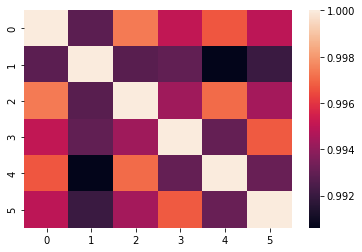

In [18]:
import seaborn as sns
sns.heatmap(pd.DataFrame(np.array(preds).T).corr())

In [134]:
X_train1 = X_train1[X_train1.event == 1]

In [135]:
X_train = pd.merge(X_train, X_train1, on=['idxs_1','idxs_2', 'event'], how='left')

In [136]:
X_val = pd.merge(X_val, X_val1, on=['idxs_1','idxs_2', 'event'], how='left')

In [15]:
X_val.shape, X_train.shape

((10855435, 24), (10930650, 24))

In [24]:
X_train1.shape

(10930650, 4)

In [25]:
X_train['tot_len_common'] = X_train1['tot_len_common'].values
X_val['tot_len_common'] = X_val1['tot_len_common'].values

In [16]:
X_val['target'].mean()

0.1044215178848199

In [26]:
X_train['sum_max_len'] = X_train['max_len_1'] + X_train['max_len_2']
X_val['sum_max_len'] = X_val['max_len_1'] + X_val['max_len_2']

In [137]:
X_train.shape, X_val.shape

((5335521, 57), (10855435, 57))

In [141]:
del X_train['target_x']
del X_val['target_x']
X_train['target'] = X_train['target_y']
X_val['target'] = X_val['target_y']
del X_train['target_y']
del X_val['target_y']

In [17]:
import xgboost

In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [ ]:
#%%time
import lightgbm as lgbm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


lgb = lgbm.sklearn.LGBMClassifier()
lgb =  xgboost.XGBClassifier(max_depth=7, learning_rate=0.05, n_estimators=400, n_jobs=8, )

lgb.fit(X_train.drop(['idxs_1','idxs_2', 'event', 'target'] ,axis=1), X_train['target'])

pred = lgb.predict(X_val.drop(['idxs_1','idxs_2', 'event', 'target'],axis=1))#[:,1]
print(accuracy_score( X_val['target'], pred))

pred = lgb.predict_proba(X_val.drop(['idxs_1','idxs_2', 'event', 'target'],axis=1))[:,1]
print(roc_auc_score( X_val['target'], pred))

In [ ]:
0.9276376303667241
0.8431900736562727


In [ ]:
0.9587954789467211
0.959167906914353

0.9577612504703865
0.9559698514425368


0.9580484798628521
0.9560189830257801

0.9430663073382135
0.9081750296230581


0.9322029932471615
0.8728398271218807

In [18]:
imp = pd.DataFrame()
imp['feat'] = X_val.drop(['idxs_1','idxs_2', 'event', 'target'], axis=1).columns
imp['imp'] = lgb.feature_importances_
imp.sort_values('imp', ascending=False)

feat  imp
12  mean_common_len  343
14   max_common_len  327
11        tot_len_2  257
10        tot_len_1  252
0              mean  245
5         std_len_2  220
3        mean_len_2  218
17        gov_len_1  212
2        mean_len_1  211
4         std_len_1  192
18        gov_len_2  154
13   std_common_len   84
19   gov_len_common   84
1               std   57
6         max_len_1   41
7         max_len_2   39
8         min_len_1   33
9         min_len_2   22
15   min_common_len    7
16          gov_val    2

In [26]:
X_train

idxs_1  idxs_2  event      mean           std  mean_len_1  \
0              0       0      1  1.000000  0.000000e+00    2.015333   
1              0    1226      1  0.001333  5.034588e-07    2.015333   
2              0    1228      1  0.081333  2.716672e-05    2.015333   
3              0    1254      1  0.001333  5.034588e-07    2.015333   
4              0    1271      1  0.081333  2.716672e-05    2.015333   
5              0    2683      1  0.066000  2.205563e-05    2.015333   
6              0    2701      1  0.003000  1.057098e-06    2.015333   
7              0    2732      1  0.003000  1.057098e-06    2.015333   
8              0    2737      1  0.066000  2.205563e-05    2.015333   
9              0    4478      1  0.066000  2.205563e-05    2.015333   
10             0    4487      1  0.003000  1.057098e-06    2.015333   
11             0    4519      1  0.066000  2.205563e-05    2.015333   
12             0    4524      1  0.003000  1.057098e-06    2.015333   
13             0    6535      1  0.025333  8.500183e-06    2.015333   
14             0    6546      1  0.061667  2.061119e-05    2.015333   
15             0    6577      1  0.025333  8.500183e-06    2.015333   
16             0    6604      1  0.061667  2.061119e-05    2.015333   
17             0    8969      1  0.054667  1.827786e-05    2.015333   
18             0    8977      1  0.027333  9.166836e-06    2.015333   
19             0    9021      1  0.027333  9.166836e-06    2.015333   
20             0    9033      1  0.054667  1.827786e-05    2.015333   
21             0   11442      1  0.002333  8.353149e-07    2.015333   
22             0   11448      1  0.054000  1.805564e-05    2.015333   
23             0   11456      1  0.022333  7.500207e-06    2.015333   
24             0   11491      1  0.022333  7.500207e-06    2.015333   
25             0   11522      1  0.002333  8.353149e-07    2.015333   
26             0   11524      1  0.054000  1.805564e-05    2.015333   
27             0   11550      1  0.022333  7.500207e-06    2.015333   
28             0   11581      1  0.054000  1.805564e-05    2.015333   
29             0   13858      1  0.002333  8.353149e-07    2.015333   
...          ...     ...    ...       ...           ...         ...   
10930620   97538   19088      2  0.000333  1.797816e-07    2.268667   
10930621   97538   19098      2  0.000333  1.797816e-07    2.268667   
10930622   97538   19870      2  0.000333  1.798889e-07    2.268667   
10930623   97538   19891      2  0.000333  1.797816e-07    2.268667   
10930624   97538   25714      2  0.002667  9.461789e-07    2.268667   
10930625   97538   26036      2  0.002667  9.461789e-07    2.268667   
10930626   97538   31486      2  0.000667  2.846170e-07    2.268667   
10930627   97538   31716      2  0.000333  1.797816e-07    2.268667   
10930628   97538   31717      2  0.000667  2.846170e-07    2.268667   
10930629   97538   31727      2  0.002333  8.353149e-07    2.268667   
10930630   97538   61815      2  0.003333  1.168055e-06    2.268667   
10930631   97538   61817      2  0.006000  2.056327e-06    2.268667   
10930632   97538   62002      2  0.000333  1.797816e-07    2.268667   
10930633   97538   62157      2  0.001333  5.034588e-07    2.268667   
10930634   97538   77543      2  0.009333  3.167163e-06    2.268667   
10930635   97538   78764      2  0.003333  1.168055e-06    2.268667   
10930636   97538   78765      2  0.009333  3.167163e-06    2.268667   
10930637   97538   80963      2  0.006667  2.278472e-06    2.268667   
10930638   97538   80985      2  0.002667  9.461789e-07    2.268667   
10930639   97538   81002      2  0.003000  1.057098e-06    2.268667   
10930640   97538   81984      2  0.003000  1.057098e-06    2.268667   
10930641   97538   81990      2  0.003333  1.168055e-06    2.268667   
10930642   97538   81992      2  0.007667  2.611715e-06    2.268667   
10930643   97538   81994      2  0.004667  1.612103e-06    2.268667   
10930644   97538   96780      2  0

In [154]:
pred = lgb.predict(X_val.drop(['idxs_1','idxs_2', 'target'],axis=1))#[:,1]

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [19]:
pred = lgb.predict_proba(X_val.drop(['idxs_1','idxs_2', 'event', 'target'],axis=1))[:,1]
pred = pred > 0.8

#pred = lgb.predict(X_val.drop(['idxs_1','idxs_2', 'target'],axis=1))

tmp_pred = X_val[['idxs_1','idxs_2']].values[np.where(pred)[0]]

In [20]:
tmp_pred.shape

(678574, 2)

In [21]:
import networkx as nx
G = nx.Graph()
G.add_edges_from(tmp_pred)

In [22]:
comp = np.array(list(nx.connected_components(G)))

In [23]:
comp.shape

(68923,)

In [37]:
comp

array([{0, 53},
       {1856, 1, 12997, 9617, 3954, 9500, 6552, 6618, 4027, 9692, 1790, 6495},
       {2}, ..., {134242}, {134243}, {134244}], dtype=object)

In [24]:
labels = np.zeros(hi[0].shape[0])
for k, i in enumerate(comp):
    labels[list(i)] = k

In [25]:
submission = create_one_event_submission(0, hi[0]['hit_id'].values, labels)
print(score_event(tr[0], submission))

0.5067474239915093


In [ ]:
0.5067474239915093

In [132]:
np.unique(labels).shape

(27774,)

In [135]:
#result = np.array(result_luis)
labels = range(result.shape[1])

for k in [0]:
    for i in range(len(result[:])):
        labels = merge(labels, result[i], k)

    submission = create_one_event_submission(0, hi[0]['hit_id'].values, labels)
    print(score_event(truth, submission))

0.5737115703904729


In [20]:
from functools import reduce
import Cluster_Ensembles as CE
cluster_runs = np.random.randint(0, 50, (50, 15000))
consensus_clustering_labels = CE.cluster_ensembles(cluster_runs, verbose = True, N_clusters_max = 50)


INFO: Cluster_Ensembles: cluster_ensembles: due to a rather large number of cells in your data-set, using only 'HyperGraph Partitioning Algorithm' (HGPA) and 'Meta-CLustering Algorithm' (MCLA) as ensemble consensus functions.



NameError: name 'reduce' is not defined

In [39]:
result

array([[     0,      1,      2, ...,  94537,  94538,  94539],
       [     0,      1,      2, ...,  97014,  97015,  97016],
       [     0,      1,      2, ...,  95731,  95732,  95733],
       ...,
       [     0,      1,      2, ..., 105583, 105584, 105585],
       [     0,      1,      2, ..., 108120, 108121, 108122],
       [     0,      1,      2, ...,  96623,  96624,  96625]])

In [26]:
X_train

mean       std  target
0        1.000000  0.000000       1
1        0.001333  0.001332       0
2        0.081333  0.074718       1
3        0.001333  0.001332       0
4        0.081333  0.074718       1
5        0.066000  0.061644       1
6        0.003000  0.002991       0
7        0.003000  0.002991       0
8        0.066000  0.061644       1
9        0.066000  0.061644       1
10       0.003000  0.002991       0
11       0.066000  0.061644       1
12       0.003000  0.002991       0
13       0.025333  0.024692       0
14       0.061667  0.057864       1
15       0.025333  0.024692       0
16       0.061667  0.057864       1
17       0.054667  0.051678       1
18       0.027333  0.026586       0
19       0.027333  0.026586       0
20       0.054667  0.051678       1
21       0.002333  0.002328       0
22       0.054000  0.051084       1
23       0.022333  0.021835       0
24       0.022333  0.021835       0
25       0.002333  0.002328       0
26       0.054000  0.051084       1
27       0.022333  0.021835       0
28       0.054000  0.051084       1
29       0.002333  0.002328       0
...           ...       ...     ...
5335491  0.001667  0.001664       0
5335492  0.001000  0.000999       0
5335493  0.003000  0.002991       0
5335494  0.001667  0.001664       0
5335495  0.006000  0.005964       0
5335496  0.001333  0.001332       0
5335497  0.002667  0.002660       0
5335498  0.005333  0.005305       0
5335499  0.000333  0.000333       0
5335500  0.005333  0.005305       0
5335501  0.005333  0.005305       0
5335502  0.005000  0.004975       0
5335503  0.002000  0.001996       0
5335504  0.002667  0.002660       0
5335505  0.001333  0.001332       0
5335506  0.004333  0.004315       0
5335507  0.002667  0.002660       0
5335508  0.004333  0.004315       0
5335509  0.003333  0.003322       0
5335510  0.007000  0.006951       0
5335511  0.005000  0.004975       1
5335512  0.009667  0.009573       0
5335513  0.009667  0.009573       0
5335514  0.011000  0.010879       1
5335515  0.017333  0.017033       0
5335516  0.010333  0.010227       0
5335517  1.000000  0.000000       1
5335518  0.226000  0.174924       1
5335519  1.000000  0.000000       1
5335520  1.000000  0.000000       1

[5335521 rows x 3 columns]

In [79]:
mean_M[mean_M.nonzero()]

matrix([[1.        , 0.00133333, 0.08133333, ..., 0.226     , 1.        ,
         1.        ]])

In [77]:
std_M[mean_M.nonzero()]

matrix([[0.        , 0.00133156, 0.07471822, ..., 0.174924  , 0.        ,
         0.        ]])

In [72]:
std_M

<100287x100287 sparse matrix of type '<class 'numpy.float64'>'
	with 5209178 stored elements in Compressed Sparse Row format>

In [83]:
np.squeeze(np.asarray(mean_M[mean_M.nonzero()]))

array([1.        , 0.00133333, 0.08133333, ..., 0.226     , 1.        ,
       1.        ])